In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
%matplotlib inline
warnings.filterwarnings("ignore")

## 1. Read csv with all variables

In [2]:
dff = pd.read_csv('MonthsDF.csv')
dff = dff.sort_values(by='date',ascending=True)
dff["date"]=pd.to_datetime(dff["date"])
dff.set_index("date",inplace=True)
df = dff.drop_duplicates(keep='first')
df = df.dropna(how='any')
df.isna().sum()

## 2. Mask for outliers

In [5]:
mask1 = (df['total_feed_ton/h_pv']>45)  & (df['total_feed_ton/h_pv']<75) | (df['total_feed_ton/h_pv']>80) & (df['total_feed_ton/h_pv']<100)
mask2 = (df['mill_dp_mbar_pv']>25) & (df['mill_dp_mbar_pv']<45)
mask3 = (df['mill_motor_pwr_kw_pv']>500) & (df['mill_motor_pwr_kw_pv']<1500)
mask4 = (df['main_fan_pwr_kw_pv']>300) & (df['main_fan_pwr_kw_pv']<600)
mask5 = (df['bucket_elv_mtr_pwr_kw_pv']>4) & (df['bucket_elv_mtr_pwr_kw_pv']<6)

mask = mask1 & mask2 & mask3 & mask4 & mask5 

dfc=df[mask]
dfc.shape
dfc.columns.tolist()

['clinker_perc_pv',
 'limestone_perc_pv',
 'slag_perc_pv',
 'gypsum_perc_pv',
 'pozzolane_perc_pv',
 'fly_ash_1_perc_pv',
 'fly_ash_2_perc_pv',
 'clinker_perc_sp',
 'limestone_perc_sp',
 'slag_perc_sp',
 'gypsum_perc_sp',
 'pozzolane_perc_sp',
 'fly_ash_1_perc_sp',
 'fly_ash_2_perc_sp',
 'total_feed_ton/h_pv',
 'clinker_ton/h_pv',
 'limestone_ton/h_pv',
 'slag_ton/h_pv',
 'gypsum_ton/h_pv',
 'pozzolane_ton/h_pv',
 'fly_ash_1_ton/h_pv',
 'fly_ash_2_ton/h_pv',
 'total_feed_ton/h_sp',
 'slag_ton/h_sp',
 'limestone_ton/h_sp',
 'clinker_ton/h_sp',
 'pozzolane_ton/h_sp',
 'gypsum_ton/h_sp',
 'fly_ash_1_ton/h_sp',
 'fly_ash_2_ton/h_sp',
 'mill_injection_water_perc_sp',
 'mill_motor_pwr_kw_pv',
 'recirculation_damper_perc_pv',
 'recirculation_damper_perc_sp',
 'fresh_air_damper_perc_pv',
 'fresh_air_damper_perc_sp',
 'main_fan_pwr_kw_pv',
 'main_fan_speed_rpm_pv',
 'main_bf_out_press_mbar_pv',
 'main_bf_dp_mbar_pv',
 'grinding_pressure_bar_sp',
 'grinding_pressure_bar_pv',
 'bucket_elv_mtr_pwr

## 3. Cement Type Split

In [6]:
dfc1=dfc[dfc['cement_type_cpii_bool_pv']==1]
dfc2=dfc[dfc['cement_type_cpii_bool_pv']==0]
dfc1.isnull().sum()

clinker_perc_pv               0
limestone_perc_pv             0
slag_perc_pv                  0
gypsum_perc_pv                0
pozzolane_perc_pv             0
                             ..
moisture_fly_ash_1_perc_pv    0
moisture_fly_ash_2_perc_pv    0
time_sample_taken_cpii_pv     0
cement_type_cpii_bool_pv      0
cement_type_cpiv_bool_pv      0
Length: 91, dtype: int64

## 4. Resampling

In [7]:
dfc1r=dfc1.resample('60s').median()

dfc2r=dfc2.resample('60s').median()
print(dfc1r.shape,dfc2r.shape)

(247924, 91) (251328, 91)


## 5. Delete consecutive NaNs

#### cement type I

In [8]:
#Find indices of rows where all elements are NaNs
nan_dates = dfc1r[pd.isnull(dfc1r).all(axis=1)].index

def time_dist(s, i, i_2):
    x = abs(s[i_2] - s[i]).seconds
    return x

list1 = pd.Series([])   # Stores ποσα νανς ειναι σερι
list_index = 0

sum1 = 1                # Counts nans που ειναι σερι
total=0
dates = pd.Series([])   # Stores two kinds of data: 1. the index of the date that is the last one in each bundle of NaNs 
                                                  # 2. how many NaNs ειναι σερι (the length of the bundle of NaNs)
dates_index = 0
for i in range(len(nan_dates)-1):
    if time_dist(nan_dates, i, i+1) == 60 :
        sum1= sum1+1
    else:
        if sum1 > 5:
            dates[dates_index] = nan_dates[i]   # We want to store indices only when the bundle's length is > 2
            dates[dates_index+1] = sum1         # We will use this Series when deleting NaNs bundles (with length>2) from dataframes
            dates_index = dates_index+2 
            total = total+sum1
        list1[list_index]=sum1
        sum1=1
        list_index= list_index+1
print(list1)

0         2
1        53
2        33
3         9
4         7
       ... 
661    1003
662       5
663       2
664       1
665     930
Length: 666, dtype: int64


In [9]:
# Here, we delete bundles of NaNs if their length is > 2
# First, we want to find where the indices stored in "dates" Series are in df_60
first_el = 0
for i in range (0,len(dates),2):  
    flag = True
    j=first_el
    while (flag ==True and j<len(dfc1r)):   
        if dfc1r.index[j] == dates[i]:
            first_el = j - dates[i+1] + 1  # the index of the first row to be deleted
            last_el = j+1                  # the index of the last row to be deleted
            ind_to_drop = list(range(first_el,last_el))  # these are the indices to be dropped
            ind_to_keep = set(range(dfc1r.shape[0])) - set(ind_to_drop)
            dfc1r = dfc1r.take(list(ind_to_keep))  
            print(i,'/722 dropped')
            flag = False                   # We need this flag because otherwise j would continue searching in df_30
        j = j+1

0 /722 dropped
2 /722 dropped
4 /722 dropped
6 /722 dropped
8 /722 dropped
10 /722 dropped
12 /722 dropped
14 /722 dropped
16 /722 dropped
18 /722 dropped
20 /722 dropped
22 /722 dropped
24 /722 dropped
26 /722 dropped
28 /722 dropped
30 /722 dropped
32 /722 dropped
34 /722 dropped
36 /722 dropped
38 /722 dropped
40 /722 dropped
42 /722 dropped
44 /722 dropped
46 /722 dropped
48 /722 dropped
50 /722 dropped
52 /722 dropped
54 /722 dropped
56 /722 dropped
58 /722 dropped
60 /722 dropped
62 /722 dropped
64 /722 dropped
66 /722 dropped
68 /722 dropped
70 /722 dropped
72 /722 dropped
74 /722 dropped
76 /722 dropped
78 /722 dropped
80 /722 dropped
82 /722 dropped
84 /722 dropped
86 /722 dropped
88 /722 dropped
90 /722 dropped
92 /722 dropped
94 /722 dropped
96 /722 dropped
98 /722 dropped
100 /722 dropped
102 /722 dropped
104 /722 dropped
106 /722 dropped
108 /722 dropped
110 /722 dropped
112 /722 dropped
114 /722 dropped
116 /722 dropped
118 /722 dropped
120 /722 dropped
122 /722 dropped
1

#### cement type II

In [10]:
#Find indices of rows where all elements are NaNs
nan_dates = dfc2r[pd.isnull(dfc2r).all(axis=1)].index

def time_dist(s, i, i_2):
    x = abs(s[i_2] - s[i]).seconds
    return x

list1 = pd.Series([])   # Stores ποσα νανς ειναι σερι
list_index = 0

sum1 = 1                # Counts nans που ειναι σερι
total=0
dates = pd.Series([])   # Stores two kinds of data: 1. the index of the date that is the last one in each bundle of NaNs 
                                                  # 2. how many NaNs ειναι σερι (the length of the bundle of NaNs)
dates_index = 0
for i in range(len(nan_dates)-1):
    if time_dist(nan_dates, i, i+1) == 60 :
        sum1= sum1+1
    else:
        if sum1 > 5:
            dates[dates_index] = nan_dates[i]   # We want to store indices only when the bundle's length is > 2
            dates[dates_index+1] = sum1         # We will use this Series when deleting NaNs bundles (with length>2) from dataframes
            dates_index = dates_index+2 
            total = total+sum1
        list1[list_index]=sum1
        sum1=1
        list_index= list_index+1
print(list1)

0        4
1       11
2        1
3        1
4       11
        ..
1907     1
1908     3
1909     1
1910     1
1911     1
Length: 1912, dtype: int64


In [11]:
# Here, we delete bundles of NaNs if their length is > 5
# First, we want to find where the indices stored in "dates" Series are in df_60
first_el = 0
for i in range (0,len(dates),2):  
    flag = True
    j=first_el
    while (flag ==True and j<len(dfc2r)):   
        if dfc2r.index[j] == dates[i]:
            first_el = j - dates[i+1] + 1  # the index of the first row to be deleted
            last_el = j+1                  # the index of the last row to be deleted
            ind_to_drop = list(range(first_el,last_el))  # these are the indices to be dropped
            ind_to_keep = set(range(dfc2r.shape[0])) - set(ind_to_drop)
            dfc2r = dfc2r.take(list(ind_to_keep))  
            print(i,'/1234 dropped')
            flag = False                   # We need this flag because otherwise j would continue searching in df_30
        j = j+1

0 /1234 dropped
2 /1234 dropped
4 /1234 dropped
6 /1234 dropped
8 /1234 dropped
10 /1234 dropped
12 /1234 dropped
14 /1234 dropped
16 /1234 dropped
18 /1234 dropped
20 /1234 dropped
22 /1234 dropped
24 /1234 dropped
26 /1234 dropped
28 /1234 dropped
30 /1234 dropped
32 /1234 dropped
34 /1234 dropped
36 /1234 dropped
38 /1234 dropped
40 /1234 dropped
42 /1234 dropped
44 /1234 dropped
46 /1234 dropped
48 /1234 dropped
50 /1234 dropped
52 /1234 dropped
54 /1234 dropped
56 /1234 dropped
58 /1234 dropped
60 /1234 dropped
62 /1234 dropped
64 /1234 dropped
66 /1234 dropped
68 /1234 dropped
70 /1234 dropped
72 /1234 dropped
74 /1234 dropped
76 /1234 dropped
78 /1234 dropped
80 /1234 dropped
82 /1234 dropped
84 /1234 dropped
86 /1234 dropped
88 /1234 dropped
90 /1234 dropped
92 /1234 dropped
94 /1234 dropped
96 /1234 dropped
98 /1234 dropped
100 /1234 dropped
102 /1234 dropped
104 /1234 dropped
106 /1234 dropped
108 /1234 dropped
110 /1234 dropped
112 /1234 dropped
114 /1234 dropped
116 /1234 d

920 /1234 dropped
922 /1234 dropped
924 /1234 dropped
926 /1234 dropped
928 /1234 dropped
930 /1234 dropped
932 /1234 dropped
934 /1234 dropped
936 /1234 dropped
938 /1234 dropped
940 /1234 dropped
942 /1234 dropped
944 /1234 dropped
946 /1234 dropped
948 /1234 dropped
950 /1234 dropped
952 /1234 dropped
954 /1234 dropped
956 /1234 dropped
958 /1234 dropped
960 /1234 dropped
962 /1234 dropped
964 /1234 dropped
966 /1234 dropped
968 /1234 dropped
970 /1234 dropped
972 /1234 dropped
974 /1234 dropped
976 /1234 dropped
978 /1234 dropped
980 /1234 dropped
982 /1234 dropped
984 /1234 dropped
986 /1234 dropped
988 /1234 dropped
990 /1234 dropped
992 /1234 dropped
994 /1234 dropped
996 /1234 dropped
998 /1234 dropped
1000 /1234 dropped
1002 /1234 dropped
1004 /1234 dropped
1006 /1234 dropped
1008 /1234 dropped
1010 /1234 dropped
1012 /1234 dropped
1014 /1234 dropped
1016 /1234 dropped
1018 /1234 dropped
1020 /1234 dropped
1022 /1234 dropped
1024 /1234 dropped
1026 /1234 dropped
1028 /1234 dro

## 6. Interpolation

In [24]:
dfc1r.interpolate(inplace = True, limit = 6)
dfc2r.interpolate(inplace = True, limit = 6)

## 7. Find periods with consecutive dates

#### cement type I

In [25]:
m1=[]
sum1 = 1                

for i in range(len(dfc1r)-1):
    if time_dist(dfc1r.index, i, i+1) == 60 :
        sum1= sum1+1
    else:
        m1.append([sum1, i])
        sum1=1
    print(i, '/ 51769')

0 / 51769
1 / 51769
2 / 51769
3 / 51769
4 / 51769
5 / 51769
6 / 51769
7 / 51769
8 / 51769
9 / 51769
10 / 51769
11 / 51769
12 / 51769
13 / 51769
14 / 51769
15 / 51769
16 / 51769
17 / 51769
18 / 51769
19 / 51769
20 / 51769
21 / 51769
22 / 51769
23 / 51769
24 / 51769
25 / 51769
26 / 51769
27 / 51769
28 / 51769
29 / 51769
30 / 51769
31 / 51769
32 / 51769
33 / 51769
34 / 51769
35 / 51769
36 / 51769
37 / 51769
38 / 51769
39 / 51769
40 / 51769
41 / 51769
42 / 51769
43 / 51769
44 / 51769
45 / 51769
46 / 51769
47 / 51769
48 / 51769
49 / 51769
50 / 51769
51 / 51769
52 / 51769
53 / 51769
54 / 51769
55 / 51769
56 / 51769
57 / 51769
58 / 51769
59 / 51769
60 / 51769
61 / 51769
62 / 51769
63 / 51769
64 / 51769
65 / 51769
66 / 51769
67 / 51769
68 / 51769
69 / 51769
70 / 51769
71 / 51769
72 / 51769
73 / 51769
74 / 51769
75 / 51769
76 / 51769
77 / 51769
78 / 51769
79 / 51769
80 / 51769
81 / 51769
82 / 51769
83 / 51769
84 / 51769
85 / 51769
86 / 51769
87 / 51769
88 / 51769
89 / 51769
90 / 51769
91 / 5176

806 / 51769
807 / 51769
808 / 51769
809 / 51769
810 / 51769
811 / 51769
812 / 51769
813 / 51769
814 / 51769
815 / 51769
816 / 51769
817 / 51769
818 / 51769
819 / 51769
820 / 51769
821 / 51769
822 / 51769
823 / 51769
824 / 51769
825 / 51769
826 / 51769
827 / 51769
828 / 51769
829 / 51769
830 / 51769
831 / 51769
832 / 51769
833 / 51769
834 / 51769
835 / 51769
836 / 51769
837 / 51769
838 / 51769
839 / 51769
840 / 51769
841 / 51769
842 / 51769
843 / 51769
844 / 51769
845 / 51769
846 / 51769
847 / 51769
848 / 51769
849 / 51769
850 / 51769
851 / 51769
852 / 51769
853 / 51769
854 / 51769
855 / 51769
856 / 51769
857 / 51769
858 / 51769
859 / 51769
860 / 51769
861 / 51769
862 / 51769
863 / 51769
864 / 51769
865 / 51769
866 / 51769
867 / 51769
868 / 51769
869 / 51769
870 / 51769
871 / 51769
872 / 51769
873 / 51769
874 / 51769
875 / 51769
876 / 51769
877 / 51769
878 / 51769
879 / 51769
880 / 51769
881 / 51769
882 / 51769
883 / 51769
884 / 51769
885 / 51769
886 / 51769
887 / 51769
888 / 51769
889 

1585 / 51769
1586 / 51769
1587 / 51769
1588 / 51769
1589 / 51769
1590 / 51769
1591 / 51769
1592 / 51769
1593 / 51769
1594 / 51769
1595 / 51769
1596 / 51769
1597 / 51769
1598 / 51769
1599 / 51769
1600 / 51769
1601 / 51769
1602 / 51769
1603 / 51769
1604 / 51769
1605 / 51769
1606 / 51769
1607 / 51769
1608 / 51769
1609 / 51769
1610 / 51769
1611 / 51769
1612 / 51769
1613 / 51769
1614 / 51769
1615 / 51769
1616 / 51769
1617 / 51769
1618 / 51769
1619 / 51769
1620 / 51769
1621 / 51769
1622 / 51769
1623 / 51769
1624 / 51769
1625 / 51769
1626 / 51769
1627 / 51769
1628 / 51769
1629 / 51769
1630 / 51769
1631 / 51769
1632 / 51769
1633 / 51769
1634 / 51769
1635 / 51769
1636 / 51769
1637 / 51769
1638 / 51769
1639 / 51769
1640 / 51769
1641 / 51769
1642 / 51769
1643 / 51769
1644 / 51769
1645 / 51769
1646 / 51769
1647 / 51769
1648 / 51769
1649 / 51769
1650 / 51769
1651 / 51769
1652 / 51769
1653 / 51769
1654 / 51769
1655 / 51769
1656 / 51769
1657 / 51769
1658 / 51769
1659 / 51769
1660 / 51769
1661 / 51769

2670 / 51769
2671 / 51769
2672 / 51769
2673 / 51769
2674 / 51769
2675 / 51769
2676 / 51769
2677 / 51769
2678 / 51769
2679 / 51769
2680 / 51769
2681 / 51769
2682 / 51769
2683 / 51769
2684 / 51769
2685 / 51769
2686 / 51769
2687 / 51769
2688 / 51769
2689 / 51769
2690 / 51769
2691 / 51769
2692 / 51769
2693 / 51769
2694 / 51769
2695 / 51769
2696 / 51769
2697 / 51769
2698 / 51769
2699 / 51769
2700 / 51769
2701 / 51769
2702 / 51769
2703 / 51769
2704 / 51769
2705 / 51769
2706 / 51769
2707 / 51769
2708 / 51769
2709 / 51769
2710 / 51769
2711 / 51769
2712 / 51769
2713 / 51769
2714 / 51769
2715 / 51769
2716 / 51769
2717 / 51769
2718 / 51769
2719 / 51769
2720 / 51769
2721 / 51769
2722 / 51769
2723 / 51769
2724 / 51769
2725 / 51769
2726 / 51769
2727 / 51769
2728 / 51769
2729 / 51769
2730 / 51769
2731 / 51769
2732 / 51769
2733 / 51769
2734 / 51769
2735 / 51769
2736 / 51769
2737 / 51769
2738 / 51769
2739 / 51769
2740 / 51769
2741 / 51769
2742 / 51769
2743 / 51769
2744 / 51769
2745 / 51769
2746 / 51769

3972 / 51769
3973 / 51769
3974 / 51769
3975 / 51769
3976 / 51769
3977 / 51769
3978 / 51769
3979 / 51769
3980 / 51769
3981 / 51769
3982 / 51769
3983 / 51769
3984 / 51769
3985 / 51769
3986 / 51769
3987 / 51769
3988 / 51769
3989 / 51769
3990 / 51769
3991 / 51769
3992 / 51769
3993 / 51769
3994 / 51769
3995 / 51769
3996 / 51769
3997 / 51769
3998 / 51769
3999 / 51769
4000 / 51769
4001 / 51769
4002 / 51769
4003 / 51769
4004 / 51769
4005 / 51769
4006 / 51769
4007 / 51769
4008 / 51769
4009 / 51769
4010 / 51769
4011 / 51769
4012 / 51769
4013 / 51769
4014 / 51769
4015 / 51769
4016 / 51769
4017 / 51769
4018 / 51769
4019 / 51769
4020 / 51769
4021 / 51769
4022 / 51769
4023 / 51769
4024 / 51769
4025 / 51769
4026 / 51769
4027 / 51769
4028 / 51769
4029 / 51769
4030 / 51769
4031 / 51769
4032 / 51769
4033 / 51769
4034 / 51769
4035 / 51769
4036 / 51769
4037 / 51769
4038 / 51769
4039 / 51769
4040 / 51769
4041 / 51769
4042 / 51769
4043 / 51769
4044 / 51769
4045 / 51769
4046 / 51769
4047 / 51769
4048 / 51769

5024 / 51769
5025 / 51769
5026 / 51769
5027 / 51769
5028 / 51769
5029 / 51769
5030 / 51769
5031 / 51769
5032 / 51769
5033 / 51769
5034 / 51769
5035 / 51769
5036 / 51769
5037 / 51769
5038 / 51769
5039 / 51769
5040 / 51769
5041 / 51769
5042 / 51769
5043 / 51769
5044 / 51769
5045 / 51769
5046 / 51769
5047 / 51769
5048 / 51769
5049 / 51769
5050 / 51769
5051 / 51769
5052 / 51769
5053 / 51769
5054 / 51769
5055 / 51769
5056 / 51769
5057 / 51769
5058 / 51769
5059 / 51769
5060 / 51769
5061 / 51769
5062 / 51769
5063 / 51769
5064 / 51769
5065 / 51769
5066 / 51769
5067 / 51769
5068 / 51769
5069 / 51769
5070 / 51769
5071 / 51769
5072 / 51769
5073 / 51769
5074 / 51769
5075 / 51769
5076 / 51769
5077 / 51769
5078 / 51769
5079 / 51769
5080 / 51769
5081 / 51769
5082 / 51769
5083 / 51769
5084 / 51769
5085 / 51769
5086 / 51769
5087 / 51769
5088 / 51769
5089 / 51769
5090 / 51769
5091 / 51769
5092 / 51769
5093 / 51769
5094 / 51769
5095 / 51769
5096 / 51769
5097 / 51769
5098 / 51769
5099 / 51769
5100 / 51769

6216 / 51769
6217 / 51769
6218 / 51769
6219 / 51769
6220 / 51769
6221 / 51769
6222 / 51769
6223 / 51769
6224 / 51769
6225 / 51769
6226 / 51769
6227 / 51769
6228 / 51769
6229 / 51769
6230 / 51769
6231 / 51769
6232 / 51769
6233 / 51769
6234 / 51769
6235 / 51769
6236 / 51769
6237 / 51769
6238 / 51769
6239 / 51769
6240 / 51769
6241 / 51769
6242 / 51769
6243 / 51769
6244 / 51769
6245 / 51769
6246 / 51769
6247 / 51769
6248 / 51769
6249 / 51769
6250 / 51769
6251 / 51769
6252 / 51769
6253 / 51769
6254 / 51769
6255 / 51769
6256 / 51769
6257 / 51769
6258 / 51769
6259 / 51769
6260 / 51769
6261 / 51769
6262 / 51769
6263 / 51769
6264 / 51769
6265 / 51769
6266 / 51769
6267 / 51769
6268 / 51769
6269 / 51769
6270 / 51769
6271 / 51769
6272 / 51769
6273 / 51769
6274 / 51769
6275 / 51769
6276 / 51769
6277 / 51769
6278 / 51769
6279 / 51769
6280 / 51769
6281 / 51769
6282 / 51769
6283 / 51769
6284 / 51769
6285 / 51769
6286 / 51769
6287 / 51769
6288 / 51769
6289 / 51769
6290 / 51769
6291 / 51769
6292 / 51769

7260 / 51769
7261 / 51769
7262 / 51769
7263 / 51769
7264 / 51769
7265 / 51769
7266 / 51769
7267 / 51769
7268 / 51769
7269 / 51769
7270 / 51769
7271 / 51769
7272 / 51769
7273 / 51769
7274 / 51769
7275 / 51769
7276 / 51769
7277 / 51769
7278 / 51769
7279 / 51769
7280 / 51769
7281 / 51769
7282 / 51769
7283 / 51769
7284 / 51769
7285 / 51769
7286 / 51769
7287 / 51769
7288 / 51769
7289 / 51769
7290 / 51769
7291 / 51769
7292 / 51769
7293 / 51769
7294 / 51769
7295 / 51769
7296 / 51769
7297 / 51769
7298 / 51769
7299 / 51769
7300 / 51769
7301 / 51769
7302 / 51769
7303 / 51769
7304 / 51769
7305 / 51769
7306 / 51769
7307 / 51769
7308 / 51769
7309 / 51769
7310 / 51769
7311 / 51769
7312 / 51769
7313 / 51769
7314 / 51769
7315 / 51769
7316 / 51769
7317 / 51769
7318 / 51769
7319 / 51769
7320 / 51769
7321 / 51769
7322 / 51769
7323 / 51769
7324 / 51769
7325 / 51769
7326 / 51769
7327 / 51769
7328 / 51769
7329 / 51769
7330 / 51769
7331 / 51769
7332 / 51769
7333 / 51769
7334 / 51769
7335 / 51769
7336 / 51769

8030 / 51769
8031 / 51769
8032 / 51769
8033 / 51769
8034 / 51769
8035 / 51769
8036 / 51769
8037 / 51769
8038 / 51769
8039 / 51769
8040 / 51769
8041 / 51769
8042 / 51769
8043 / 51769
8044 / 51769
8045 / 51769
8046 / 51769
8047 / 51769
8048 / 51769
8049 / 51769
8050 / 51769
8051 / 51769
8052 / 51769
8053 / 51769
8054 / 51769
8055 / 51769
8056 / 51769
8057 / 51769
8058 / 51769
8059 / 51769
8060 / 51769
8061 / 51769
8062 / 51769
8063 / 51769
8064 / 51769
8065 / 51769
8066 / 51769
8067 / 51769
8068 / 51769
8069 / 51769
8070 / 51769
8071 / 51769
8072 / 51769
8073 / 51769
8074 / 51769
8075 / 51769
8076 / 51769
8077 / 51769
8078 / 51769
8079 / 51769
8080 / 51769
8081 / 51769
8082 / 51769
8083 / 51769
8084 / 51769
8085 / 51769
8086 / 51769
8087 / 51769
8088 / 51769
8089 / 51769
8090 / 51769
8091 / 51769
8092 / 51769
8093 / 51769
8094 / 51769
8095 / 51769
8096 / 51769
8097 / 51769
8098 / 51769
8099 / 51769
8100 / 51769
8101 / 51769
8102 / 51769
8103 / 51769
8104 / 51769
8105 / 51769
8106 / 51769

9137 / 51769
9138 / 51769
9139 / 51769
9140 / 51769
9141 / 51769
9142 / 51769
9143 / 51769
9144 / 51769
9145 / 51769
9146 / 51769
9147 / 51769
9148 / 51769
9149 / 51769
9150 / 51769
9151 / 51769
9152 / 51769
9153 / 51769
9154 / 51769
9155 / 51769
9156 / 51769
9157 / 51769
9158 / 51769
9159 / 51769
9160 / 51769
9161 / 51769
9162 / 51769
9163 / 51769
9164 / 51769
9165 / 51769
9166 / 51769
9167 / 51769
9168 / 51769
9169 / 51769
9170 / 51769
9171 / 51769
9172 / 51769
9173 / 51769
9174 / 51769
9175 / 51769
9176 / 51769
9177 / 51769
9178 / 51769
9179 / 51769
9180 / 51769
9181 / 51769
9182 / 51769
9183 / 51769
9184 / 51769
9185 / 51769
9186 / 51769
9187 / 51769
9188 / 51769
9189 / 51769
9190 / 51769
9191 / 51769
9192 / 51769
9193 / 51769
9194 / 51769
9195 / 51769
9196 / 51769
9197 / 51769
9198 / 51769
9199 / 51769
9200 / 51769
9201 / 51769
9202 / 51769
9203 / 51769
9204 / 51769
9205 / 51769
9206 / 51769
9207 / 51769
9208 / 51769
9209 / 51769
9210 / 51769
9211 / 51769
9212 / 51769
9213 / 51769

10218 / 51769
10219 / 51769
10220 / 51769
10221 / 51769
10222 / 51769
10223 / 51769
10224 / 51769
10225 / 51769
10226 / 51769
10227 / 51769
10228 / 51769
10229 / 51769
10230 / 51769
10231 / 51769
10232 / 51769
10233 / 51769
10234 / 51769
10235 / 51769
10236 / 51769
10237 / 51769
10238 / 51769
10239 / 51769
10240 / 51769
10241 / 51769
10242 / 51769
10243 / 51769
10244 / 51769
10245 / 51769
10246 / 51769
10247 / 51769
10248 / 51769
10249 / 51769
10250 / 51769
10251 / 51769
10252 / 51769
10253 / 51769
10254 / 51769
10255 / 51769
10256 / 51769
10257 / 51769
10258 / 51769
10259 / 51769
10260 / 51769
10261 / 51769
10262 / 51769
10263 / 51769
10264 / 51769
10265 / 51769
10266 / 51769
10267 / 51769
10268 / 51769
10269 / 51769
10270 / 51769
10271 / 51769
10272 / 51769
10273 / 51769
10274 / 51769
10275 / 51769
10276 / 51769
10277 / 51769
10278 / 51769
10279 / 51769
10280 / 51769
10281 / 51769
10282 / 51769
10283 / 51769
10284 / 51769
10285 / 51769
10286 / 51769
10287 / 51769
10288 / 51769
10289 

10820 / 51769
10821 / 51769
10822 / 51769
10823 / 51769
10824 / 51769
10825 / 51769
10826 / 51769
10827 / 51769
10828 / 51769
10829 / 51769
10830 / 51769
10831 / 51769
10832 / 51769
10833 / 51769
10834 / 51769
10835 / 51769
10836 / 51769
10837 / 51769
10838 / 51769
10839 / 51769
10840 / 51769
10841 / 51769
10842 / 51769
10843 / 51769
10844 / 51769
10845 / 51769
10846 / 51769
10847 / 51769
10848 / 51769
10849 / 51769
10850 / 51769
10851 / 51769
10852 / 51769
10853 / 51769
10854 / 51769
10855 / 51769
10856 / 51769
10857 / 51769
10858 / 51769
10859 / 51769
10860 / 51769
10861 / 51769
10862 / 51769
10863 / 51769
10864 / 51769
10865 / 51769
10866 / 51769
10867 / 51769
10868 / 51769
10869 / 51769
10870 / 51769
10871 / 51769
10872 / 51769
10873 / 51769
10874 / 51769
10875 / 51769
10876 / 51769
10877 / 51769
10878 / 51769
10879 / 51769
10880 / 51769
10881 / 51769
10882 / 51769
10883 / 51769
10884 / 51769
10885 / 51769
10886 / 51769
10887 / 51769
10888 / 51769
10889 / 51769
10890 / 51769
10891 

11445 / 51769
11446 / 51769
11447 / 51769
11448 / 51769
11449 / 51769
11450 / 51769
11451 / 51769
11452 / 51769
11453 / 51769
11454 / 51769
11455 / 51769
11456 / 51769
11457 / 51769
11458 / 51769
11459 / 51769
11460 / 51769
11461 / 51769
11462 / 51769
11463 / 51769
11464 / 51769
11465 / 51769
11466 / 51769
11467 / 51769
11468 / 51769
11469 / 51769
11470 / 51769
11471 / 51769
11472 / 51769
11473 / 51769
11474 / 51769
11475 / 51769
11476 / 51769
11477 / 51769
11478 / 51769
11479 / 51769
11480 / 51769
11481 / 51769
11482 / 51769
11483 / 51769
11484 / 51769
11485 / 51769
11486 / 51769
11487 / 51769
11488 / 51769
11489 / 51769
11490 / 51769
11491 / 51769
11492 / 51769
11493 / 51769
11494 / 51769
11495 / 51769
11496 / 51769
11497 / 51769
11498 / 51769
11499 / 51769
11500 / 51769
11501 / 51769
11502 / 51769
11503 / 51769
11504 / 51769
11505 / 51769
11506 / 51769
11507 / 51769
11508 / 51769
11509 / 51769
11510 / 51769
11511 / 51769
11512 / 51769
11513 / 51769
11514 / 51769
11515 / 51769
11516 

12513 / 51769
12514 / 51769
12515 / 51769
12516 / 51769
12517 / 51769
12518 / 51769
12519 / 51769
12520 / 51769
12521 / 51769
12522 / 51769
12523 / 51769
12524 / 51769
12525 / 51769
12526 / 51769
12527 / 51769
12528 / 51769
12529 / 51769
12530 / 51769
12531 / 51769
12532 / 51769
12533 / 51769
12534 / 51769
12535 / 51769
12536 / 51769
12537 / 51769
12538 / 51769
12539 / 51769
12540 / 51769
12541 / 51769
12542 / 51769
12543 / 51769
12544 / 51769
12545 / 51769
12546 / 51769
12547 / 51769
12548 / 51769
12549 / 51769
12550 / 51769
12551 / 51769
12552 / 51769
12553 / 51769
12554 / 51769
12555 / 51769
12556 / 51769
12557 / 51769
12558 / 51769
12559 / 51769
12560 / 51769
12561 / 51769
12562 / 51769
12563 / 51769
12564 / 51769
12565 / 51769
12566 / 51769
12567 / 51769
12568 / 51769
12569 / 51769
12570 / 51769
12571 / 51769
12572 / 51769
12573 / 51769
12574 / 51769
12575 / 51769
12576 / 51769
12577 / 51769
12578 / 51769
12579 / 51769
12580 / 51769
12581 / 51769
12582 / 51769
12583 / 51769
12584 

13615 / 51769
13616 / 51769
13617 / 51769
13618 / 51769
13619 / 51769
13620 / 51769
13621 / 51769
13622 / 51769
13623 / 51769
13624 / 51769
13625 / 51769
13626 / 51769
13627 / 51769
13628 / 51769
13629 / 51769
13630 / 51769
13631 / 51769
13632 / 51769
13633 / 51769
13634 / 51769
13635 / 51769
13636 / 51769
13637 / 51769
13638 / 51769
13639 / 51769
13640 / 51769
13641 / 51769
13642 / 51769
13643 / 51769
13644 / 51769
13645 / 51769
13646 / 51769
13647 / 51769
13648 / 51769
13649 / 51769
13650 / 51769
13651 / 51769
13652 / 51769
13653 / 51769
13654 / 51769
13655 / 51769
13656 / 51769
13657 / 51769
13658 / 51769
13659 / 51769
13660 / 51769
13661 / 51769
13662 / 51769
13663 / 51769
13664 / 51769
13665 / 51769
13666 / 51769
13667 / 51769
13668 / 51769
13669 / 51769
13670 / 51769
13671 / 51769
13672 / 51769
13673 / 51769
13674 / 51769
13675 / 51769
13676 / 51769
13677 / 51769
13678 / 51769
13679 / 51769
13680 / 51769
13681 / 51769
13682 / 51769
13683 / 51769
13684 / 51769
13685 / 51769
13686 

14641 / 51769
14642 / 51769
14643 / 51769
14644 / 51769
14645 / 51769
14646 / 51769
14647 / 51769
14648 / 51769
14649 / 51769
14650 / 51769
14651 / 51769
14652 / 51769
14653 / 51769
14654 / 51769
14655 / 51769
14656 / 51769
14657 / 51769
14658 / 51769
14659 / 51769
14660 / 51769
14661 / 51769
14662 / 51769
14663 / 51769
14664 / 51769
14665 / 51769
14666 / 51769
14667 / 51769
14668 / 51769
14669 / 51769
14670 / 51769
14671 / 51769
14672 / 51769
14673 / 51769
14674 / 51769
14675 / 51769
14676 / 51769
14677 / 51769
14678 / 51769
14679 / 51769
14680 / 51769
14681 / 51769
14682 / 51769
14683 / 51769
14684 / 51769
14685 / 51769
14686 / 51769
14687 / 51769
14688 / 51769
14689 / 51769
14690 / 51769
14691 / 51769
14692 / 51769
14693 / 51769
14694 / 51769
14695 / 51769
14696 / 51769
14697 / 51769
14698 / 51769
14699 / 51769
14700 / 51769
14701 / 51769
14702 / 51769
14703 / 51769
14704 / 51769
14705 / 51769
14706 / 51769
14707 / 51769
14708 / 51769
14709 / 51769
14710 / 51769
14711 / 51769
14712 

15693 / 51769
15694 / 51769
15695 / 51769
15696 / 51769
15697 / 51769
15698 / 51769
15699 / 51769
15700 / 51769
15701 / 51769
15702 / 51769
15703 / 51769
15704 / 51769
15705 / 51769
15706 / 51769
15707 / 51769
15708 / 51769
15709 / 51769
15710 / 51769
15711 / 51769
15712 / 51769
15713 / 51769
15714 / 51769
15715 / 51769
15716 / 51769
15717 / 51769
15718 / 51769
15719 / 51769
15720 / 51769
15721 / 51769
15722 / 51769
15723 / 51769
15724 / 51769
15725 / 51769
15726 / 51769
15727 / 51769
15728 / 51769
15729 / 51769
15730 / 51769
15731 / 51769
15732 / 51769
15733 / 51769
15734 / 51769
15735 / 51769
15736 / 51769
15737 / 51769
15738 / 51769
15739 / 51769
15740 / 51769
15741 / 51769
15742 / 51769
15743 / 51769
15744 / 51769
15745 / 51769
15746 / 51769
15747 / 51769
15748 / 51769
15749 / 51769
15750 / 51769
15751 / 51769
15752 / 51769
15753 / 51769
15754 / 51769
15755 / 51769
15756 / 51769
15757 / 51769
15758 / 51769
15759 / 51769
15760 / 51769
15761 / 51769
15762 / 51769
15763 / 51769
15764 

16865 / 51769
16866 / 51769
16867 / 51769
16868 / 51769
16869 / 51769
16870 / 51769
16871 / 51769
16872 / 51769
16873 / 51769
16874 / 51769
16875 / 51769
16876 / 51769
16877 / 51769
16878 / 51769
16879 / 51769
16880 / 51769
16881 / 51769
16882 / 51769
16883 / 51769
16884 / 51769
16885 / 51769
16886 / 51769
16887 / 51769
16888 / 51769
16889 / 51769
16890 / 51769
16891 / 51769
16892 / 51769
16893 / 51769
16894 / 51769
16895 / 51769
16896 / 51769
16897 / 51769
16898 / 51769
16899 / 51769
16900 / 51769
16901 / 51769
16902 / 51769
16903 / 51769
16904 / 51769
16905 / 51769
16906 / 51769
16907 / 51769
16908 / 51769
16909 / 51769
16910 / 51769
16911 / 51769
16912 / 51769
16913 / 51769
16914 / 51769
16915 / 51769
16916 / 51769
16917 / 51769
16918 / 51769
16919 / 51769
16920 / 51769
16921 / 51769
16922 / 51769
16923 / 51769
16924 / 51769
16925 / 51769
16926 / 51769
16927 / 51769
16928 / 51769
16929 / 51769
16930 / 51769
16931 / 51769
16932 / 51769
16933 / 51769
16934 / 51769
16935 / 51769
16936 

17490 / 51769
17491 / 51769
17492 / 51769
17493 / 51769
17494 / 51769
17495 / 51769
17496 / 51769
17497 / 51769
17498 / 51769
17499 / 51769
17500 / 51769
17501 / 51769
17502 / 51769
17503 / 51769
17504 / 51769
17505 / 51769
17506 / 51769
17507 / 51769
17508 / 51769
17509 / 51769
17510 / 51769
17511 / 51769
17512 / 51769
17513 / 51769
17514 / 51769
17515 / 51769
17516 / 51769
17517 / 51769
17518 / 51769
17519 / 51769
17520 / 51769
17521 / 51769
17522 / 51769
17523 / 51769
17524 / 51769
17525 / 51769
17526 / 51769
17527 / 51769
17528 / 51769
17529 / 51769
17530 / 51769
17531 / 51769
17532 / 51769
17533 / 51769
17534 / 51769
17535 / 51769
17536 / 51769
17537 / 51769
17538 / 51769
17539 / 51769
17540 / 51769
17541 / 51769
17542 / 51769
17543 / 51769
17544 / 51769
17545 / 51769
17546 / 51769
17547 / 51769
17548 / 51769
17549 / 51769
17550 / 51769
17551 / 51769
17552 / 51769
17553 / 51769
17554 / 51769
17555 / 51769
17556 / 51769
17557 / 51769
17558 / 51769
17559 / 51769
17560 / 51769
17561 

18462 / 51769
18463 / 51769
18464 / 51769
18465 / 51769
18466 / 51769
18467 / 51769
18468 / 51769
18469 / 51769
18470 / 51769
18471 / 51769
18472 / 51769
18473 / 51769
18474 / 51769
18475 / 51769
18476 / 51769
18477 / 51769
18478 / 51769
18479 / 51769
18480 / 51769
18481 / 51769
18482 / 51769
18483 / 51769
18484 / 51769
18485 / 51769
18486 / 51769
18487 / 51769
18488 / 51769
18489 / 51769
18490 / 51769
18491 / 51769
18492 / 51769
18493 / 51769
18494 / 51769
18495 / 51769
18496 / 51769
18497 / 51769
18498 / 51769
18499 / 51769
18500 / 51769
18501 / 51769
18502 / 51769
18503 / 51769
18504 / 51769
18505 / 51769
18506 / 51769
18507 / 51769
18508 / 51769
18509 / 51769
18510 / 51769
18511 / 51769
18512 / 51769
18513 / 51769
18514 / 51769
18515 / 51769
18516 / 51769
18517 / 51769
18518 / 51769
18519 / 51769
18520 / 51769
18521 / 51769
18522 / 51769
18523 / 51769
18524 / 51769
18525 / 51769
18526 / 51769
18527 / 51769
18528 / 51769
18529 / 51769
18530 / 51769
18531 / 51769
18532 / 51769
18533 

19542 / 51769
19543 / 51769
19544 / 51769
19545 / 51769
19546 / 51769
19547 / 51769
19548 / 51769
19549 / 51769
19550 / 51769
19551 / 51769
19552 / 51769
19553 / 51769
19554 / 51769
19555 / 51769
19556 / 51769
19557 / 51769
19558 / 51769
19559 / 51769
19560 / 51769
19561 / 51769
19562 / 51769
19563 / 51769
19564 / 51769
19565 / 51769
19566 / 51769
19567 / 51769
19568 / 51769
19569 / 51769
19570 / 51769
19571 / 51769
19572 / 51769
19573 / 51769
19574 / 51769
19575 / 51769
19576 / 51769
19577 / 51769
19578 / 51769
19579 / 51769
19580 / 51769
19581 / 51769
19582 / 51769
19583 / 51769
19584 / 51769
19585 / 51769
19586 / 51769
19587 / 51769
19588 / 51769
19589 / 51769
19590 / 51769
19591 / 51769
19592 / 51769
19593 / 51769
19594 / 51769
19595 / 51769
19596 / 51769
19597 / 51769
19598 / 51769
19599 / 51769
19600 / 51769
19601 / 51769
19602 / 51769
19603 / 51769
19604 / 51769
19605 / 51769
19606 / 51769
19607 / 51769
19608 / 51769
19609 / 51769
19610 / 51769
19611 / 51769
19612 / 51769
19613 

20661 / 51769
20662 / 51769
20663 / 51769
20664 / 51769
20665 / 51769
20666 / 51769
20667 / 51769
20668 / 51769
20669 / 51769
20670 / 51769
20671 / 51769
20672 / 51769
20673 / 51769
20674 / 51769
20675 / 51769
20676 / 51769
20677 / 51769
20678 / 51769
20679 / 51769
20680 / 51769
20681 / 51769
20682 / 51769
20683 / 51769
20684 / 51769
20685 / 51769
20686 / 51769
20687 / 51769
20688 / 51769
20689 / 51769
20690 / 51769
20691 / 51769
20692 / 51769
20693 / 51769
20694 / 51769
20695 / 51769
20696 / 51769
20697 / 51769
20698 / 51769
20699 / 51769
20700 / 51769
20701 / 51769
20702 / 51769
20703 / 51769
20704 / 51769
20705 / 51769
20706 / 51769
20707 / 51769
20708 / 51769
20709 / 51769
20710 / 51769
20711 / 51769
20712 / 51769
20713 / 51769
20714 / 51769
20715 / 51769
20716 / 51769
20717 / 51769
20718 / 51769
20719 / 51769
20720 / 51769
20721 / 51769
20722 / 51769
20723 / 51769
20724 / 51769
20725 / 51769
20726 / 51769
20727 / 51769
20728 / 51769
20729 / 51769
20730 / 51769
20731 / 51769
20732 

21647 / 51769
21648 / 51769
21649 / 51769
21650 / 51769
21651 / 51769
21652 / 51769
21653 / 51769
21654 / 51769
21655 / 51769
21656 / 51769
21657 / 51769
21658 / 51769
21659 / 51769
21660 / 51769
21661 / 51769
21662 / 51769
21663 / 51769
21664 / 51769
21665 / 51769
21666 / 51769
21667 / 51769
21668 / 51769
21669 / 51769
21670 / 51769
21671 / 51769
21672 / 51769
21673 / 51769
21674 / 51769
21675 / 51769
21676 / 51769
21677 / 51769
21678 / 51769
21679 / 51769
21680 / 51769
21681 / 51769
21682 / 51769
21683 / 51769
21684 / 51769
21685 / 51769
21686 / 51769
21687 / 51769
21688 / 51769
21689 / 51769
21690 / 51769
21691 / 51769
21692 / 51769
21693 / 51769
21694 / 51769
21695 / 51769
21696 / 51769
21697 / 51769
21698 / 51769
21699 / 51769
21700 / 51769
21701 / 51769
21702 / 51769
21703 / 51769
21704 / 51769
21705 / 51769
21706 / 51769
21707 / 51769
21708 / 51769
21709 / 51769
21710 / 51769
21711 / 51769
21712 / 51769
21713 / 51769
21714 / 51769
21715 / 51769
21716 / 51769
21717 / 51769
21718 

22640 / 51769
22641 / 51769
22642 / 51769
22643 / 51769
22644 / 51769
22645 / 51769
22646 / 51769
22647 / 51769
22648 / 51769
22649 / 51769
22650 / 51769
22651 / 51769
22652 / 51769
22653 / 51769
22654 / 51769
22655 / 51769
22656 / 51769
22657 / 51769
22658 / 51769
22659 / 51769
22660 / 51769
22661 / 51769
22662 / 51769
22663 / 51769
22664 / 51769
22665 / 51769
22666 / 51769
22667 / 51769
22668 / 51769
22669 / 51769
22670 / 51769
22671 / 51769
22672 / 51769
22673 / 51769
22674 / 51769
22675 / 51769
22676 / 51769
22677 / 51769
22678 / 51769
22679 / 51769
22680 / 51769
22681 / 51769
22682 / 51769
22683 / 51769
22684 / 51769
22685 / 51769
22686 / 51769
22687 / 51769
22688 / 51769
22689 / 51769
22690 / 51769
22691 / 51769
22692 / 51769
22693 / 51769
22694 / 51769
22695 / 51769
22696 / 51769
22697 / 51769
22698 / 51769
22699 / 51769
22700 / 51769
22701 / 51769
22702 / 51769
22703 / 51769
22704 / 51769
22705 / 51769
22706 / 51769
22707 / 51769
22708 / 51769
22709 / 51769
22710 / 51769
22711 

23632 / 51769
23633 / 51769
23634 / 51769
23635 / 51769
23636 / 51769
23637 / 51769
23638 / 51769
23639 / 51769
23640 / 51769
23641 / 51769
23642 / 51769
23643 / 51769
23644 / 51769
23645 / 51769
23646 / 51769
23647 / 51769
23648 / 51769
23649 / 51769
23650 / 51769
23651 / 51769
23652 / 51769
23653 / 51769
23654 / 51769
23655 / 51769
23656 / 51769
23657 / 51769
23658 / 51769
23659 / 51769
23660 / 51769
23661 / 51769
23662 / 51769
23663 / 51769
23664 / 51769
23665 / 51769
23666 / 51769
23667 / 51769
23668 / 51769
23669 / 51769
23670 / 51769
23671 / 51769
23672 / 51769
23673 / 51769
23674 / 51769
23675 / 51769
23676 / 51769
23677 / 51769
23678 / 51769
23679 / 51769
23680 / 51769
23681 / 51769
23682 / 51769
23683 / 51769
23684 / 51769
23685 / 51769
23686 / 51769
23687 / 51769
23688 / 51769
23689 / 51769
23690 / 51769
23691 / 51769
23692 / 51769
23693 / 51769
23694 / 51769
23695 / 51769
23696 / 51769
23697 / 51769
23698 / 51769
23699 / 51769
23700 / 51769
23701 / 51769
23702 / 51769
23703 

24699 / 51769
24700 / 51769
24701 / 51769
24702 / 51769
24703 / 51769
24704 / 51769
24705 / 51769
24706 / 51769
24707 / 51769
24708 / 51769
24709 / 51769
24710 / 51769
24711 / 51769
24712 / 51769
24713 / 51769
24714 / 51769
24715 / 51769
24716 / 51769
24717 / 51769
24718 / 51769
24719 / 51769
24720 / 51769
24721 / 51769
24722 / 51769
24723 / 51769
24724 / 51769
24725 / 51769
24726 / 51769
24727 / 51769
24728 / 51769
24729 / 51769
24730 / 51769
24731 / 51769
24732 / 51769
24733 / 51769
24734 / 51769
24735 / 51769
24736 / 51769
24737 / 51769
24738 / 51769
24739 / 51769
24740 / 51769
24741 / 51769
24742 / 51769
24743 / 51769
24744 / 51769
24745 / 51769
24746 / 51769
24747 / 51769
24748 / 51769
24749 / 51769
24750 / 51769
24751 / 51769
24752 / 51769
24753 / 51769
24754 / 51769
24755 / 51769
24756 / 51769
24757 / 51769
24758 / 51769
24759 / 51769
24760 / 51769
24761 / 51769
24762 / 51769
24763 / 51769
24764 / 51769
24765 / 51769
24766 / 51769
24767 / 51769
24768 / 51769
24769 / 51769
24770 

25705 / 51769
25706 / 51769
25707 / 51769
25708 / 51769
25709 / 51769
25710 / 51769
25711 / 51769
25712 / 51769
25713 / 51769
25714 / 51769
25715 / 51769
25716 / 51769
25717 / 51769
25718 / 51769
25719 / 51769
25720 / 51769
25721 / 51769
25722 / 51769
25723 / 51769
25724 / 51769
25725 / 51769
25726 / 51769
25727 / 51769
25728 / 51769
25729 / 51769
25730 / 51769
25731 / 51769
25732 / 51769
25733 / 51769
25734 / 51769
25735 / 51769
25736 / 51769
25737 / 51769
25738 / 51769
25739 / 51769
25740 / 51769
25741 / 51769
25742 / 51769
25743 / 51769
25744 / 51769
25745 / 51769
25746 / 51769
25747 / 51769
25748 / 51769
25749 / 51769
25750 / 51769
25751 / 51769
25752 / 51769
25753 / 51769
25754 / 51769
25755 / 51769
25756 / 51769
25757 / 51769
25758 / 51769
25759 / 51769
25760 / 51769
25761 / 51769
25762 / 51769
25763 / 51769
25764 / 51769
25765 / 51769
25766 / 51769
25767 / 51769
25768 / 51769
25769 / 51769
25770 / 51769
25771 / 51769
25772 / 51769
25773 / 51769
25774 / 51769
25775 / 51769
25776 

26747 / 51769
26748 / 51769
26749 / 51769
26750 / 51769
26751 / 51769
26752 / 51769
26753 / 51769
26754 / 51769
26755 / 51769
26756 / 51769
26757 / 51769
26758 / 51769
26759 / 51769
26760 / 51769
26761 / 51769
26762 / 51769
26763 / 51769
26764 / 51769
26765 / 51769
26766 / 51769
26767 / 51769
26768 / 51769
26769 / 51769
26770 / 51769
26771 / 51769
26772 / 51769
26773 / 51769
26774 / 51769
26775 / 51769
26776 / 51769
26777 / 51769
26778 / 51769
26779 / 51769
26780 / 51769
26781 / 51769
26782 / 51769
26783 / 51769
26784 / 51769
26785 / 51769
26786 / 51769
26787 / 51769
26788 / 51769
26789 / 51769
26790 / 51769
26791 / 51769
26792 / 51769
26793 / 51769
26794 / 51769
26795 / 51769
26796 / 51769
26797 / 51769
26798 / 51769
26799 / 51769
26800 / 51769
26801 / 51769
26802 / 51769
26803 / 51769
26804 / 51769
26805 / 51769
26806 / 51769
26807 / 51769
26808 / 51769
26809 / 51769
26810 / 51769
26811 / 51769
26812 / 51769
26813 / 51769
26814 / 51769
26815 / 51769
26816 / 51769
26817 / 51769
26818 

27812 / 51769
27813 / 51769
27814 / 51769
27815 / 51769
27816 / 51769
27817 / 51769
27818 / 51769
27819 / 51769
27820 / 51769
27821 / 51769
27822 / 51769
27823 / 51769
27824 / 51769
27825 / 51769
27826 / 51769
27827 / 51769
27828 / 51769
27829 / 51769
27830 / 51769
27831 / 51769
27832 / 51769
27833 / 51769
27834 / 51769
27835 / 51769
27836 / 51769
27837 / 51769
27838 / 51769
27839 / 51769
27840 / 51769
27841 / 51769
27842 / 51769
27843 / 51769
27844 / 51769
27845 / 51769
27846 / 51769
27847 / 51769
27848 / 51769
27849 / 51769
27850 / 51769
27851 / 51769
27852 / 51769
27853 / 51769
27854 / 51769
27855 / 51769
27856 / 51769
27857 / 51769
27858 / 51769
27859 / 51769
27860 / 51769
27861 / 51769
27862 / 51769
27863 / 51769
27864 / 51769
27865 / 51769
27866 / 51769
27867 / 51769
27868 / 51769
27869 / 51769
27870 / 51769
27871 / 51769
27872 / 51769
27873 / 51769
27874 / 51769
27875 / 51769
27876 / 51769
27877 / 51769
27878 / 51769
27879 / 51769
27880 / 51769
27881 / 51769
27882 / 51769
27883 

28850 / 51769
28851 / 51769
28852 / 51769
28853 / 51769
28854 / 51769
28855 / 51769
28856 / 51769
28857 / 51769
28858 / 51769
28859 / 51769
28860 / 51769
28861 / 51769
28862 / 51769
28863 / 51769
28864 / 51769
28865 / 51769
28866 / 51769
28867 / 51769
28868 / 51769
28869 / 51769
28870 / 51769
28871 / 51769
28872 / 51769
28873 / 51769
28874 / 51769
28875 / 51769
28876 / 51769
28877 / 51769
28878 / 51769
28879 / 51769
28880 / 51769
28881 / 51769
28882 / 51769
28883 / 51769
28884 / 51769
28885 / 51769
28886 / 51769
28887 / 51769
28888 / 51769
28889 / 51769
28890 / 51769
28891 / 51769
28892 / 51769
28893 / 51769
28894 / 51769
28895 / 51769
28896 / 51769
28897 / 51769
28898 / 51769
28899 / 51769
28900 / 51769
28901 / 51769
28902 / 51769
28903 / 51769
28904 / 51769
28905 / 51769
28906 / 51769
28907 / 51769
28908 / 51769
28909 / 51769
28910 / 51769
28911 / 51769
28912 / 51769
28913 / 51769
28914 / 51769
28915 / 51769
28916 / 51769
28917 / 51769
28918 / 51769
28919 / 51769
28920 / 51769
28921 

29929 / 51769
29930 / 51769
29931 / 51769
29932 / 51769
29933 / 51769
29934 / 51769
29935 / 51769
29936 / 51769
29937 / 51769
29938 / 51769
29939 / 51769
29940 / 51769
29941 / 51769
29942 / 51769
29943 / 51769
29944 / 51769
29945 / 51769
29946 / 51769
29947 / 51769
29948 / 51769
29949 / 51769
29950 / 51769
29951 / 51769
29952 / 51769
29953 / 51769
29954 / 51769
29955 / 51769
29956 / 51769
29957 / 51769
29958 / 51769
29959 / 51769
29960 / 51769
29961 / 51769
29962 / 51769
29963 / 51769
29964 / 51769
29965 / 51769
29966 / 51769
29967 / 51769
29968 / 51769
29969 / 51769
29970 / 51769
29971 / 51769
29972 / 51769
29973 / 51769
29974 / 51769
29975 / 51769
29976 / 51769
29977 / 51769
29978 / 51769
29979 / 51769
29980 / 51769
29981 / 51769
29982 / 51769
29983 / 51769
29984 / 51769
29985 / 51769
29986 / 51769
29987 / 51769
29988 / 51769
29989 / 51769
29990 / 51769
29991 / 51769
29992 / 51769
29993 / 51769
29994 / 51769
29995 / 51769
29996 / 51769
29997 / 51769
29998 / 51769
29999 / 51769
30000 

30544 / 51769
30545 / 51769
30546 / 51769
30547 / 51769
30548 / 51769
30549 / 51769
30550 / 51769
30551 / 51769
30552 / 51769
30553 / 51769
30554 / 51769
30555 / 51769
30556 / 51769
30557 / 51769
30558 / 51769
30559 / 51769
30560 / 51769
30561 / 51769
30562 / 51769
30563 / 51769
30564 / 51769
30565 / 51769
30566 / 51769
30567 / 51769
30568 / 51769
30569 / 51769
30570 / 51769
30571 / 51769
30572 / 51769
30573 / 51769
30574 / 51769
30575 / 51769
30576 / 51769
30577 / 51769
30578 / 51769
30579 / 51769
30580 / 51769
30581 / 51769
30582 / 51769
30583 / 51769
30584 / 51769
30585 / 51769
30586 / 51769
30587 / 51769
30588 / 51769
30589 / 51769
30590 / 51769
30591 / 51769
30592 / 51769
30593 / 51769
30594 / 51769
30595 / 51769
30596 / 51769
30597 / 51769
30598 / 51769
30599 / 51769
30600 / 51769
30601 / 51769
30602 / 51769
30603 / 51769
30604 / 51769
30605 / 51769
30606 / 51769
30607 / 51769
30608 / 51769
30609 / 51769
30610 / 51769
30611 / 51769
30612 / 51769
30613 / 51769
30614 / 51769
30615 

31526 / 51769
31527 / 51769
31528 / 51769
31529 / 51769
31530 / 51769
31531 / 51769
31532 / 51769
31533 / 51769
31534 / 51769
31535 / 51769
31536 / 51769
31537 / 51769
31538 / 51769
31539 / 51769
31540 / 51769
31541 / 51769
31542 / 51769
31543 / 51769
31544 / 51769
31545 / 51769
31546 / 51769
31547 / 51769
31548 / 51769
31549 / 51769
31550 / 51769
31551 / 51769
31552 / 51769
31553 / 51769
31554 / 51769
31555 / 51769
31556 / 51769
31557 / 51769
31558 / 51769
31559 / 51769
31560 / 51769
31561 / 51769
31562 / 51769
31563 / 51769
31564 / 51769
31565 / 51769
31566 / 51769
31567 / 51769
31568 / 51769
31569 / 51769
31570 / 51769
31571 / 51769
31572 / 51769
31573 / 51769
31574 / 51769
31575 / 51769
31576 / 51769
31577 / 51769
31578 / 51769
31579 / 51769
31580 / 51769
31581 / 51769
31582 / 51769
31583 / 51769
31584 / 51769
31585 / 51769
31586 / 51769
31587 / 51769
31588 / 51769
31589 / 51769
31590 / 51769
31591 / 51769
31592 / 51769
31593 / 51769
31594 / 51769
31595 / 51769
31596 / 51769
31597 

32745 / 51769
32746 / 51769
32747 / 51769
32748 / 51769
32749 / 51769
32750 / 51769
32751 / 51769
32752 / 51769
32753 / 51769
32754 / 51769
32755 / 51769
32756 / 51769
32757 / 51769
32758 / 51769
32759 / 51769
32760 / 51769
32761 / 51769
32762 / 51769
32763 / 51769
32764 / 51769
32765 / 51769
32766 / 51769
32767 / 51769
32768 / 51769
32769 / 51769
32770 / 51769
32771 / 51769
32772 / 51769
32773 / 51769
32774 / 51769
32775 / 51769
32776 / 51769
32777 / 51769
32778 / 51769
32779 / 51769
32780 / 51769
32781 / 51769
32782 / 51769
32783 / 51769
32784 / 51769
32785 / 51769
32786 / 51769
32787 / 51769
32788 / 51769
32789 / 51769
32790 / 51769
32791 / 51769
32792 / 51769
32793 / 51769
32794 / 51769
32795 / 51769
32796 / 51769
32797 / 51769
32798 / 51769
32799 / 51769
32800 / 51769
32801 / 51769
32802 / 51769
32803 / 51769
32804 / 51769
32805 / 51769
32806 / 51769
32807 / 51769
32808 / 51769
32809 / 51769
32810 / 51769
32811 / 51769
32812 / 51769
32813 / 51769
32814 / 51769
32815 / 51769
32816 

33782 / 51769
33783 / 51769
33784 / 51769
33785 / 51769
33786 / 51769
33787 / 51769
33788 / 51769
33789 / 51769
33790 / 51769
33791 / 51769
33792 / 51769
33793 / 51769
33794 / 51769
33795 / 51769
33796 / 51769
33797 / 51769
33798 / 51769
33799 / 51769
33800 / 51769
33801 / 51769
33802 / 51769
33803 / 51769
33804 / 51769
33805 / 51769
33806 / 51769
33807 / 51769
33808 / 51769
33809 / 51769
33810 / 51769
33811 / 51769
33812 / 51769
33813 / 51769
33814 / 51769
33815 / 51769
33816 / 51769
33817 / 51769
33818 / 51769
33819 / 51769
33820 / 51769
33821 / 51769
33822 / 51769
33823 / 51769
33824 / 51769
33825 / 51769
33826 / 51769
33827 / 51769
33828 / 51769
33829 / 51769
33830 / 51769
33831 / 51769
33832 / 51769
33833 / 51769
33834 / 51769
33835 / 51769
33836 / 51769
33837 / 51769
33838 / 51769
33839 / 51769
33840 / 51769
33841 / 51769
33842 / 51769
33843 / 51769
33844 / 51769
33845 / 51769
33846 / 51769
33847 / 51769
33848 / 51769
33849 / 51769
33850 / 51769
33851 / 51769
33852 / 51769
33853 

34916 / 51769
34917 / 51769
34918 / 51769
34919 / 51769
34920 / 51769
34921 / 51769
34922 / 51769
34923 / 51769
34924 / 51769
34925 / 51769
34926 / 51769
34927 / 51769
34928 / 51769
34929 / 51769
34930 / 51769
34931 / 51769
34932 / 51769
34933 / 51769
34934 / 51769
34935 / 51769
34936 / 51769
34937 / 51769
34938 / 51769
34939 / 51769
34940 / 51769
34941 / 51769
34942 / 51769
34943 / 51769
34944 / 51769
34945 / 51769
34946 / 51769
34947 / 51769
34948 / 51769
34949 / 51769
34950 / 51769
34951 / 51769
34952 / 51769
34953 / 51769
34954 / 51769
34955 / 51769
34956 / 51769
34957 / 51769
34958 / 51769
34959 / 51769
34960 / 51769
34961 / 51769
34962 / 51769
34963 / 51769
34964 / 51769
34965 / 51769
34966 / 51769
34967 / 51769
34968 / 51769
34969 / 51769
34970 / 51769
34971 / 51769
34972 / 51769
34973 / 51769
34974 / 51769
34975 / 51769
34976 / 51769
34977 / 51769
34978 / 51769
34979 / 51769
34980 / 51769
34981 / 51769
34982 / 51769
34983 / 51769
34984 / 51769
34985 / 51769
34986 / 51769
34987 

35878 / 51769
35879 / 51769
35880 / 51769
35881 / 51769
35882 / 51769
35883 / 51769
35884 / 51769
35885 / 51769
35886 / 51769
35887 / 51769
35888 / 51769
35889 / 51769
35890 / 51769
35891 / 51769
35892 / 51769
35893 / 51769
35894 / 51769
35895 / 51769
35896 / 51769
35897 / 51769
35898 / 51769
35899 / 51769
35900 / 51769
35901 / 51769
35902 / 51769
35903 / 51769
35904 / 51769
35905 / 51769
35906 / 51769
35907 / 51769
35908 / 51769
35909 / 51769
35910 / 51769
35911 / 51769
35912 / 51769
35913 / 51769
35914 / 51769
35915 / 51769
35916 / 51769
35917 / 51769
35918 / 51769
35919 / 51769
35920 / 51769
35921 / 51769
35922 / 51769
35923 / 51769
35924 / 51769
35925 / 51769
35926 / 51769
35927 / 51769
35928 / 51769
35929 / 51769
35930 / 51769
35931 / 51769
35932 / 51769
35933 / 51769
35934 / 51769
35935 / 51769
35936 / 51769
35937 / 51769
35938 / 51769
35939 / 51769
35940 / 51769
35941 / 51769
35942 / 51769
35943 / 51769
35944 / 51769
35945 / 51769
35946 / 51769
35947 / 51769
35948 / 51769
35949 

36983 / 51769
36984 / 51769
36985 / 51769
36986 / 51769
36987 / 51769
36988 / 51769
36989 / 51769
36990 / 51769
36991 / 51769
36992 / 51769
36993 / 51769
36994 / 51769
36995 / 51769
36996 / 51769
36997 / 51769
36998 / 51769
36999 / 51769
37000 / 51769
37001 / 51769
37002 / 51769
37003 / 51769
37004 / 51769
37005 / 51769
37006 / 51769
37007 / 51769
37008 / 51769
37009 / 51769
37010 / 51769
37011 / 51769
37012 / 51769
37013 / 51769
37014 / 51769
37015 / 51769
37016 / 51769
37017 / 51769
37018 / 51769
37019 / 51769
37020 / 51769
37021 / 51769
37022 / 51769
37023 / 51769
37024 / 51769
37025 / 51769
37026 / 51769
37027 / 51769
37028 / 51769
37029 / 51769
37030 / 51769
37031 / 51769
37032 / 51769
37033 / 51769
37034 / 51769
37035 / 51769
37036 / 51769
37037 / 51769
37038 / 51769
37039 / 51769
37040 / 51769
37041 / 51769
37042 / 51769
37043 / 51769
37044 / 51769
37045 / 51769
37046 / 51769
37047 / 51769
37048 / 51769
37049 / 51769
37050 / 51769
37051 / 51769
37052 / 51769
37053 / 51769
37054 

37698 / 51769
37699 / 51769
37700 / 51769
37701 / 51769
37702 / 51769
37703 / 51769
37704 / 51769
37705 / 51769
37706 / 51769
37707 / 51769
37708 / 51769
37709 / 51769
37710 / 51769
37711 / 51769
37712 / 51769
37713 / 51769
37714 / 51769
37715 / 51769
37716 / 51769
37717 / 51769
37718 / 51769
37719 / 51769
37720 / 51769
37721 / 51769
37722 / 51769
37723 / 51769
37724 / 51769
37725 / 51769
37726 / 51769
37727 / 51769
37728 / 51769
37729 / 51769
37730 / 51769
37731 / 51769
37732 / 51769
37733 / 51769
37734 / 51769
37735 / 51769
37736 / 51769
37737 / 51769
37738 / 51769
37739 / 51769
37740 / 51769
37741 / 51769
37742 / 51769
37743 / 51769
37744 / 51769
37745 / 51769
37746 / 51769
37747 / 51769
37748 / 51769
37749 / 51769
37750 / 51769
37751 / 51769
37752 / 51769
37753 / 51769
37754 / 51769
37755 / 51769
37756 / 51769
37757 / 51769
37758 / 51769
37759 / 51769
37760 / 51769
37761 / 51769
37762 / 51769
37763 / 51769
37764 / 51769
37765 / 51769
37766 / 51769
37767 / 51769
37768 / 51769
37769 

38824 / 51769
38825 / 51769
38826 / 51769
38827 / 51769
38828 / 51769
38829 / 51769
38830 / 51769
38831 / 51769
38832 / 51769
38833 / 51769
38834 / 51769
38835 / 51769
38836 / 51769
38837 / 51769
38838 / 51769
38839 / 51769
38840 / 51769
38841 / 51769
38842 / 51769
38843 / 51769
38844 / 51769
38845 / 51769
38846 / 51769
38847 / 51769
38848 / 51769
38849 / 51769
38850 / 51769
38851 / 51769
38852 / 51769
38853 / 51769
38854 / 51769
38855 / 51769
38856 / 51769
38857 / 51769
38858 / 51769
38859 / 51769
38860 / 51769
38861 / 51769
38862 / 51769
38863 / 51769
38864 / 51769
38865 / 51769
38866 / 51769
38867 / 51769
38868 / 51769
38869 / 51769
38870 / 51769
38871 / 51769
38872 / 51769
38873 / 51769
38874 / 51769
38875 / 51769
38876 / 51769
38877 / 51769
38878 / 51769
38879 / 51769
38880 / 51769
38881 / 51769
38882 / 51769
38883 / 51769
38884 / 51769
38885 / 51769
38886 / 51769
38887 / 51769
38888 / 51769
38889 / 51769
38890 / 51769
38891 / 51769
38892 / 51769
38893 / 51769
38894 / 51769
38895 

39748 / 51769
39749 / 51769
39750 / 51769
39751 / 51769
39752 / 51769
39753 / 51769
39754 / 51769
39755 / 51769
39756 / 51769
39757 / 51769
39758 / 51769
39759 / 51769
39760 / 51769
39761 / 51769
39762 / 51769
39763 / 51769
39764 / 51769
39765 / 51769
39766 / 51769
39767 / 51769
39768 / 51769
39769 / 51769
39770 / 51769
39771 / 51769
39772 / 51769
39773 / 51769
39774 / 51769
39775 / 51769
39776 / 51769
39777 / 51769
39778 / 51769
39779 / 51769
39780 / 51769
39781 / 51769
39782 / 51769
39783 / 51769
39784 / 51769
39785 / 51769
39786 / 51769
39787 / 51769
39788 / 51769
39789 / 51769
39790 / 51769
39791 / 51769
39792 / 51769
39793 / 51769
39794 / 51769
39795 / 51769
39796 / 51769
39797 / 51769
39798 / 51769
39799 / 51769
39800 / 51769
39801 / 51769
39802 / 51769
39803 / 51769
39804 / 51769
39805 / 51769
39806 / 51769
39807 / 51769
39808 / 51769
39809 / 51769
39810 / 51769
39811 / 51769
39812 / 51769
39813 / 51769
39814 / 51769
39815 / 51769
39816 / 51769
39817 / 51769
39818 / 51769
39819 

40747 / 51769
40748 / 51769
40749 / 51769
40750 / 51769
40751 / 51769
40752 / 51769
40753 / 51769
40754 / 51769
40755 / 51769
40756 / 51769
40757 / 51769
40758 / 51769
40759 / 51769
40760 / 51769
40761 / 51769
40762 / 51769
40763 / 51769
40764 / 51769
40765 / 51769
40766 / 51769
40767 / 51769
40768 / 51769
40769 / 51769
40770 / 51769
40771 / 51769
40772 / 51769
40773 / 51769
40774 / 51769
40775 / 51769
40776 / 51769
40777 / 51769
40778 / 51769
40779 / 51769
40780 / 51769
40781 / 51769
40782 / 51769
40783 / 51769
40784 / 51769
40785 / 51769
40786 / 51769
40787 / 51769
40788 / 51769
40789 / 51769
40790 / 51769
40791 / 51769
40792 / 51769
40793 / 51769
40794 / 51769
40795 / 51769
40796 / 51769
40797 / 51769
40798 / 51769
40799 / 51769
40800 / 51769
40801 / 51769
40802 / 51769
40803 / 51769
40804 / 51769
40805 / 51769
40806 / 51769
40807 / 51769
40808 / 51769
40809 / 51769
40810 / 51769
40811 / 51769
40812 / 51769
40813 / 51769
40814 / 51769
40815 / 51769
40816 / 51769
40817 / 51769
40818 

41454 / 51769
41455 / 51769
41456 / 51769
41457 / 51769
41458 / 51769
41459 / 51769
41460 / 51769
41461 / 51769
41462 / 51769
41463 / 51769
41464 / 51769
41465 / 51769
41466 / 51769
41467 / 51769
41468 / 51769
41469 / 51769
41470 / 51769
41471 / 51769
41472 / 51769
41473 / 51769
41474 / 51769
41475 / 51769
41476 / 51769
41477 / 51769
41478 / 51769
41479 / 51769
41480 / 51769
41481 / 51769
41482 / 51769
41483 / 51769
41484 / 51769
41485 / 51769
41486 / 51769
41487 / 51769
41488 / 51769
41489 / 51769
41490 / 51769
41491 / 51769
41492 / 51769
41493 / 51769
41494 / 51769
41495 / 51769
41496 / 51769
41497 / 51769
41498 / 51769
41499 / 51769
41500 / 51769
41501 / 51769
41502 / 51769
41503 / 51769
41504 / 51769
41505 / 51769
41506 / 51769
41507 / 51769
41508 / 51769
41509 / 51769
41510 / 51769
41511 / 51769
41512 / 51769
41513 / 51769
41514 / 51769
41515 / 51769
41516 / 51769
41517 / 51769
41518 / 51769
41519 / 51769
41520 / 51769
41521 / 51769
41522 / 51769
41523 / 51769
41524 / 51769
41525 

42451 / 51769
42452 / 51769
42453 / 51769
42454 / 51769
42455 / 51769
42456 / 51769
42457 / 51769
42458 / 51769
42459 / 51769
42460 / 51769
42461 / 51769
42462 / 51769
42463 / 51769
42464 / 51769
42465 / 51769
42466 / 51769
42467 / 51769
42468 / 51769
42469 / 51769
42470 / 51769
42471 / 51769
42472 / 51769
42473 / 51769
42474 / 51769
42475 / 51769
42476 / 51769
42477 / 51769
42478 / 51769
42479 / 51769
42480 / 51769
42481 / 51769
42482 / 51769
42483 / 51769
42484 / 51769
42485 / 51769
42486 / 51769
42487 / 51769
42488 / 51769
42489 / 51769
42490 / 51769
42491 / 51769
42492 / 51769
42493 / 51769
42494 / 51769
42495 / 51769
42496 / 51769
42497 / 51769
42498 / 51769
42499 / 51769
42500 / 51769
42501 / 51769
42502 / 51769
42503 / 51769
42504 / 51769
42505 / 51769
42506 / 51769
42507 / 51769
42508 / 51769
42509 / 51769
42510 / 51769
42511 / 51769
42512 / 51769
42513 / 51769
42514 / 51769
42515 / 51769
42516 / 51769
42517 / 51769
42518 / 51769
42519 / 51769
42520 / 51769
42521 / 51769
42522 

43703 / 51769
43704 / 51769
43705 / 51769
43706 / 51769
43707 / 51769
43708 / 51769
43709 / 51769
43710 / 51769
43711 / 51769
43712 / 51769
43713 / 51769
43714 / 51769
43715 / 51769
43716 / 51769
43717 / 51769
43718 / 51769
43719 / 51769
43720 / 51769
43721 / 51769
43722 / 51769
43723 / 51769
43724 / 51769
43725 / 51769
43726 / 51769
43727 / 51769
43728 / 51769
43729 / 51769
43730 / 51769
43731 / 51769
43732 / 51769
43733 / 51769
43734 / 51769
43735 / 51769
43736 / 51769
43737 / 51769
43738 / 51769
43739 / 51769
43740 / 51769
43741 / 51769
43742 / 51769
43743 / 51769
43744 / 51769
43745 / 51769
43746 / 51769
43747 / 51769
43748 / 51769
43749 / 51769
43750 / 51769
43751 / 51769
43752 / 51769
43753 / 51769
43754 / 51769
43755 / 51769
43756 / 51769
43757 / 51769
43758 / 51769
43759 / 51769
43760 / 51769
43761 / 51769
43762 / 51769
43763 / 51769
43764 / 51769
43765 / 51769
43766 / 51769
43767 / 51769
43768 / 51769
43769 / 51769
43770 / 51769
43771 / 51769
43772 / 51769
43773 / 51769
43774 

44609 / 51769
44610 / 51769
44611 / 51769
44612 / 51769
44613 / 51769
44614 / 51769
44615 / 51769
44616 / 51769
44617 / 51769
44618 / 51769
44619 / 51769
44620 / 51769
44621 / 51769
44622 / 51769
44623 / 51769
44624 / 51769
44625 / 51769
44626 / 51769
44627 / 51769
44628 / 51769
44629 / 51769
44630 / 51769
44631 / 51769
44632 / 51769
44633 / 51769
44634 / 51769
44635 / 51769
44636 / 51769
44637 / 51769
44638 / 51769
44639 / 51769
44640 / 51769
44641 / 51769
44642 / 51769
44643 / 51769
44644 / 51769
44645 / 51769
44646 / 51769
44647 / 51769
44648 / 51769
44649 / 51769
44650 / 51769
44651 / 51769
44652 / 51769
44653 / 51769
44654 / 51769
44655 / 51769
44656 / 51769
44657 / 51769
44658 / 51769
44659 / 51769
44660 / 51769
44661 / 51769
44662 / 51769
44663 / 51769
44664 / 51769
44665 / 51769
44666 / 51769
44667 / 51769
44668 / 51769
44669 / 51769
44670 / 51769
44671 / 51769
44672 / 51769
44673 / 51769
44674 / 51769
44675 / 51769
44676 / 51769
44677 / 51769
44678 / 51769
44679 / 51769
44680 

45684 / 51769
45685 / 51769
45686 / 51769
45687 / 51769
45688 / 51769
45689 / 51769
45690 / 51769
45691 / 51769
45692 / 51769
45693 / 51769
45694 / 51769
45695 / 51769
45696 / 51769
45697 / 51769
45698 / 51769
45699 / 51769
45700 / 51769
45701 / 51769
45702 / 51769
45703 / 51769
45704 / 51769
45705 / 51769
45706 / 51769
45707 / 51769
45708 / 51769
45709 / 51769
45710 / 51769
45711 / 51769
45712 / 51769
45713 / 51769
45714 / 51769
45715 / 51769
45716 / 51769
45717 / 51769
45718 / 51769
45719 / 51769
45720 / 51769
45721 / 51769
45722 / 51769
45723 / 51769
45724 / 51769
45725 / 51769
45726 / 51769
45727 / 51769
45728 / 51769
45729 / 51769
45730 / 51769
45731 / 51769
45732 / 51769
45733 / 51769
45734 / 51769
45735 / 51769
45736 / 51769
45737 / 51769
45738 / 51769
45739 / 51769
45740 / 51769
45741 / 51769
45742 / 51769
45743 / 51769
45744 / 51769
45745 / 51769
45746 / 51769
45747 / 51769
45748 / 51769
45749 / 51769
45750 / 51769
45751 / 51769
45752 / 51769
45753 / 51769
45754 / 51769
45755 

46789 / 51769
46790 / 51769
46791 / 51769
46792 / 51769
46793 / 51769
46794 / 51769
46795 / 51769
46796 / 51769
46797 / 51769
46798 / 51769
46799 / 51769
46800 / 51769
46801 / 51769
46802 / 51769
46803 / 51769
46804 / 51769
46805 / 51769
46806 / 51769
46807 / 51769
46808 / 51769
46809 / 51769
46810 / 51769
46811 / 51769
46812 / 51769
46813 / 51769
46814 / 51769
46815 / 51769
46816 / 51769
46817 / 51769
46818 / 51769
46819 / 51769
46820 / 51769
46821 / 51769
46822 / 51769
46823 / 51769
46824 / 51769
46825 / 51769
46826 / 51769
46827 / 51769
46828 / 51769
46829 / 51769
46830 / 51769
46831 / 51769
46832 / 51769
46833 / 51769
46834 / 51769
46835 / 51769
46836 / 51769
46837 / 51769
46838 / 51769
46839 / 51769
46840 / 51769
46841 / 51769
46842 / 51769
46843 / 51769
46844 / 51769
46845 / 51769
46846 / 51769
46847 / 51769
46848 / 51769
46849 / 51769
46850 / 51769
46851 / 51769
46852 / 51769
46853 / 51769
46854 / 51769
46855 / 51769
46856 / 51769
46857 / 51769
46858 / 51769
46859 / 51769
46860 

47805 / 51769
47806 / 51769
47807 / 51769
47808 / 51769
47809 / 51769
47810 / 51769
47811 / 51769
47812 / 51769
47813 / 51769
47814 / 51769
47815 / 51769
47816 / 51769
47817 / 51769
47818 / 51769
47819 / 51769
47820 / 51769
47821 / 51769
47822 / 51769
47823 / 51769
47824 / 51769
47825 / 51769
47826 / 51769
47827 / 51769
47828 / 51769
47829 / 51769
47830 / 51769
47831 / 51769
47832 / 51769
47833 / 51769
47834 / 51769
47835 / 51769
47836 / 51769
47837 / 51769
47838 / 51769
47839 / 51769
47840 / 51769
47841 / 51769
47842 / 51769
47843 / 51769
47844 / 51769
47845 / 51769
47846 / 51769
47847 / 51769
47848 / 51769
47849 / 51769
47850 / 51769
47851 / 51769
47852 / 51769
47853 / 51769
47854 / 51769
47855 / 51769
47856 / 51769
47857 / 51769
47858 / 51769
47859 / 51769
47860 / 51769
47861 / 51769
47862 / 51769
47863 / 51769
47864 / 51769
47865 / 51769
47866 / 51769
47867 / 51769
47868 / 51769
47869 / 51769
47870 / 51769
47871 / 51769
47872 / 51769
47873 / 51769
47874 / 51769
47875 / 51769
47876 

48839 / 51769
48840 / 51769
48841 / 51769
48842 / 51769
48843 / 51769
48844 / 51769
48845 / 51769
48846 / 51769
48847 / 51769
48848 / 51769
48849 / 51769
48850 / 51769
48851 / 51769
48852 / 51769
48853 / 51769
48854 / 51769
48855 / 51769
48856 / 51769
48857 / 51769
48858 / 51769
48859 / 51769
48860 / 51769
48861 / 51769
48862 / 51769
48863 / 51769
48864 / 51769
48865 / 51769
48866 / 51769
48867 / 51769
48868 / 51769
48869 / 51769
48870 / 51769
48871 / 51769
48872 / 51769
48873 / 51769
48874 / 51769
48875 / 51769
48876 / 51769
48877 / 51769
48878 / 51769
48879 / 51769
48880 / 51769
48881 / 51769
48882 / 51769
48883 / 51769
48884 / 51769
48885 / 51769
48886 / 51769
48887 / 51769
48888 / 51769
48889 / 51769
48890 / 51769
48891 / 51769
48892 / 51769
48893 / 51769
48894 / 51769
48895 / 51769
48896 / 51769
48897 / 51769
48898 / 51769
48899 / 51769
48900 / 51769
48901 / 51769
48902 / 51769
48903 / 51769
48904 / 51769
48905 / 51769
48906 / 51769
48907 / 51769
48908 / 51769
48909 / 51769
48910 

49913 / 51769
49914 / 51769
49915 / 51769
49916 / 51769
49917 / 51769
49918 / 51769
49919 / 51769
49920 / 51769
49921 / 51769
49922 / 51769
49923 / 51769
49924 / 51769
49925 / 51769
49926 / 51769
49927 / 51769
49928 / 51769
49929 / 51769
49930 / 51769
49931 / 51769
49932 / 51769
49933 / 51769
49934 / 51769
49935 / 51769
49936 / 51769
49937 / 51769
49938 / 51769
49939 / 51769
49940 / 51769
49941 / 51769
49942 / 51769
49943 / 51769
49944 / 51769
49945 / 51769
49946 / 51769
49947 / 51769
49948 / 51769
49949 / 51769
49950 / 51769
49951 / 51769
49952 / 51769
49953 / 51769
49954 / 51769
49955 / 51769
49956 / 51769
49957 / 51769
49958 / 51769
49959 / 51769
49960 / 51769
49961 / 51769
49962 / 51769
49963 / 51769
49964 / 51769
49965 / 51769
49966 / 51769
49967 / 51769
49968 / 51769
49969 / 51769
49970 / 51769
49971 / 51769
49972 / 51769
49973 / 51769
49974 / 51769
49975 / 51769
49976 / 51769
49977 / 51769
49978 / 51769
49979 / 51769
49980 / 51769
49981 / 51769
49982 / 51769
49983 / 51769
49984 

50977 / 51769
50978 / 51769
50979 / 51769
50980 / 51769
50981 / 51769
50982 / 51769
50983 / 51769
50984 / 51769
50985 / 51769
50986 / 51769
50987 / 51769
50988 / 51769
50989 / 51769
50990 / 51769
50991 / 51769
50992 / 51769
50993 / 51769
50994 / 51769
50995 / 51769
50996 / 51769
50997 / 51769
50998 / 51769
50999 / 51769
51000 / 51769
51001 / 51769
51002 / 51769
51003 / 51769
51004 / 51769
51005 / 51769
51006 / 51769
51007 / 51769
51008 / 51769
51009 / 51769
51010 / 51769
51011 / 51769
51012 / 51769
51013 / 51769
51014 / 51769
51015 / 51769
51016 / 51769
51017 / 51769
51018 / 51769
51019 / 51769
51020 / 51769
51021 / 51769
51022 / 51769
51023 / 51769
51024 / 51769
51025 / 51769
51026 / 51769
51027 / 51769
51028 / 51769
51029 / 51769
51030 / 51769
51031 / 51769
51032 / 51769
51033 / 51769
51034 / 51769
51035 / 51769
51036 / 51769
51037 / 51769
51038 / 51769
51039 / 51769
51040 / 51769
51041 / 51769
51042 / 51769
51043 / 51769
51044 / 51769
51045 / 51769
51046 / 51769
51047 / 51769
51048 

In [26]:
import operator
m1.sort(key = operator.itemgetter(0), reverse = True)

In [27]:
m1[281]

[20, 33399]

In [28]:
c1_last_idx =[]
c1_first_idx = []

for i in range(282):
    c1_idx = m1[i][0]
    c1_last_idx.append(m1[i][1] + 1)
    c1_first_idx.append( m1[i][1] + 1 - m1[i][0])

#### cement type II

In [29]:
m2=[]
sum1 = 1                

for i in range(len(dfc2r)-1):
    if time_dist(dfc2r.index, i, i+1) == 60 :
        sum1= sum1+1
    else:
        m2.append([sum1, i])
        sum1=1
    print(i, '/115467 ')

0 /115467 
1 /115467 
2 /115467 
3 /115467 
4 /115467 
5 /115467 
6 /115467 
7 /115467 
8 /115467 
9 /115467 
10 /115467 
11 /115467 
12 /115467 
13 /115467 
14 /115467 
15 /115467 
16 /115467 
17 /115467 
18 /115467 
19 /115467 
20 /115467 
21 /115467 
22 /115467 
23 /115467 
24 /115467 
25 /115467 
26 /115467 
27 /115467 
28 /115467 
29 /115467 
30 /115467 
31 /115467 
32 /115467 
33 /115467 
34 /115467 
35 /115467 
36 /115467 
37 /115467 
38 /115467 
39 /115467 
40 /115467 
41 /115467 
42 /115467 
43 /115467 
44 /115467 
45 /115467 
46 /115467 
47 /115467 
48 /115467 
49 /115467 
50 /115467 
51 /115467 
52 /115467 
53 /115467 
54 /115467 
55 /115467 
56 /115467 
57 /115467 
58 /115467 
59 /115467 
60 /115467 
61 /115467 
62 /115467 
63 /115467 
64 /115467 
65 /115467 
66 /115467 
67 /115467 
68 /115467 
69 /115467 
70 /115467 
71 /115467 
72 /115467 
73 /115467 
74 /115467 
75 /115467 
76 /115467 
77 /115467 
78 /115467 
79 /115467 
80 /115467 
81 /115467 
82 /115467 
83 /115467 
84

1002 /115467 
1003 /115467 
1004 /115467 
1005 /115467 
1006 /115467 
1007 /115467 
1008 /115467 
1009 /115467 
1010 /115467 
1011 /115467 
1012 /115467 
1013 /115467 
1014 /115467 
1015 /115467 
1016 /115467 
1017 /115467 
1018 /115467 
1019 /115467 
1020 /115467 
1021 /115467 
1022 /115467 
1023 /115467 
1024 /115467 
1025 /115467 
1026 /115467 
1027 /115467 
1028 /115467 
1029 /115467 
1030 /115467 
1031 /115467 
1032 /115467 
1033 /115467 
1034 /115467 
1035 /115467 
1036 /115467 
1037 /115467 
1038 /115467 
1039 /115467 
1040 /115467 
1041 /115467 
1042 /115467 
1043 /115467 
1044 /115467 
1045 /115467 
1046 /115467 
1047 /115467 
1048 /115467 
1049 /115467 
1050 /115467 
1051 /115467 
1052 /115467 
1053 /115467 
1054 /115467 
1055 /115467 
1056 /115467 
1057 /115467 
1058 /115467 
1059 /115467 
1060 /115467 
1061 /115467 
1062 /115467 
1063 /115467 
1064 /115467 
1065 /115467 
1066 /115467 
1067 /115467 
1068 /115467 
1069 /115467 
1070 /115467 
1071 /115467 
1072 /115467 
1073 /

2052 /115467 
2053 /115467 
2054 /115467 
2055 /115467 
2056 /115467 
2057 /115467 
2058 /115467 
2059 /115467 
2060 /115467 
2061 /115467 
2062 /115467 
2063 /115467 
2064 /115467 
2065 /115467 
2066 /115467 
2067 /115467 
2068 /115467 
2069 /115467 
2070 /115467 
2071 /115467 
2072 /115467 
2073 /115467 
2074 /115467 
2075 /115467 
2076 /115467 
2077 /115467 
2078 /115467 
2079 /115467 
2080 /115467 
2081 /115467 
2082 /115467 
2083 /115467 
2084 /115467 
2085 /115467 
2086 /115467 
2087 /115467 
2088 /115467 
2089 /115467 
2090 /115467 
2091 /115467 
2092 /115467 
2093 /115467 
2094 /115467 
2095 /115467 
2096 /115467 
2097 /115467 
2098 /115467 
2099 /115467 
2100 /115467 
2101 /115467 
2102 /115467 
2103 /115467 
2104 /115467 
2105 /115467 
2106 /115467 
2107 /115467 
2108 /115467 
2109 /115467 
2110 /115467 
2111 /115467 
2112 /115467 
2113 /115467 
2114 /115467 
2115 /115467 
2116 /115467 
2117 /115467 
2118 /115467 
2119 /115467 
2120 /115467 
2121 /115467 
2122 /115467 
2123 /

3055 /115467 
3056 /115467 
3057 /115467 
3058 /115467 
3059 /115467 
3060 /115467 
3061 /115467 
3062 /115467 
3063 /115467 
3064 /115467 
3065 /115467 
3066 /115467 
3067 /115467 
3068 /115467 
3069 /115467 
3070 /115467 
3071 /115467 
3072 /115467 
3073 /115467 
3074 /115467 
3075 /115467 
3076 /115467 
3077 /115467 
3078 /115467 
3079 /115467 
3080 /115467 
3081 /115467 
3082 /115467 
3083 /115467 
3084 /115467 
3085 /115467 
3086 /115467 
3087 /115467 
3088 /115467 
3089 /115467 
3090 /115467 
3091 /115467 
3092 /115467 
3093 /115467 
3094 /115467 
3095 /115467 
3096 /115467 
3097 /115467 
3098 /115467 
3099 /115467 
3100 /115467 
3101 /115467 
3102 /115467 
3103 /115467 
3104 /115467 
3105 /115467 
3106 /115467 
3107 /115467 
3108 /115467 
3109 /115467 
3110 /115467 
3111 /115467 
3112 /115467 
3113 /115467 
3114 /115467 
3115 /115467 
3116 /115467 
3117 /115467 
3118 /115467 
3119 /115467 
3120 /115467 
3121 /115467 
3122 /115467 
3123 /115467 
3124 /115467 
3125 /115467 
3126 /

4035 /115467 
4036 /115467 
4037 /115467 
4038 /115467 
4039 /115467 
4040 /115467 
4041 /115467 
4042 /115467 
4043 /115467 
4044 /115467 
4045 /115467 
4046 /115467 
4047 /115467 
4048 /115467 
4049 /115467 
4050 /115467 
4051 /115467 
4052 /115467 
4053 /115467 
4054 /115467 
4055 /115467 
4056 /115467 
4057 /115467 
4058 /115467 
4059 /115467 
4060 /115467 
4061 /115467 
4062 /115467 
4063 /115467 
4064 /115467 
4065 /115467 
4066 /115467 
4067 /115467 
4068 /115467 
4069 /115467 
4070 /115467 
4071 /115467 
4072 /115467 
4073 /115467 
4074 /115467 
4075 /115467 
4076 /115467 
4077 /115467 
4078 /115467 
4079 /115467 
4080 /115467 
4081 /115467 
4082 /115467 
4083 /115467 
4084 /115467 
4085 /115467 
4086 /115467 
4087 /115467 
4088 /115467 
4089 /115467 
4090 /115467 
4091 /115467 
4092 /115467 
4093 /115467 
4094 /115467 
4095 /115467 
4096 /115467 
4097 /115467 
4098 /115467 
4099 /115467 
4100 /115467 
4101 /115467 
4102 /115467 
4103 /115467 
4104 /115467 
4105 /115467 
4106 /

5096 /115467 
5097 /115467 
5098 /115467 
5099 /115467 
5100 /115467 
5101 /115467 
5102 /115467 
5103 /115467 
5104 /115467 
5105 /115467 
5106 /115467 
5107 /115467 
5108 /115467 
5109 /115467 
5110 /115467 
5111 /115467 
5112 /115467 
5113 /115467 
5114 /115467 
5115 /115467 
5116 /115467 
5117 /115467 
5118 /115467 
5119 /115467 
5120 /115467 
5121 /115467 
5122 /115467 
5123 /115467 
5124 /115467 
5125 /115467 
5126 /115467 
5127 /115467 
5128 /115467 
5129 /115467 
5130 /115467 
5131 /115467 
5132 /115467 
5133 /115467 
5134 /115467 
5135 /115467 
5136 /115467 
5137 /115467 
5138 /115467 
5139 /115467 
5140 /115467 
5141 /115467 
5142 /115467 
5143 /115467 
5144 /115467 
5145 /115467 
5146 /115467 
5147 /115467 
5148 /115467 
5149 /115467 
5150 /115467 
5151 /115467 
5152 /115467 
5153 /115467 
5154 /115467 
5155 /115467 
5156 /115467 
5157 /115467 
5158 /115467 
5159 /115467 
5160 /115467 
5161 /115467 
5162 /115467 
5163 /115467 
5164 /115467 
5165 /115467 
5166 /115467 
5167 /

6186 /115467 
6187 /115467 
6188 /115467 
6189 /115467 
6190 /115467 
6191 /115467 
6192 /115467 
6193 /115467 
6194 /115467 
6195 /115467 
6196 /115467 
6197 /115467 
6198 /115467 
6199 /115467 
6200 /115467 
6201 /115467 
6202 /115467 
6203 /115467 
6204 /115467 
6205 /115467 
6206 /115467 
6207 /115467 
6208 /115467 
6209 /115467 
6210 /115467 
6211 /115467 
6212 /115467 
6213 /115467 
6214 /115467 
6215 /115467 
6216 /115467 
6217 /115467 
6218 /115467 
6219 /115467 
6220 /115467 
6221 /115467 
6222 /115467 
6223 /115467 
6224 /115467 
6225 /115467 
6226 /115467 
6227 /115467 
6228 /115467 
6229 /115467 
6230 /115467 
6231 /115467 
6232 /115467 
6233 /115467 
6234 /115467 
6235 /115467 
6236 /115467 
6237 /115467 
6238 /115467 
6239 /115467 
6240 /115467 
6241 /115467 
6242 /115467 
6243 /115467 
6244 /115467 
6245 /115467 
6246 /115467 
6247 /115467 
6248 /115467 
6249 /115467 
6250 /115467 
6251 /115467 
6252 /115467 
6253 /115467 
6254 /115467 
6255 /115467 
6256 /115467 
6257 /

7209 /115467 
7210 /115467 
7211 /115467 
7212 /115467 
7213 /115467 
7214 /115467 
7215 /115467 
7216 /115467 
7217 /115467 
7218 /115467 
7219 /115467 
7220 /115467 
7221 /115467 
7222 /115467 
7223 /115467 
7224 /115467 
7225 /115467 
7226 /115467 
7227 /115467 
7228 /115467 
7229 /115467 
7230 /115467 
7231 /115467 
7232 /115467 
7233 /115467 
7234 /115467 
7235 /115467 
7236 /115467 
7237 /115467 
7238 /115467 
7239 /115467 
7240 /115467 
7241 /115467 
7242 /115467 
7243 /115467 
7244 /115467 
7245 /115467 
7246 /115467 
7247 /115467 
7248 /115467 
7249 /115467 
7250 /115467 
7251 /115467 
7252 /115467 
7253 /115467 
7254 /115467 
7255 /115467 
7256 /115467 
7257 /115467 
7258 /115467 
7259 /115467 
7260 /115467 
7261 /115467 
7262 /115467 
7263 /115467 
7264 /115467 
7265 /115467 
7266 /115467 
7267 /115467 
7268 /115467 
7269 /115467 
7270 /115467 
7271 /115467 
7272 /115467 
7273 /115467 
7274 /115467 
7275 /115467 
7276 /115467 
7277 /115467 
7278 /115467 
7279 /115467 
7280 /

8250 /115467 
8251 /115467 
8252 /115467 
8253 /115467 
8254 /115467 
8255 /115467 
8256 /115467 
8257 /115467 
8258 /115467 
8259 /115467 
8260 /115467 
8261 /115467 
8262 /115467 
8263 /115467 
8264 /115467 
8265 /115467 
8266 /115467 
8267 /115467 
8268 /115467 
8269 /115467 
8270 /115467 
8271 /115467 
8272 /115467 
8273 /115467 
8274 /115467 
8275 /115467 
8276 /115467 
8277 /115467 
8278 /115467 
8279 /115467 
8280 /115467 
8281 /115467 
8282 /115467 
8283 /115467 
8284 /115467 
8285 /115467 
8286 /115467 
8287 /115467 
8288 /115467 
8289 /115467 
8290 /115467 
8291 /115467 
8292 /115467 
8293 /115467 
8294 /115467 
8295 /115467 
8296 /115467 
8297 /115467 
8298 /115467 
8299 /115467 
8300 /115467 
8301 /115467 
8302 /115467 
8303 /115467 
8304 /115467 
8305 /115467 
8306 /115467 
8307 /115467 
8308 /115467 
8309 /115467 
8310 /115467 
8311 /115467 
8312 /115467 
8313 /115467 
8314 /115467 
8315 /115467 
8316 /115467 
8317 /115467 
8318 /115467 
8319 /115467 
8320 /115467 
8321 /

9279 /115467 
9280 /115467 
9281 /115467 
9282 /115467 
9283 /115467 
9284 /115467 
9285 /115467 
9286 /115467 
9287 /115467 
9288 /115467 
9289 /115467 
9290 /115467 
9291 /115467 
9292 /115467 
9293 /115467 
9294 /115467 
9295 /115467 
9296 /115467 
9297 /115467 
9298 /115467 
9299 /115467 
9300 /115467 
9301 /115467 
9302 /115467 
9303 /115467 
9304 /115467 
9305 /115467 
9306 /115467 
9307 /115467 
9308 /115467 
9309 /115467 
9310 /115467 
9311 /115467 
9312 /115467 
9313 /115467 
9314 /115467 
9315 /115467 
9316 /115467 
9317 /115467 
9318 /115467 
9319 /115467 
9320 /115467 
9321 /115467 
9322 /115467 
9323 /115467 
9324 /115467 
9325 /115467 
9326 /115467 
9327 /115467 
9328 /115467 
9329 /115467 
9330 /115467 
9331 /115467 
9332 /115467 
9333 /115467 
9334 /115467 
9335 /115467 
9336 /115467 
9337 /115467 
9338 /115467 
9339 /115467 
9340 /115467 
9341 /115467 
9342 /115467 
9343 /115467 
9344 /115467 
9345 /115467 
9346 /115467 
9347 /115467 
9348 /115467 
9349 /115467 
9350 /

10311 /115467 
10312 /115467 
10313 /115467 
10314 /115467 
10315 /115467 
10316 /115467 
10317 /115467 
10318 /115467 
10319 /115467 
10320 /115467 
10321 /115467 
10322 /115467 
10323 /115467 
10324 /115467 
10325 /115467 
10326 /115467 
10327 /115467 
10328 /115467 
10329 /115467 
10330 /115467 
10331 /115467 
10332 /115467 
10333 /115467 
10334 /115467 
10335 /115467 
10336 /115467 
10337 /115467 
10338 /115467 
10339 /115467 
10340 /115467 
10341 /115467 
10342 /115467 
10343 /115467 
10344 /115467 
10345 /115467 
10346 /115467 
10347 /115467 
10348 /115467 
10349 /115467 
10350 /115467 
10351 /115467 
10352 /115467 
10353 /115467 
10354 /115467 
10355 /115467 
10356 /115467 
10357 /115467 
10358 /115467 
10359 /115467 
10360 /115467 
10361 /115467 
10362 /115467 
10363 /115467 
10364 /115467 
10365 /115467 
10366 /115467 
10367 /115467 
10368 /115467 
10369 /115467 
10370 /115467 
10371 /115467 
10372 /115467 
10373 /115467 
10374 /115467 
10375 /115467 
10376 /115467 
10377 /115

11420 /115467 
11421 /115467 
11422 /115467 
11423 /115467 
11424 /115467 
11425 /115467 
11426 /115467 
11427 /115467 
11428 /115467 
11429 /115467 
11430 /115467 
11431 /115467 
11432 /115467 
11433 /115467 
11434 /115467 
11435 /115467 
11436 /115467 
11437 /115467 
11438 /115467 
11439 /115467 
11440 /115467 
11441 /115467 
11442 /115467 
11443 /115467 
11444 /115467 
11445 /115467 
11446 /115467 
11447 /115467 
11448 /115467 
11449 /115467 
11450 /115467 
11451 /115467 
11452 /115467 
11453 /115467 
11454 /115467 
11455 /115467 
11456 /115467 
11457 /115467 
11458 /115467 
11459 /115467 
11460 /115467 
11461 /115467 
11462 /115467 
11463 /115467 
11464 /115467 
11465 /115467 
11466 /115467 
11467 /115467 
11468 /115467 
11469 /115467 
11470 /115467 
11471 /115467 
11472 /115467 
11473 /115467 
11474 /115467 
11475 /115467 
11476 /115467 
11477 /115467 
11478 /115467 
11479 /115467 
11480 /115467 
11481 /115467 
11482 /115467 
11483 /115467 
11484 /115467 
11485 /115467 
11486 /115

12161 /115467 
12162 /115467 
12163 /115467 
12164 /115467 
12165 /115467 
12166 /115467 
12167 /115467 
12168 /115467 
12169 /115467 
12170 /115467 
12171 /115467 
12172 /115467 
12173 /115467 
12174 /115467 
12175 /115467 
12176 /115467 
12177 /115467 
12178 /115467 
12179 /115467 
12180 /115467 
12181 /115467 
12182 /115467 
12183 /115467 
12184 /115467 
12185 /115467 
12186 /115467 
12187 /115467 
12188 /115467 
12189 /115467 
12190 /115467 
12191 /115467 
12192 /115467 
12193 /115467 
12194 /115467 
12195 /115467 
12196 /115467 
12197 /115467 
12198 /115467 
12199 /115467 
12200 /115467 
12201 /115467 
12202 /115467 
12203 /115467 
12204 /115467 
12205 /115467 
12206 /115467 
12207 /115467 
12208 /115467 
12209 /115467 
12210 /115467 
12211 /115467 
12212 /115467 
12213 /115467 
12214 /115467 
12215 /115467 
12216 /115467 
12217 /115467 
12218 /115467 
12219 /115467 
12220 /115467 
12221 /115467 
12222 /115467 
12223 /115467 
12224 /115467 
12225 /115467 
12226 /115467 
12227 /115

13219 /115467 
13220 /115467 
13221 /115467 
13222 /115467 
13223 /115467 
13224 /115467 
13225 /115467 
13226 /115467 
13227 /115467 
13228 /115467 
13229 /115467 
13230 /115467 
13231 /115467 
13232 /115467 
13233 /115467 
13234 /115467 
13235 /115467 
13236 /115467 
13237 /115467 
13238 /115467 
13239 /115467 
13240 /115467 
13241 /115467 
13242 /115467 
13243 /115467 
13244 /115467 
13245 /115467 
13246 /115467 
13247 /115467 
13248 /115467 
13249 /115467 
13250 /115467 
13251 /115467 
13252 /115467 
13253 /115467 
13254 /115467 
13255 /115467 
13256 /115467 
13257 /115467 
13258 /115467 
13259 /115467 
13260 /115467 
13261 /115467 
13262 /115467 
13263 /115467 
13264 /115467 
13265 /115467 
13266 /115467 
13267 /115467 
13268 /115467 
13269 /115467 
13270 /115467 
13271 /115467 
13272 /115467 
13273 /115467 
13274 /115467 
13275 /115467 
13276 /115467 
13277 /115467 
13278 /115467 
13279 /115467 
13280 /115467 
13281 /115467 
13282 /115467 
13283 /115467 
13284 /115467 
13285 /115

13910 /115467 
13911 /115467 
13912 /115467 
13913 /115467 
13914 /115467 
13915 /115467 
13916 /115467 
13917 /115467 
13918 /115467 
13919 /115467 
13920 /115467 
13921 /115467 
13922 /115467 
13923 /115467 
13924 /115467 
13925 /115467 
13926 /115467 
13927 /115467 
13928 /115467 
13929 /115467 
13930 /115467 
13931 /115467 
13932 /115467 
13933 /115467 
13934 /115467 
13935 /115467 
13936 /115467 
13937 /115467 
13938 /115467 
13939 /115467 
13940 /115467 
13941 /115467 
13942 /115467 
13943 /115467 
13944 /115467 
13945 /115467 
13946 /115467 
13947 /115467 
13948 /115467 
13949 /115467 
13950 /115467 
13951 /115467 
13952 /115467 
13953 /115467 
13954 /115467 
13955 /115467 
13956 /115467 
13957 /115467 
13958 /115467 
13959 /115467 
13960 /115467 
13961 /115467 
13962 /115467 
13963 /115467 
13964 /115467 
13965 /115467 
13966 /115467 
13967 /115467 
13968 /115467 
13969 /115467 
13970 /115467 
13971 /115467 
13972 /115467 
13973 /115467 
13974 /115467 
13975 /115467 
13976 /115

14866 /115467 
14867 /115467 
14868 /115467 
14869 /115467 
14870 /115467 
14871 /115467 
14872 /115467 
14873 /115467 
14874 /115467 
14875 /115467 
14876 /115467 
14877 /115467 
14878 /115467 
14879 /115467 
14880 /115467 
14881 /115467 
14882 /115467 
14883 /115467 
14884 /115467 
14885 /115467 
14886 /115467 
14887 /115467 
14888 /115467 
14889 /115467 
14890 /115467 
14891 /115467 
14892 /115467 
14893 /115467 
14894 /115467 
14895 /115467 
14896 /115467 
14897 /115467 
14898 /115467 
14899 /115467 
14900 /115467 
14901 /115467 
14902 /115467 
14903 /115467 
14904 /115467 
14905 /115467 
14906 /115467 
14907 /115467 
14908 /115467 
14909 /115467 
14910 /115467 
14911 /115467 
14912 /115467 
14913 /115467 
14914 /115467 
14915 /115467 
14916 /115467 
14917 /115467 
14918 /115467 
14919 /115467 
14920 /115467 
14921 /115467 
14922 /115467 
14923 /115467 
14924 /115467 
14925 /115467 
14926 /115467 
14927 /115467 
14928 /115467 
14929 /115467 
14930 /115467 
14931 /115467 
14932 /115

15413 /115467 
15414 /115467 
15415 /115467 
15416 /115467 
15417 /115467 
15418 /115467 
15419 /115467 
15420 /115467 
15421 /115467 
15422 /115467 
15423 /115467 
15424 /115467 
15425 /115467 
15426 /115467 
15427 /115467 
15428 /115467 
15429 /115467 
15430 /115467 
15431 /115467 
15432 /115467 
15433 /115467 
15434 /115467 
15435 /115467 
15436 /115467 
15437 /115467 
15438 /115467 
15439 /115467 
15440 /115467 
15441 /115467 
15442 /115467 
15443 /115467 
15444 /115467 
15445 /115467 
15446 /115467 
15447 /115467 
15448 /115467 
15449 /115467 
15450 /115467 
15451 /115467 
15452 /115467 
15453 /115467 
15454 /115467 
15455 /115467 
15456 /115467 
15457 /115467 
15458 /115467 
15459 /115467 
15460 /115467 
15461 /115467 
15462 /115467 
15463 /115467 
15464 /115467 
15465 /115467 
15466 /115467 
15467 /115467 
15468 /115467 
15469 /115467 
15470 /115467 
15471 /115467 
15472 /115467 
15473 /115467 
15474 /115467 
15475 /115467 
15476 /115467 
15477 /115467 
15478 /115467 
15479 /115

16448 /115467 
16449 /115467 
16450 /115467 
16451 /115467 
16452 /115467 
16453 /115467 
16454 /115467 
16455 /115467 
16456 /115467 
16457 /115467 
16458 /115467 
16459 /115467 
16460 /115467 
16461 /115467 
16462 /115467 
16463 /115467 
16464 /115467 
16465 /115467 
16466 /115467 
16467 /115467 
16468 /115467 
16469 /115467 
16470 /115467 
16471 /115467 
16472 /115467 
16473 /115467 
16474 /115467 
16475 /115467 
16476 /115467 
16477 /115467 
16478 /115467 
16479 /115467 
16480 /115467 
16481 /115467 
16482 /115467 
16483 /115467 
16484 /115467 
16485 /115467 
16486 /115467 
16487 /115467 
16488 /115467 
16489 /115467 
16490 /115467 
16491 /115467 
16492 /115467 
16493 /115467 
16494 /115467 
16495 /115467 
16496 /115467 
16497 /115467 
16498 /115467 
16499 /115467 
16500 /115467 
16501 /115467 
16502 /115467 
16503 /115467 
16504 /115467 
16505 /115467 
16506 /115467 
16507 /115467 
16508 /115467 
16509 /115467 
16510 /115467 
16511 /115467 
16512 /115467 
16513 /115467 
16514 /115

17096 /115467 
17097 /115467 
17098 /115467 
17099 /115467 
17100 /115467 
17101 /115467 
17102 /115467 
17103 /115467 
17104 /115467 
17105 /115467 
17106 /115467 
17107 /115467 
17108 /115467 
17109 /115467 
17110 /115467 
17111 /115467 
17112 /115467 
17113 /115467 
17114 /115467 
17115 /115467 
17116 /115467 
17117 /115467 
17118 /115467 
17119 /115467 
17120 /115467 
17121 /115467 
17122 /115467 
17123 /115467 
17124 /115467 
17125 /115467 
17126 /115467 
17127 /115467 
17128 /115467 
17129 /115467 
17130 /115467 
17131 /115467 
17132 /115467 
17133 /115467 
17134 /115467 
17135 /115467 
17136 /115467 
17137 /115467 
17138 /115467 
17139 /115467 
17140 /115467 
17141 /115467 
17142 /115467 
17143 /115467 
17144 /115467 
17145 /115467 
17146 /115467 
17147 /115467 
17148 /115467 
17149 /115467 
17150 /115467 
17151 /115467 
17152 /115467 
17153 /115467 
17154 /115467 
17155 /115467 
17156 /115467 
17157 /115467 
17158 /115467 
17159 /115467 
17160 /115467 
17161 /115467 
17162 /115

17861 /115467 
17862 /115467 
17863 /115467 
17864 /115467 
17865 /115467 
17866 /115467 
17867 /115467 
17868 /115467 
17869 /115467 
17870 /115467 
17871 /115467 
17872 /115467 
17873 /115467 
17874 /115467 
17875 /115467 
17876 /115467 
17877 /115467 
17878 /115467 
17879 /115467 
17880 /115467 
17881 /115467 
17882 /115467 
17883 /115467 
17884 /115467 
17885 /115467 
17886 /115467 
17887 /115467 
17888 /115467 
17889 /115467 
17890 /115467 
17891 /115467 
17892 /115467 
17893 /115467 
17894 /115467 
17895 /115467 
17896 /115467 
17897 /115467 
17898 /115467 
17899 /115467 
17900 /115467 
17901 /115467 
17902 /115467 
17903 /115467 
17904 /115467 
17905 /115467 
17906 /115467 
17907 /115467 
17908 /115467 
17909 /115467 
17910 /115467 
17911 /115467 
17912 /115467 
17913 /115467 
17914 /115467 
17915 /115467 
17916 /115467 
17917 /115467 
17918 /115467 
17919 /115467 
17920 /115467 
17921 /115467 
17922 /115467 
17923 /115467 
17924 /115467 
17925 /115467 
17926 /115467 
17927 /115

18830 /115467 
18831 /115467 
18832 /115467 
18833 /115467 
18834 /115467 
18835 /115467 
18836 /115467 
18837 /115467 
18838 /115467 
18839 /115467 
18840 /115467 
18841 /115467 
18842 /115467 
18843 /115467 
18844 /115467 
18845 /115467 
18846 /115467 
18847 /115467 
18848 /115467 
18849 /115467 
18850 /115467 
18851 /115467 
18852 /115467 
18853 /115467 
18854 /115467 
18855 /115467 
18856 /115467 
18857 /115467 
18858 /115467 
18859 /115467 
18860 /115467 
18861 /115467 
18862 /115467 
18863 /115467 
18864 /115467 
18865 /115467 
18866 /115467 
18867 /115467 
18868 /115467 
18869 /115467 
18870 /115467 
18871 /115467 
18872 /115467 
18873 /115467 
18874 /115467 
18875 /115467 
18876 /115467 
18877 /115467 
18878 /115467 
18879 /115467 
18880 /115467 
18881 /115467 
18882 /115467 
18883 /115467 
18884 /115467 
18885 /115467 
18886 /115467 
18887 /115467 
18888 /115467 
18889 /115467 
18890 /115467 
18891 /115467 
18892 /115467 
18893 /115467 
18894 /115467 
18895 /115467 
18896 /115

19607 /115467 
19608 /115467 
19609 /115467 
19610 /115467 
19611 /115467 
19612 /115467 
19613 /115467 
19614 /115467 
19615 /115467 
19616 /115467 
19617 /115467 
19618 /115467 
19619 /115467 
19620 /115467 
19621 /115467 
19622 /115467 
19623 /115467 
19624 /115467 
19625 /115467 
19626 /115467 
19627 /115467 
19628 /115467 
19629 /115467 
19630 /115467 
19631 /115467 
19632 /115467 
19633 /115467 
19634 /115467 
19635 /115467 
19636 /115467 
19637 /115467 
19638 /115467 
19639 /115467 
19640 /115467 
19641 /115467 
19642 /115467 
19643 /115467 
19644 /115467 
19645 /115467 
19646 /115467 
19647 /115467 
19648 /115467 
19649 /115467 
19650 /115467 
19651 /115467 
19652 /115467 
19653 /115467 
19654 /115467 
19655 /115467 
19656 /115467 
19657 /115467 
19658 /115467 
19659 /115467 
19660 /115467 
19661 /115467 
19662 /115467 
19663 /115467 
19664 /115467 
19665 /115467 
19666 /115467 
19667 /115467 
19668 /115467 
19669 /115467 
19670 /115467 
19671 /115467 
19672 /115467 
19673 /115

20603 /115467 
20604 /115467 
20605 /115467 
20606 /115467 
20607 /115467 
20608 /115467 
20609 /115467 
20610 /115467 
20611 /115467 
20612 /115467 
20613 /115467 
20614 /115467 
20615 /115467 
20616 /115467 
20617 /115467 
20618 /115467 
20619 /115467 
20620 /115467 
20621 /115467 
20622 /115467 
20623 /115467 
20624 /115467 
20625 /115467 
20626 /115467 
20627 /115467 
20628 /115467 
20629 /115467 
20630 /115467 
20631 /115467 
20632 /115467 
20633 /115467 
20634 /115467 
20635 /115467 
20636 /115467 
20637 /115467 
20638 /115467 
20639 /115467 
20640 /115467 
20641 /115467 
20642 /115467 
20643 /115467 
20644 /115467 
20645 /115467 
20646 /115467 
20647 /115467 
20648 /115467 
20649 /115467 
20650 /115467 
20651 /115467 
20652 /115467 
20653 /115467 
20654 /115467 
20655 /115467 
20656 /115467 
20657 /115467 
20658 /115467 
20659 /115467 
20660 /115467 
20661 /115467 
20662 /115467 
20663 /115467 
20664 /115467 
20665 /115467 
20666 /115467 
20667 /115467 
20668 /115467 
20669 /115

21756 /115467 
21757 /115467 
21758 /115467 
21759 /115467 
21760 /115467 
21761 /115467 
21762 /115467 
21763 /115467 
21764 /115467 
21765 /115467 
21766 /115467 
21767 /115467 
21768 /115467 
21769 /115467 
21770 /115467 
21771 /115467 
21772 /115467 
21773 /115467 
21774 /115467 
21775 /115467 
21776 /115467 
21777 /115467 
21778 /115467 
21779 /115467 
21780 /115467 
21781 /115467 
21782 /115467 
21783 /115467 
21784 /115467 
21785 /115467 
21786 /115467 
21787 /115467 
21788 /115467 
21789 /115467 
21790 /115467 
21791 /115467 
21792 /115467 
21793 /115467 
21794 /115467 
21795 /115467 
21796 /115467 
21797 /115467 
21798 /115467 
21799 /115467 
21800 /115467 
21801 /115467 
21802 /115467 
21803 /115467 
21804 /115467 
21805 /115467 
21806 /115467 
21807 /115467 
21808 /115467 
21809 /115467 
21810 /115467 
21811 /115467 
21812 /115467 
21813 /115467 
21814 /115467 
21815 /115467 
21816 /115467 
21817 /115467 
21818 /115467 
21819 /115467 
21820 /115467 
21821 /115467 
21822 /115

22356 /115467 
22357 /115467 
22358 /115467 
22359 /115467 
22360 /115467 
22361 /115467 
22362 /115467 
22363 /115467 
22364 /115467 
22365 /115467 
22366 /115467 
22367 /115467 
22368 /115467 
22369 /115467 
22370 /115467 
22371 /115467 
22372 /115467 
22373 /115467 
22374 /115467 
22375 /115467 
22376 /115467 
22377 /115467 
22378 /115467 
22379 /115467 
22380 /115467 
22381 /115467 
22382 /115467 
22383 /115467 
22384 /115467 
22385 /115467 
22386 /115467 
22387 /115467 
22388 /115467 
22389 /115467 
22390 /115467 
22391 /115467 
22392 /115467 
22393 /115467 
22394 /115467 
22395 /115467 
22396 /115467 
22397 /115467 
22398 /115467 
22399 /115467 
22400 /115467 
22401 /115467 
22402 /115467 
22403 /115467 
22404 /115467 
22405 /115467 
22406 /115467 
22407 /115467 
22408 /115467 
22409 /115467 
22410 /115467 
22411 /115467 
22412 /115467 
22413 /115467 
22414 /115467 
22415 /115467 
22416 /115467 
22417 /115467 
22418 /115467 
22419 /115467 
22420 /115467 
22421 /115467 
22422 /115

23038 /115467 
23039 /115467 
23040 /115467 
23041 /115467 
23042 /115467 
23043 /115467 
23044 /115467 
23045 /115467 
23046 /115467 
23047 /115467 
23048 /115467 
23049 /115467 
23050 /115467 
23051 /115467 
23052 /115467 
23053 /115467 
23054 /115467 
23055 /115467 
23056 /115467 
23057 /115467 
23058 /115467 
23059 /115467 
23060 /115467 
23061 /115467 
23062 /115467 
23063 /115467 
23064 /115467 
23065 /115467 
23066 /115467 
23067 /115467 
23068 /115467 
23069 /115467 
23070 /115467 
23071 /115467 
23072 /115467 
23073 /115467 
23074 /115467 
23075 /115467 
23076 /115467 
23077 /115467 
23078 /115467 
23079 /115467 
23080 /115467 
23081 /115467 
23082 /115467 
23083 /115467 
23084 /115467 
23085 /115467 
23086 /115467 
23087 /115467 
23088 /115467 
23089 /115467 
23090 /115467 
23091 /115467 
23092 /115467 
23093 /115467 
23094 /115467 
23095 /115467 
23096 /115467 
23097 /115467 
23098 /115467 
23099 /115467 
23100 /115467 
23101 /115467 
23102 /115467 
23103 /115467 
23104 /115

23593 /115467 
23594 /115467 
23595 /115467 
23596 /115467 
23597 /115467 
23598 /115467 
23599 /115467 
23600 /115467 
23601 /115467 
23602 /115467 
23603 /115467 
23604 /115467 
23605 /115467 
23606 /115467 
23607 /115467 
23608 /115467 
23609 /115467 
23610 /115467 
23611 /115467 
23612 /115467 
23613 /115467 
23614 /115467 
23615 /115467 
23616 /115467 
23617 /115467 
23618 /115467 
23619 /115467 
23620 /115467 
23621 /115467 
23622 /115467 
23623 /115467 
23624 /115467 
23625 /115467 
23626 /115467 
23627 /115467 
23628 /115467 
23629 /115467 
23630 /115467 
23631 /115467 
23632 /115467 
23633 /115467 
23634 /115467 
23635 /115467 
23636 /115467 
23637 /115467 
23638 /115467 
23639 /115467 
23640 /115467 
23641 /115467 
23642 /115467 
23643 /115467 
23644 /115467 
23645 /115467 
23646 /115467 
23647 /115467 
23648 /115467 
23649 /115467 
23650 /115467 
23651 /115467 
23652 /115467 
23653 /115467 
23654 /115467 
23655 /115467 
23656 /115467 
23657 /115467 
23658 /115467 
23659 /115

24571 /115467 
24572 /115467 
24573 /115467 
24574 /115467 
24575 /115467 
24576 /115467 
24577 /115467 
24578 /115467 
24579 /115467 
24580 /115467 
24581 /115467 
24582 /115467 
24583 /115467 
24584 /115467 
24585 /115467 
24586 /115467 
24587 /115467 
24588 /115467 
24589 /115467 
24590 /115467 
24591 /115467 
24592 /115467 
24593 /115467 
24594 /115467 
24595 /115467 
24596 /115467 
24597 /115467 
24598 /115467 
24599 /115467 
24600 /115467 
24601 /115467 
24602 /115467 
24603 /115467 
24604 /115467 
24605 /115467 
24606 /115467 
24607 /115467 
24608 /115467 
24609 /115467 
24610 /115467 
24611 /115467 
24612 /115467 
24613 /115467 
24614 /115467 
24615 /115467 
24616 /115467 
24617 /115467 
24618 /115467 
24619 /115467 
24620 /115467 
24621 /115467 
24622 /115467 
24623 /115467 
24624 /115467 
24625 /115467 
24626 /115467 
24627 /115467 
24628 /115467 
24629 /115467 
24630 /115467 
24631 /115467 
24632 /115467 
24633 /115467 
24634 /115467 
24635 /115467 
24636 /115467 
24637 /115

25706 /115467 
25707 /115467 
25708 /115467 
25709 /115467 
25710 /115467 
25711 /115467 
25712 /115467 
25713 /115467 
25714 /115467 
25715 /115467 
25716 /115467 
25717 /115467 
25718 /115467 
25719 /115467 
25720 /115467 
25721 /115467 
25722 /115467 
25723 /115467 
25724 /115467 
25725 /115467 
25726 /115467 
25727 /115467 
25728 /115467 
25729 /115467 
25730 /115467 
25731 /115467 
25732 /115467 
25733 /115467 
25734 /115467 
25735 /115467 
25736 /115467 
25737 /115467 
25738 /115467 
25739 /115467 
25740 /115467 
25741 /115467 
25742 /115467 
25743 /115467 
25744 /115467 
25745 /115467 
25746 /115467 
25747 /115467 
25748 /115467 
25749 /115467 
25750 /115467 
25751 /115467 
25752 /115467 
25753 /115467 
25754 /115467 
25755 /115467 
25756 /115467 
25757 /115467 
25758 /115467 
25759 /115467 
25760 /115467 
25761 /115467 
25762 /115467 
25763 /115467 
25764 /115467 
25765 /115467 
25766 /115467 
25767 /115467 
25768 /115467 
25769 /115467 
25770 /115467 
25771 /115467 
25772 /115

26405 /115467 
26406 /115467 
26407 /115467 
26408 /115467 
26409 /115467 
26410 /115467 
26411 /115467 
26412 /115467 
26413 /115467 
26414 /115467 
26415 /115467 
26416 /115467 
26417 /115467 
26418 /115467 
26419 /115467 
26420 /115467 
26421 /115467 
26422 /115467 
26423 /115467 
26424 /115467 
26425 /115467 
26426 /115467 
26427 /115467 
26428 /115467 
26429 /115467 
26430 /115467 
26431 /115467 
26432 /115467 
26433 /115467 
26434 /115467 
26435 /115467 
26436 /115467 
26437 /115467 
26438 /115467 
26439 /115467 
26440 /115467 
26441 /115467 
26442 /115467 
26443 /115467 
26444 /115467 
26445 /115467 
26446 /115467 
26447 /115467 
26448 /115467 
26449 /115467 
26450 /115467 
26451 /115467 
26452 /115467 
26453 /115467 
26454 /115467 
26455 /115467 
26456 /115467 
26457 /115467 
26458 /115467 
26459 /115467 
26460 /115467 
26461 /115467 
26462 /115467 
26463 /115467 
26464 /115467 
26465 /115467 
26466 /115467 
26467 /115467 
26468 /115467 
26469 /115467 
26470 /115467 
26471 /115

26979 /115467 
26980 /115467 
26981 /115467 
26982 /115467 
26983 /115467 
26984 /115467 
26985 /115467 
26986 /115467 
26987 /115467 
26988 /115467 
26989 /115467 
26990 /115467 
26991 /115467 
26992 /115467 
26993 /115467 
26994 /115467 
26995 /115467 
26996 /115467 
26997 /115467 
26998 /115467 
26999 /115467 
27000 /115467 
27001 /115467 
27002 /115467 
27003 /115467 
27004 /115467 
27005 /115467 
27006 /115467 
27007 /115467 
27008 /115467 
27009 /115467 
27010 /115467 
27011 /115467 
27012 /115467 
27013 /115467 
27014 /115467 
27015 /115467 
27016 /115467 
27017 /115467 
27018 /115467 
27019 /115467 
27020 /115467 
27021 /115467 
27022 /115467 
27023 /115467 
27024 /115467 
27025 /115467 
27026 /115467 
27027 /115467 
27028 /115467 
27029 /115467 
27030 /115467 
27031 /115467 
27032 /115467 
27033 /115467 
27034 /115467 
27035 /115467 
27036 /115467 
27037 /115467 
27038 /115467 
27039 /115467 
27040 /115467 
27041 /115467 
27042 /115467 
27043 /115467 
27044 /115467 
27045 /115

27544 /115467 
27545 /115467 
27546 /115467 
27547 /115467 
27548 /115467 
27549 /115467 
27550 /115467 
27551 /115467 
27552 /115467 
27553 /115467 
27554 /115467 
27555 /115467 
27556 /115467 
27557 /115467 
27558 /115467 
27559 /115467 
27560 /115467 
27561 /115467 
27562 /115467 
27563 /115467 
27564 /115467 
27565 /115467 
27566 /115467 
27567 /115467 
27568 /115467 
27569 /115467 
27570 /115467 
27571 /115467 
27572 /115467 
27573 /115467 
27574 /115467 
27575 /115467 
27576 /115467 
27577 /115467 
27578 /115467 
27579 /115467 
27580 /115467 
27581 /115467 
27582 /115467 
27583 /115467 
27584 /115467 
27585 /115467 
27586 /115467 
27587 /115467 
27588 /115467 
27589 /115467 
27590 /115467 
27591 /115467 
27592 /115467 
27593 /115467 
27594 /115467 
27595 /115467 
27596 /115467 
27597 /115467 
27598 /115467 
27599 /115467 
27600 /115467 
27601 /115467 
27602 /115467 
27603 /115467 
27604 /115467 
27605 /115467 
27606 /115467 
27607 /115467 
27608 /115467 
27609 /115467 
27610 /115

28196 /115467 
28197 /115467 
28198 /115467 
28199 /115467 
28200 /115467 
28201 /115467 
28202 /115467 
28203 /115467 
28204 /115467 
28205 /115467 
28206 /115467 
28207 /115467 
28208 /115467 
28209 /115467 
28210 /115467 
28211 /115467 
28212 /115467 
28213 /115467 
28214 /115467 
28215 /115467 
28216 /115467 
28217 /115467 
28218 /115467 
28219 /115467 
28220 /115467 
28221 /115467 
28222 /115467 
28223 /115467 
28224 /115467 
28225 /115467 
28226 /115467 
28227 /115467 
28228 /115467 
28229 /115467 
28230 /115467 
28231 /115467 
28232 /115467 
28233 /115467 
28234 /115467 
28235 /115467 
28236 /115467 
28237 /115467 
28238 /115467 
28239 /115467 
28240 /115467 
28241 /115467 
28242 /115467 
28243 /115467 
28244 /115467 
28245 /115467 
28246 /115467 
28247 /115467 
28248 /115467 
28249 /115467 
28250 /115467 
28251 /115467 
28252 /115467 
28253 /115467 
28254 /115467 
28255 /115467 
28256 /115467 
28257 /115467 
28258 /115467 
28259 /115467 
28260 /115467 
28261 /115467 
28262 /115

29380 /115467 
29381 /115467 
29382 /115467 
29383 /115467 
29384 /115467 
29385 /115467 
29386 /115467 
29387 /115467 
29388 /115467 
29389 /115467 
29390 /115467 
29391 /115467 
29392 /115467 
29393 /115467 
29394 /115467 
29395 /115467 
29396 /115467 
29397 /115467 
29398 /115467 
29399 /115467 
29400 /115467 
29401 /115467 
29402 /115467 
29403 /115467 
29404 /115467 
29405 /115467 
29406 /115467 
29407 /115467 
29408 /115467 
29409 /115467 
29410 /115467 
29411 /115467 
29412 /115467 
29413 /115467 
29414 /115467 
29415 /115467 
29416 /115467 
29417 /115467 
29418 /115467 
29419 /115467 
29420 /115467 
29421 /115467 
29422 /115467 
29423 /115467 
29424 /115467 
29425 /115467 
29426 /115467 
29427 /115467 
29428 /115467 
29429 /115467 
29430 /115467 
29431 /115467 
29432 /115467 
29433 /115467 
29434 /115467 
29435 /115467 
29436 /115467 
29437 /115467 
29438 /115467 
29439 /115467 
29440 /115467 
29441 /115467 
29442 /115467 
29443 /115467 
29444 /115467 
29445 /115467 
29446 /115

30454 /115467 
30455 /115467 
30456 /115467 
30457 /115467 
30458 /115467 
30459 /115467 
30460 /115467 
30461 /115467 
30462 /115467 
30463 /115467 
30464 /115467 
30465 /115467 
30466 /115467 
30467 /115467 
30468 /115467 
30469 /115467 
30470 /115467 
30471 /115467 
30472 /115467 
30473 /115467 
30474 /115467 
30475 /115467 
30476 /115467 
30477 /115467 
30478 /115467 
30479 /115467 
30480 /115467 
30481 /115467 
30482 /115467 
30483 /115467 
30484 /115467 
30485 /115467 
30486 /115467 
30487 /115467 
30488 /115467 
30489 /115467 
30490 /115467 
30491 /115467 
30492 /115467 
30493 /115467 
30494 /115467 
30495 /115467 
30496 /115467 
30497 /115467 
30498 /115467 
30499 /115467 
30500 /115467 
30501 /115467 
30502 /115467 
30503 /115467 
30504 /115467 
30505 /115467 
30506 /115467 
30507 /115467 
30508 /115467 
30509 /115467 
30510 /115467 
30511 /115467 
30512 /115467 
30513 /115467 
30514 /115467 
30515 /115467 
30516 /115467 
30517 /115467 
30518 /115467 
30519 /115467 
30520 /115

31605 /115467 
31606 /115467 
31607 /115467 
31608 /115467 
31609 /115467 
31610 /115467 
31611 /115467 
31612 /115467 
31613 /115467 
31614 /115467 
31615 /115467 
31616 /115467 
31617 /115467 
31618 /115467 
31619 /115467 
31620 /115467 
31621 /115467 
31622 /115467 
31623 /115467 
31624 /115467 
31625 /115467 
31626 /115467 
31627 /115467 
31628 /115467 
31629 /115467 
31630 /115467 
31631 /115467 
31632 /115467 
31633 /115467 
31634 /115467 
31635 /115467 
31636 /115467 
31637 /115467 
31638 /115467 
31639 /115467 
31640 /115467 
31641 /115467 
31642 /115467 
31643 /115467 
31644 /115467 
31645 /115467 
31646 /115467 
31647 /115467 
31648 /115467 
31649 /115467 
31650 /115467 
31651 /115467 
31652 /115467 
31653 /115467 
31654 /115467 
31655 /115467 
31656 /115467 
31657 /115467 
31658 /115467 
31659 /115467 
31660 /115467 
31661 /115467 
31662 /115467 
31663 /115467 
31664 /115467 
31665 /115467 
31666 /115467 
31667 /115467 
31668 /115467 
31669 /115467 
31670 /115467 
31671 /115

32863 /115467 
32864 /115467 
32865 /115467 
32866 /115467 
32867 /115467 
32868 /115467 
32869 /115467 
32870 /115467 
32871 /115467 
32872 /115467 
32873 /115467 
32874 /115467 
32875 /115467 
32876 /115467 
32877 /115467 
32878 /115467 
32879 /115467 
32880 /115467 
32881 /115467 
32882 /115467 
32883 /115467 
32884 /115467 
32885 /115467 
32886 /115467 
32887 /115467 
32888 /115467 
32889 /115467 
32890 /115467 
32891 /115467 
32892 /115467 
32893 /115467 
32894 /115467 
32895 /115467 
32896 /115467 
32897 /115467 
32898 /115467 
32899 /115467 
32900 /115467 
32901 /115467 
32902 /115467 
32903 /115467 
32904 /115467 
32905 /115467 
32906 /115467 
32907 /115467 
32908 /115467 
32909 /115467 
32910 /115467 
32911 /115467 
32912 /115467 
32913 /115467 
32914 /115467 
32915 /115467 
32916 /115467 
32917 /115467 
32918 /115467 
32919 /115467 
32920 /115467 
32921 /115467 
32922 /115467 
32923 /115467 
32924 /115467 
32925 /115467 
32926 /115467 
32927 /115467 
32928 /115467 
32929 /115

33876 /115467 
33877 /115467 
33878 /115467 
33879 /115467 
33880 /115467 
33881 /115467 
33882 /115467 
33883 /115467 
33884 /115467 
33885 /115467 
33886 /115467 
33887 /115467 
33888 /115467 
33889 /115467 
33890 /115467 
33891 /115467 
33892 /115467 
33893 /115467 
33894 /115467 
33895 /115467 
33896 /115467 
33897 /115467 
33898 /115467 
33899 /115467 
33900 /115467 
33901 /115467 
33902 /115467 
33903 /115467 
33904 /115467 
33905 /115467 
33906 /115467 
33907 /115467 
33908 /115467 
33909 /115467 
33910 /115467 
33911 /115467 
33912 /115467 
33913 /115467 
33914 /115467 
33915 /115467 
33916 /115467 
33917 /115467 
33918 /115467 
33919 /115467 
33920 /115467 
33921 /115467 
33922 /115467 
33923 /115467 
33924 /115467 
33925 /115467 
33926 /115467 
33927 /115467 
33928 /115467 
33929 /115467 
33930 /115467 
33931 /115467 
33932 /115467 
33933 /115467 
33934 /115467 
33935 /115467 
33936 /115467 
33937 /115467 
33938 /115467 
33939 /115467 
33940 /115467 
33941 /115467 
33942 /115

34445 /115467 
34446 /115467 
34447 /115467 
34448 /115467 
34449 /115467 
34450 /115467 
34451 /115467 
34452 /115467 
34453 /115467 
34454 /115467 
34455 /115467 
34456 /115467 
34457 /115467 
34458 /115467 
34459 /115467 
34460 /115467 
34461 /115467 
34462 /115467 
34463 /115467 
34464 /115467 
34465 /115467 
34466 /115467 
34467 /115467 
34468 /115467 
34469 /115467 
34470 /115467 
34471 /115467 
34472 /115467 
34473 /115467 
34474 /115467 
34475 /115467 
34476 /115467 
34477 /115467 
34478 /115467 
34479 /115467 
34480 /115467 
34481 /115467 
34482 /115467 
34483 /115467 
34484 /115467 
34485 /115467 
34486 /115467 
34487 /115467 
34488 /115467 
34489 /115467 
34490 /115467 
34491 /115467 
34492 /115467 
34493 /115467 
34494 /115467 
34495 /115467 
34496 /115467 
34497 /115467 
34498 /115467 
34499 /115467 
34500 /115467 
34501 /115467 
34502 /115467 
34503 /115467 
34504 /115467 
34505 /115467 
34506 /115467 
34507 /115467 
34508 /115467 
34509 /115467 
34510 /115467 
34511 /115

35044 /115467 
35045 /115467 
35046 /115467 
35047 /115467 
35048 /115467 
35049 /115467 
35050 /115467 
35051 /115467 
35052 /115467 
35053 /115467 
35054 /115467 
35055 /115467 
35056 /115467 
35057 /115467 
35058 /115467 
35059 /115467 
35060 /115467 
35061 /115467 
35062 /115467 
35063 /115467 
35064 /115467 
35065 /115467 
35066 /115467 
35067 /115467 
35068 /115467 
35069 /115467 
35070 /115467 
35071 /115467 
35072 /115467 
35073 /115467 
35074 /115467 
35075 /115467 
35076 /115467 
35077 /115467 
35078 /115467 
35079 /115467 
35080 /115467 
35081 /115467 
35082 /115467 
35083 /115467 
35084 /115467 
35085 /115467 
35086 /115467 
35087 /115467 
35088 /115467 
35089 /115467 
35090 /115467 
35091 /115467 
35092 /115467 
35093 /115467 
35094 /115467 
35095 /115467 
35096 /115467 
35097 /115467 
35098 /115467 
35099 /115467 
35100 /115467 
35101 /115467 
35102 /115467 
35103 /115467 
35104 /115467 
35105 /115467 
35106 /115467 
35107 /115467 
35108 /115467 
35109 /115467 
35110 /115

35787 /115467 
35788 /115467 
35789 /115467 
35790 /115467 
35791 /115467 
35792 /115467 
35793 /115467 
35794 /115467 
35795 /115467 
35796 /115467 
35797 /115467 
35798 /115467 
35799 /115467 
35800 /115467 
35801 /115467 
35802 /115467 
35803 /115467 
35804 /115467 
35805 /115467 
35806 /115467 
35807 /115467 
35808 /115467 
35809 /115467 
35810 /115467 
35811 /115467 
35812 /115467 
35813 /115467 
35814 /115467 
35815 /115467 
35816 /115467 
35817 /115467 
35818 /115467 
35819 /115467 
35820 /115467 
35821 /115467 
35822 /115467 
35823 /115467 
35824 /115467 
35825 /115467 
35826 /115467 
35827 /115467 
35828 /115467 
35829 /115467 
35830 /115467 
35831 /115467 
35832 /115467 
35833 /115467 
35834 /115467 
35835 /115467 
35836 /115467 
35837 /115467 
35838 /115467 
35839 /115467 
35840 /115467 
35841 /115467 
35842 /115467 
35843 /115467 
35844 /115467 
35845 /115467 
35846 /115467 
35847 /115467 
35848 /115467 
35849 /115467 
35850 /115467 
35851 /115467 
35852 /115467 
35853 /115

36334 /115467 
36335 /115467 
36336 /115467 
36337 /115467 
36338 /115467 
36339 /115467 
36340 /115467 
36341 /115467 
36342 /115467 
36343 /115467 
36344 /115467 
36345 /115467 
36346 /115467 
36347 /115467 
36348 /115467 
36349 /115467 
36350 /115467 
36351 /115467 
36352 /115467 
36353 /115467 
36354 /115467 
36355 /115467 
36356 /115467 
36357 /115467 
36358 /115467 
36359 /115467 
36360 /115467 
36361 /115467 
36362 /115467 
36363 /115467 
36364 /115467 
36365 /115467 
36366 /115467 
36367 /115467 
36368 /115467 
36369 /115467 
36370 /115467 
36371 /115467 
36372 /115467 
36373 /115467 
36374 /115467 
36375 /115467 
36376 /115467 
36377 /115467 
36378 /115467 
36379 /115467 
36380 /115467 
36381 /115467 
36382 /115467 
36383 /115467 
36384 /115467 
36385 /115467 
36386 /115467 
36387 /115467 
36388 /115467 
36389 /115467 
36390 /115467 
36391 /115467 
36392 /115467 
36393 /115467 
36394 /115467 
36395 /115467 
36396 /115467 
36397 /115467 
36398 /115467 
36399 /115467 
36400 /115

36900 /115467 
36901 /115467 
36902 /115467 
36903 /115467 
36904 /115467 
36905 /115467 
36906 /115467 
36907 /115467 
36908 /115467 
36909 /115467 
36910 /115467 
36911 /115467 
36912 /115467 
36913 /115467 
36914 /115467 
36915 /115467 
36916 /115467 
36917 /115467 
36918 /115467 
36919 /115467 
36920 /115467 
36921 /115467 
36922 /115467 
36923 /115467 
36924 /115467 
36925 /115467 
36926 /115467 
36927 /115467 
36928 /115467 
36929 /115467 
36930 /115467 
36931 /115467 
36932 /115467 
36933 /115467 
36934 /115467 
36935 /115467 
36936 /115467 
36937 /115467 
36938 /115467 
36939 /115467 
36940 /115467 
36941 /115467 
36942 /115467 
36943 /115467 
36944 /115467 
36945 /115467 
36946 /115467 
36947 /115467 
36948 /115467 
36949 /115467 
36950 /115467 
36951 /115467 
36952 /115467 
36953 /115467 
36954 /115467 
36955 /115467 
36956 /115467 
36957 /115467 
36958 /115467 
36959 /115467 
36960 /115467 
36961 /115467 
36962 /115467 
36963 /115467 
36964 /115467 
36965 /115467 
36966 /115

37946 /115467 
37947 /115467 
37948 /115467 
37949 /115467 
37950 /115467 
37951 /115467 
37952 /115467 
37953 /115467 
37954 /115467 
37955 /115467 
37956 /115467 
37957 /115467 
37958 /115467 
37959 /115467 
37960 /115467 
37961 /115467 
37962 /115467 
37963 /115467 
37964 /115467 
37965 /115467 
37966 /115467 
37967 /115467 
37968 /115467 
37969 /115467 
37970 /115467 
37971 /115467 
37972 /115467 
37973 /115467 
37974 /115467 
37975 /115467 
37976 /115467 
37977 /115467 
37978 /115467 
37979 /115467 
37980 /115467 
37981 /115467 
37982 /115467 
37983 /115467 
37984 /115467 
37985 /115467 
37986 /115467 
37987 /115467 
37988 /115467 
37989 /115467 
37990 /115467 
37991 /115467 
37992 /115467 
37993 /115467 
37994 /115467 
37995 /115467 
37996 /115467 
37997 /115467 
37998 /115467 
37999 /115467 
38000 /115467 
38001 /115467 
38002 /115467 
38003 /115467 
38004 /115467 
38005 /115467 
38006 /115467 
38007 /115467 
38008 /115467 
38009 /115467 
38010 /115467 
38011 /115467 
38012 /115

38977 /115467 
38978 /115467 
38979 /115467 
38980 /115467 
38981 /115467 
38982 /115467 
38983 /115467 
38984 /115467 
38985 /115467 
38986 /115467 
38987 /115467 
38988 /115467 
38989 /115467 
38990 /115467 
38991 /115467 
38992 /115467 
38993 /115467 
38994 /115467 
38995 /115467 
38996 /115467 
38997 /115467 
38998 /115467 
38999 /115467 
39000 /115467 
39001 /115467 
39002 /115467 
39003 /115467 
39004 /115467 
39005 /115467 
39006 /115467 
39007 /115467 
39008 /115467 
39009 /115467 
39010 /115467 
39011 /115467 
39012 /115467 
39013 /115467 
39014 /115467 
39015 /115467 
39016 /115467 
39017 /115467 
39018 /115467 
39019 /115467 
39020 /115467 
39021 /115467 
39022 /115467 
39023 /115467 
39024 /115467 
39025 /115467 
39026 /115467 
39027 /115467 
39028 /115467 
39029 /115467 
39030 /115467 
39031 /115467 
39032 /115467 
39033 /115467 
39034 /115467 
39035 /115467 
39036 /115467 
39037 /115467 
39038 /115467 
39039 /115467 
39040 /115467 
39041 /115467 
39042 /115467 
39043 /115

39983 /115467 
39984 /115467 
39985 /115467 
39986 /115467 
39987 /115467 
39988 /115467 
39989 /115467 
39990 /115467 
39991 /115467 
39992 /115467 
39993 /115467 
39994 /115467 
39995 /115467 
39996 /115467 
39997 /115467 
39998 /115467 
39999 /115467 
40000 /115467 
40001 /115467 
40002 /115467 
40003 /115467 
40004 /115467 
40005 /115467 
40006 /115467 
40007 /115467 
40008 /115467 
40009 /115467 
40010 /115467 
40011 /115467 
40012 /115467 
40013 /115467 
40014 /115467 
40015 /115467 
40016 /115467 
40017 /115467 
40018 /115467 
40019 /115467 
40020 /115467 
40021 /115467 
40022 /115467 
40023 /115467 
40024 /115467 
40025 /115467 
40026 /115467 
40027 /115467 
40028 /115467 
40029 /115467 
40030 /115467 
40031 /115467 
40032 /115467 
40033 /115467 
40034 /115467 
40035 /115467 
40036 /115467 
40037 /115467 
40038 /115467 
40039 /115467 
40040 /115467 
40041 /115467 
40042 /115467 
40043 /115467 
40044 /115467 
40045 /115467 
40046 /115467 
40047 /115467 
40048 /115467 
40049 /115

40558 /115467 
40559 /115467 
40560 /115467 
40561 /115467 
40562 /115467 
40563 /115467 
40564 /115467 
40565 /115467 
40566 /115467 
40567 /115467 
40568 /115467 
40569 /115467 
40570 /115467 
40571 /115467 
40572 /115467 
40573 /115467 
40574 /115467 
40575 /115467 
40576 /115467 
40577 /115467 
40578 /115467 
40579 /115467 
40580 /115467 
40581 /115467 
40582 /115467 
40583 /115467 
40584 /115467 
40585 /115467 
40586 /115467 
40587 /115467 
40588 /115467 
40589 /115467 
40590 /115467 
40591 /115467 
40592 /115467 
40593 /115467 
40594 /115467 
40595 /115467 
40596 /115467 
40597 /115467 
40598 /115467 
40599 /115467 
40600 /115467 
40601 /115467 
40602 /115467 
40603 /115467 
40604 /115467 
40605 /115467 
40606 /115467 
40607 /115467 
40608 /115467 
40609 /115467 
40610 /115467 
40611 /115467 
40612 /115467 
40613 /115467 
40614 /115467 
40615 /115467 
40616 /115467 
40617 /115467 
40618 /115467 
40619 /115467 
40620 /115467 
40621 /115467 
40622 /115467 
40623 /115467 
40624 /115

41644 /115467 
41645 /115467 
41646 /115467 
41647 /115467 
41648 /115467 
41649 /115467 
41650 /115467 
41651 /115467 
41652 /115467 
41653 /115467 
41654 /115467 
41655 /115467 
41656 /115467 
41657 /115467 
41658 /115467 
41659 /115467 
41660 /115467 
41661 /115467 
41662 /115467 
41663 /115467 
41664 /115467 
41665 /115467 
41666 /115467 
41667 /115467 
41668 /115467 
41669 /115467 
41670 /115467 
41671 /115467 
41672 /115467 
41673 /115467 
41674 /115467 
41675 /115467 
41676 /115467 
41677 /115467 
41678 /115467 
41679 /115467 
41680 /115467 
41681 /115467 
41682 /115467 
41683 /115467 
41684 /115467 
41685 /115467 
41686 /115467 
41687 /115467 
41688 /115467 
41689 /115467 
41690 /115467 
41691 /115467 
41692 /115467 
41693 /115467 
41694 /115467 
41695 /115467 
41696 /115467 
41697 /115467 
41698 /115467 
41699 /115467 
41700 /115467 
41701 /115467 
41702 /115467 
41703 /115467 
41704 /115467 
41705 /115467 
41706 /115467 
41707 /115467 
41708 /115467 
41709 /115467 
41710 /115

42688 /115467 
42689 /115467 
42690 /115467 
42691 /115467 
42692 /115467 
42693 /115467 
42694 /115467 
42695 /115467 
42696 /115467 
42697 /115467 
42698 /115467 
42699 /115467 
42700 /115467 
42701 /115467 
42702 /115467 
42703 /115467 
42704 /115467 
42705 /115467 
42706 /115467 
42707 /115467 
42708 /115467 
42709 /115467 
42710 /115467 
42711 /115467 
42712 /115467 
42713 /115467 
42714 /115467 
42715 /115467 
42716 /115467 
42717 /115467 
42718 /115467 
42719 /115467 
42720 /115467 
42721 /115467 
42722 /115467 
42723 /115467 
42724 /115467 
42725 /115467 
42726 /115467 
42727 /115467 
42728 /115467 
42729 /115467 
42730 /115467 
42731 /115467 
42732 /115467 
42733 /115467 
42734 /115467 
42735 /115467 
42736 /115467 
42737 /115467 
42738 /115467 
42739 /115467 
42740 /115467 
42741 /115467 
42742 /115467 
42743 /115467 
42744 /115467 
42745 /115467 
42746 /115467 
42747 /115467 
42748 /115467 
42749 /115467 
42750 /115467 
42751 /115467 
42752 /115467 
42753 /115467 
42754 /115

43397 /115467 
43398 /115467 
43399 /115467 
43400 /115467 
43401 /115467 
43402 /115467 
43403 /115467 
43404 /115467 
43405 /115467 
43406 /115467 
43407 /115467 
43408 /115467 
43409 /115467 
43410 /115467 
43411 /115467 
43412 /115467 
43413 /115467 
43414 /115467 
43415 /115467 
43416 /115467 
43417 /115467 
43418 /115467 
43419 /115467 
43420 /115467 
43421 /115467 
43422 /115467 
43423 /115467 
43424 /115467 
43425 /115467 
43426 /115467 
43427 /115467 
43428 /115467 
43429 /115467 
43430 /115467 
43431 /115467 
43432 /115467 
43433 /115467 
43434 /115467 
43435 /115467 
43436 /115467 
43437 /115467 
43438 /115467 
43439 /115467 
43440 /115467 
43441 /115467 
43442 /115467 
43443 /115467 
43444 /115467 
43445 /115467 
43446 /115467 
43447 /115467 
43448 /115467 
43449 /115467 
43450 /115467 
43451 /115467 
43452 /115467 
43453 /115467 
43454 /115467 
43455 /115467 
43456 /115467 
43457 /115467 
43458 /115467 
43459 /115467 
43460 /115467 
43461 /115467 
43462 /115467 
43463 /115

44397 /115467 
44398 /115467 
44399 /115467 
44400 /115467 
44401 /115467 
44402 /115467 
44403 /115467 
44404 /115467 
44405 /115467 
44406 /115467 
44407 /115467 
44408 /115467 
44409 /115467 
44410 /115467 
44411 /115467 
44412 /115467 
44413 /115467 
44414 /115467 
44415 /115467 
44416 /115467 
44417 /115467 
44418 /115467 
44419 /115467 
44420 /115467 
44421 /115467 
44422 /115467 
44423 /115467 
44424 /115467 
44425 /115467 
44426 /115467 
44427 /115467 
44428 /115467 
44429 /115467 
44430 /115467 
44431 /115467 
44432 /115467 
44433 /115467 
44434 /115467 
44435 /115467 
44436 /115467 
44437 /115467 
44438 /115467 
44439 /115467 
44440 /115467 
44441 /115467 
44442 /115467 
44443 /115467 
44444 /115467 
44445 /115467 
44446 /115467 
44447 /115467 
44448 /115467 
44449 /115467 
44450 /115467 
44451 /115467 
44452 /115467 
44453 /115467 
44454 /115467 
44455 /115467 
44456 /115467 
44457 /115467 
44458 /115467 
44459 /115467 
44460 /115467 
44461 /115467 
44462 /115467 
44463 /115

45487 /115467 
45488 /115467 
45489 /115467 
45490 /115467 
45491 /115467 
45492 /115467 
45493 /115467 
45494 /115467 
45495 /115467 
45496 /115467 
45497 /115467 
45498 /115467 
45499 /115467 
45500 /115467 
45501 /115467 
45502 /115467 
45503 /115467 
45504 /115467 
45505 /115467 
45506 /115467 
45507 /115467 
45508 /115467 
45509 /115467 
45510 /115467 
45511 /115467 
45512 /115467 
45513 /115467 
45514 /115467 
45515 /115467 
45516 /115467 
45517 /115467 
45518 /115467 
45519 /115467 
45520 /115467 
45521 /115467 
45522 /115467 
45523 /115467 
45524 /115467 
45525 /115467 
45526 /115467 
45527 /115467 
45528 /115467 
45529 /115467 
45530 /115467 
45531 /115467 
45532 /115467 
45533 /115467 
45534 /115467 
45535 /115467 
45536 /115467 
45537 /115467 
45538 /115467 
45539 /115467 
45540 /115467 
45541 /115467 
45542 /115467 
45543 /115467 
45544 /115467 
45545 /115467 
45546 /115467 
45547 /115467 
45548 /115467 
45549 /115467 
45550 /115467 
45551 /115467 
45552 /115467 
45553 /115

46380 /115467 
46381 /115467 
46382 /115467 
46383 /115467 
46384 /115467 
46385 /115467 
46386 /115467 
46387 /115467 
46388 /115467 
46389 /115467 
46390 /115467 
46391 /115467 
46392 /115467 
46393 /115467 
46394 /115467 
46395 /115467 
46396 /115467 
46397 /115467 
46398 /115467 
46399 /115467 
46400 /115467 
46401 /115467 
46402 /115467 
46403 /115467 
46404 /115467 
46405 /115467 
46406 /115467 
46407 /115467 
46408 /115467 
46409 /115467 
46410 /115467 
46411 /115467 
46412 /115467 
46413 /115467 
46414 /115467 
46415 /115467 
46416 /115467 
46417 /115467 
46418 /115467 
46419 /115467 
46420 /115467 
46421 /115467 
46422 /115467 
46423 /115467 
46424 /115467 
46425 /115467 
46426 /115467 
46427 /115467 
46428 /115467 
46429 /115467 
46430 /115467 
46431 /115467 
46432 /115467 
46433 /115467 
46434 /115467 
46435 /115467 
46436 /115467 
46437 /115467 
46438 /115467 
46439 /115467 
46440 /115467 
46441 /115467 
46442 /115467 
46443 /115467 
46444 /115467 
46445 /115467 
46446 /115

47060 /115467 
47061 /115467 
47062 /115467 
47063 /115467 
47064 /115467 
47065 /115467 
47066 /115467 
47067 /115467 
47068 /115467 
47069 /115467 
47070 /115467 
47071 /115467 
47072 /115467 
47073 /115467 
47074 /115467 
47075 /115467 
47076 /115467 
47077 /115467 
47078 /115467 
47079 /115467 
47080 /115467 
47081 /115467 
47082 /115467 
47083 /115467 
47084 /115467 
47085 /115467 
47086 /115467 
47087 /115467 
47088 /115467 
47089 /115467 
47090 /115467 
47091 /115467 
47092 /115467 
47093 /115467 
47094 /115467 
47095 /115467 
47096 /115467 
47097 /115467 
47098 /115467 
47099 /115467 
47100 /115467 
47101 /115467 
47102 /115467 
47103 /115467 
47104 /115467 
47105 /115467 
47106 /115467 
47107 /115467 
47108 /115467 
47109 /115467 
47110 /115467 
47111 /115467 
47112 /115467 
47113 /115467 
47114 /115467 
47115 /115467 
47116 /115467 
47117 /115467 
47118 /115467 
47119 /115467 
47120 /115467 
47121 /115467 
47122 /115467 
47123 /115467 
47124 /115467 
47125 /115467 
47126 /115

47917 /115467 
47918 /115467 
47919 /115467 
47920 /115467 
47921 /115467 
47922 /115467 
47923 /115467 
47924 /115467 
47925 /115467 
47926 /115467 
47927 /115467 
47928 /115467 
47929 /115467 
47930 /115467 
47931 /115467 
47932 /115467 
47933 /115467 
47934 /115467 
47935 /115467 
47936 /115467 
47937 /115467 
47938 /115467 
47939 /115467 
47940 /115467 
47941 /115467 
47942 /115467 
47943 /115467 
47944 /115467 
47945 /115467 
47946 /115467 
47947 /115467 
47948 /115467 
47949 /115467 
47950 /115467 
47951 /115467 
47952 /115467 
47953 /115467 
47954 /115467 
47955 /115467 
47956 /115467 
47957 /115467 
47958 /115467 
47959 /115467 
47960 /115467 
47961 /115467 
47962 /115467 
47963 /115467 
47964 /115467 
47965 /115467 
47966 /115467 
47967 /115467 
47968 /115467 
47969 /115467 
47970 /115467 
47971 /115467 
47972 /115467 
47973 /115467 
47974 /115467 
47975 /115467 
47976 /115467 
47977 /115467 
47978 /115467 
47979 /115467 
47980 /115467 
47981 /115467 
47982 /115467 
47983 /115

48895 /115467 
48896 /115467 
48897 /115467 
48898 /115467 
48899 /115467 
48900 /115467 
48901 /115467 
48902 /115467 
48903 /115467 
48904 /115467 
48905 /115467 
48906 /115467 
48907 /115467 
48908 /115467 
48909 /115467 
48910 /115467 
48911 /115467 
48912 /115467 
48913 /115467 
48914 /115467 
48915 /115467 
48916 /115467 
48917 /115467 
48918 /115467 
48919 /115467 
48920 /115467 
48921 /115467 
48922 /115467 
48923 /115467 
48924 /115467 
48925 /115467 
48926 /115467 
48927 /115467 
48928 /115467 
48929 /115467 
48930 /115467 
48931 /115467 
48932 /115467 
48933 /115467 
48934 /115467 
48935 /115467 
48936 /115467 
48937 /115467 
48938 /115467 
48939 /115467 
48940 /115467 
48941 /115467 
48942 /115467 
48943 /115467 
48944 /115467 
48945 /115467 
48946 /115467 
48947 /115467 
48948 /115467 
48949 /115467 
48950 /115467 
48951 /115467 
48952 /115467 
48953 /115467 
48954 /115467 
48955 /115467 
48956 /115467 
48957 /115467 
48958 /115467 
48959 /115467 
48960 /115467 
48961 /115

49929 /115467 
49930 /115467 
49931 /115467 
49932 /115467 
49933 /115467 
49934 /115467 
49935 /115467 
49936 /115467 
49937 /115467 
49938 /115467 
49939 /115467 
49940 /115467 
49941 /115467 
49942 /115467 
49943 /115467 
49944 /115467 
49945 /115467 
49946 /115467 
49947 /115467 
49948 /115467 
49949 /115467 
49950 /115467 
49951 /115467 
49952 /115467 
49953 /115467 
49954 /115467 
49955 /115467 
49956 /115467 
49957 /115467 
49958 /115467 
49959 /115467 
49960 /115467 
49961 /115467 
49962 /115467 
49963 /115467 
49964 /115467 
49965 /115467 
49966 /115467 
49967 /115467 
49968 /115467 
49969 /115467 
49970 /115467 
49971 /115467 
49972 /115467 
49973 /115467 
49974 /115467 
49975 /115467 
49976 /115467 
49977 /115467 
49978 /115467 
49979 /115467 
49980 /115467 
49981 /115467 
49982 /115467 
49983 /115467 
49984 /115467 
49985 /115467 
49986 /115467 
49987 /115467 
49988 /115467 
49989 /115467 
49990 /115467 
49991 /115467 
49992 /115467 
49993 /115467 
49994 /115467 
49995 /115

50544 /115467 
50545 /115467 
50546 /115467 
50547 /115467 
50548 /115467 
50549 /115467 
50550 /115467 
50551 /115467 
50552 /115467 
50553 /115467 
50554 /115467 
50555 /115467 
50556 /115467 
50557 /115467 
50558 /115467 
50559 /115467 
50560 /115467 
50561 /115467 
50562 /115467 
50563 /115467 
50564 /115467 
50565 /115467 
50566 /115467 
50567 /115467 
50568 /115467 
50569 /115467 
50570 /115467 
50571 /115467 
50572 /115467 
50573 /115467 
50574 /115467 
50575 /115467 
50576 /115467 
50577 /115467 
50578 /115467 
50579 /115467 
50580 /115467 
50581 /115467 
50582 /115467 
50583 /115467 
50584 /115467 
50585 /115467 
50586 /115467 
50587 /115467 
50588 /115467 
50589 /115467 
50590 /115467 
50591 /115467 
50592 /115467 
50593 /115467 
50594 /115467 
50595 /115467 
50596 /115467 
50597 /115467 
50598 /115467 
50599 /115467 
50600 /115467 
50601 /115467 
50602 /115467 
50603 /115467 
50604 /115467 
50605 /115467 
50606 /115467 
50607 /115467 
50608 /115467 
50609 /115467 
50610 /115

51595 /115467 
51596 /115467 
51597 /115467 
51598 /115467 
51599 /115467 
51600 /115467 
51601 /115467 
51602 /115467 
51603 /115467 
51604 /115467 
51605 /115467 
51606 /115467 
51607 /115467 
51608 /115467 
51609 /115467 
51610 /115467 
51611 /115467 
51612 /115467 
51613 /115467 
51614 /115467 
51615 /115467 
51616 /115467 
51617 /115467 
51618 /115467 
51619 /115467 
51620 /115467 
51621 /115467 
51622 /115467 
51623 /115467 
51624 /115467 
51625 /115467 
51626 /115467 
51627 /115467 
51628 /115467 
51629 /115467 
51630 /115467 
51631 /115467 
51632 /115467 
51633 /115467 
51634 /115467 
51635 /115467 
51636 /115467 
51637 /115467 
51638 /115467 
51639 /115467 
51640 /115467 
51641 /115467 
51642 /115467 
51643 /115467 
51644 /115467 
51645 /115467 
51646 /115467 
51647 /115467 
51648 /115467 
51649 /115467 
51650 /115467 
51651 /115467 
51652 /115467 
51653 /115467 
51654 /115467 
51655 /115467 
51656 /115467 
51657 /115467 
51658 /115467 
51659 /115467 
51660 /115467 
51661 /115

52621 /115467 
52622 /115467 
52623 /115467 
52624 /115467 
52625 /115467 
52626 /115467 
52627 /115467 
52628 /115467 
52629 /115467 
52630 /115467 
52631 /115467 
52632 /115467 
52633 /115467 
52634 /115467 
52635 /115467 
52636 /115467 
52637 /115467 
52638 /115467 
52639 /115467 
52640 /115467 
52641 /115467 
52642 /115467 
52643 /115467 
52644 /115467 
52645 /115467 
52646 /115467 
52647 /115467 
52648 /115467 
52649 /115467 
52650 /115467 
52651 /115467 
52652 /115467 
52653 /115467 
52654 /115467 
52655 /115467 
52656 /115467 
52657 /115467 
52658 /115467 
52659 /115467 
52660 /115467 
52661 /115467 
52662 /115467 
52663 /115467 
52664 /115467 
52665 /115467 
52666 /115467 
52667 /115467 
52668 /115467 
52669 /115467 
52670 /115467 
52671 /115467 
52672 /115467 
52673 /115467 
52674 /115467 
52675 /115467 
52676 /115467 
52677 /115467 
52678 /115467 
52679 /115467 
52680 /115467 
52681 /115467 
52682 /115467 
52683 /115467 
52684 /115467 
52685 /115467 
52686 /115467 
52687 /115

53228 /115467 
53229 /115467 
53230 /115467 
53231 /115467 
53232 /115467 
53233 /115467 
53234 /115467 
53235 /115467 
53236 /115467 
53237 /115467 
53238 /115467 
53239 /115467 
53240 /115467 
53241 /115467 
53242 /115467 
53243 /115467 
53244 /115467 
53245 /115467 
53246 /115467 
53247 /115467 
53248 /115467 
53249 /115467 
53250 /115467 
53251 /115467 
53252 /115467 
53253 /115467 
53254 /115467 
53255 /115467 
53256 /115467 
53257 /115467 
53258 /115467 
53259 /115467 
53260 /115467 
53261 /115467 
53262 /115467 
53263 /115467 
53264 /115467 
53265 /115467 
53266 /115467 
53267 /115467 
53268 /115467 
53269 /115467 
53270 /115467 
53271 /115467 
53272 /115467 
53273 /115467 
53274 /115467 
53275 /115467 
53276 /115467 
53277 /115467 
53278 /115467 
53279 /115467 
53280 /115467 
53281 /115467 
53282 /115467 
53283 /115467 
53284 /115467 
53285 /115467 
53286 /115467 
53287 /115467 
53288 /115467 
53289 /115467 
53290 /115467 
53291 /115467 
53292 /115467 
53293 /115467 
53294 /115

53868 /115467 
53869 /115467 
53870 /115467 
53871 /115467 
53872 /115467 
53873 /115467 
53874 /115467 
53875 /115467 
53876 /115467 
53877 /115467 
53878 /115467 
53879 /115467 
53880 /115467 
53881 /115467 
53882 /115467 
53883 /115467 
53884 /115467 
53885 /115467 
53886 /115467 
53887 /115467 
53888 /115467 
53889 /115467 
53890 /115467 
53891 /115467 
53892 /115467 
53893 /115467 
53894 /115467 
53895 /115467 
53896 /115467 
53897 /115467 
53898 /115467 
53899 /115467 
53900 /115467 
53901 /115467 
53902 /115467 
53903 /115467 
53904 /115467 
53905 /115467 
53906 /115467 
53907 /115467 
53908 /115467 
53909 /115467 
53910 /115467 
53911 /115467 
53912 /115467 
53913 /115467 
53914 /115467 
53915 /115467 
53916 /115467 
53917 /115467 
53918 /115467 
53919 /115467 
53920 /115467 
53921 /115467 
53922 /115467 
53923 /115467 
53924 /115467 
53925 /115467 
53926 /115467 
53927 /115467 
53928 /115467 
53929 /115467 
53930 /115467 
53931 /115467 
53932 /115467 
53933 /115467 
53934 /115

54970 /115467 
54971 /115467 
54972 /115467 
54973 /115467 
54974 /115467 
54975 /115467 
54976 /115467 
54977 /115467 
54978 /115467 
54979 /115467 
54980 /115467 
54981 /115467 
54982 /115467 
54983 /115467 
54984 /115467 
54985 /115467 
54986 /115467 
54987 /115467 
54988 /115467 
54989 /115467 
54990 /115467 
54991 /115467 
54992 /115467 
54993 /115467 
54994 /115467 
54995 /115467 
54996 /115467 
54997 /115467 
54998 /115467 
54999 /115467 
55000 /115467 
55001 /115467 
55002 /115467 
55003 /115467 
55004 /115467 
55005 /115467 
55006 /115467 
55007 /115467 
55008 /115467 
55009 /115467 
55010 /115467 
55011 /115467 
55012 /115467 
55013 /115467 
55014 /115467 
55015 /115467 
55016 /115467 
55017 /115467 
55018 /115467 
55019 /115467 
55020 /115467 
55021 /115467 
55022 /115467 
55023 /115467 
55024 /115467 
55025 /115467 
55026 /115467 
55027 /115467 
55028 /115467 
55029 /115467 
55030 /115467 
55031 /115467 
55032 /115467 
55033 /115467 
55034 /115467 
55035 /115467 
55036 /115

56041 /115467 
56042 /115467 
56043 /115467 
56044 /115467 
56045 /115467 
56046 /115467 
56047 /115467 
56048 /115467 
56049 /115467 
56050 /115467 
56051 /115467 
56052 /115467 
56053 /115467 
56054 /115467 
56055 /115467 
56056 /115467 
56057 /115467 
56058 /115467 
56059 /115467 
56060 /115467 
56061 /115467 
56062 /115467 
56063 /115467 
56064 /115467 
56065 /115467 
56066 /115467 
56067 /115467 
56068 /115467 
56069 /115467 
56070 /115467 
56071 /115467 
56072 /115467 
56073 /115467 
56074 /115467 
56075 /115467 
56076 /115467 
56077 /115467 
56078 /115467 
56079 /115467 
56080 /115467 
56081 /115467 
56082 /115467 
56083 /115467 
56084 /115467 
56085 /115467 
56086 /115467 
56087 /115467 
56088 /115467 
56089 /115467 
56090 /115467 
56091 /115467 
56092 /115467 
56093 /115467 
56094 /115467 
56095 /115467 
56096 /115467 
56097 /115467 
56098 /115467 
56099 /115467 
56100 /115467 
56101 /115467 
56102 /115467 
56103 /115467 
56104 /115467 
56105 /115467 
56106 /115467 
56107 /115

56641 /115467 
56642 /115467 
56643 /115467 
56644 /115467 
56645 /115467 
56646 /115467 
56647 /115467 
56648 /115467 
56649 /115467 
56650 /115467 
56651 /115467 
56652 /115467 
56653 /115467 
56654 /115467 
56655 /115467 
56656 /115467 
56657 /115467 
56658 /115467 
56659 /115467 
56660 /115467 
56661 /115467 
56662 /115467 
56663 /115467 
56664 /115467 
56665 /115467 
56666 /115467 
56667 /115467 
56668 /115467 
56669 /115467 
56670 /115467 
56671 /115467 
56672 /115467 
56673 /115467 
56674 /115467 
56675 /115467 
56676 /115467 
56677 /115467 
56678 /115467 
56679 /115467 
56680 /115467 
56681 /115467 
56682 /115467 
56683 /115467 
56684 /115467 
56685 /115467 
56686 /115467 
56687 /115467 
56688 /115467 
56689 /115467 
56690 /115467 
56691 /115467 
56692 /115467 
56693 /115467 
56694 /115467 
56695 /115467 
56696 /115467 
56697 /115467 
56698 /115467 
56699 /115467 
56700 /115467 
56701 /115467 
56702 /115467 
56703 /115467 
56704 /115467 
56705 /115467 
56706 /115467 
56707 /115

57673 /115467 
57674 /115467 
57675 /115467 
57676 /115467 
57677 /115467 
57678 /115467 
57679 /115467 
57680 /115467 
57681 /115467 
57682 /115467 
57683 /115467 
57684 /115467 
57685 /115467 
57686 /115467 
57687 /115467 
57688 /115467 
57689 /115467 
57690 /115467 
57691 /115467 
57692 /115467 
57693 /115467 
57694 /115467 
57695 /115467 
57696 /115467 
57697 /115467 
57698 /115467 
57699 /115467 
57700 /115467 
57701 /115467 
57702 /115467 
57703 /115467 
57704 /115467 
57705 /115467 
57706 /115467 
57707 /115467 
57708 /115467 
57709 /115467 
57710 /115467 
57711 /115467 
57712 /115467 
57713 /115467 
57714 /115467 
57715 /115467 
57716 /115467 
57717 /115467 
57718 /115467 
57719 /115467 
57720 /115467 
57721 /115467 
57722 /115467 
57723 /115467 
57724 /115467 
57725 /115467 
57726 /115467 
57727 /115467 
57728 /115467 
57729 /115467 
57730 /115467 
57731 /115467 
57732 /115467 
57733 /115467 
57734 /115467 
57735 /115467 
57736 /115467 
57737 /115467 
57738 /115467 
57739 /115

58676 /115467 
58677 /115467 
58678 /115467 
58679 /115467 
58680 /115467 
58681 /115467 
58682 /115467 
58683 /115467 
58684 /115467 
58685 /115467 
58686 /115467 
58687 /115467 
58688 /115467 
58689 /115467 
58690 /115467 
58691 /115467 
58692 /115467 
58693 /115467 
58694 /115467 
58695 /115467 
58696 /115467 
58697 /115467 
58698 /115467 
58699 /115467 
58700 /115467 
58701 /115467 
58702 /115467 
58703 /115467 
58704 /115467 
58705 /115467 
58706 /115467 
58707 /115467 
58708 /115467 
58709 /115467 
58710 /115467 
58711 /115467 
58712 /115467 
58713 /115467 
58714 /115467 
58715 /115467 
58716 /115467 
58717 /115467 
58718 /115467 
58719 /115467 
58720 /115467 
58721 /115467 
58722 /115467 
58723 /115467 
58724 /115467 
58725 /115467 
58726 /115467 
58727 /115467 
58728 /115467 
58729 /115467 
58730 /115467 
58731 /115467 
58732 /115467 
58733 /115467 
58734 /115467 
58735 /115467 
58736 /115467 
58737 /115467 
58738 /115467 
58739 /115467 
58740 /115467 
58741 /115467 
58742 /115

59271 /115467 
59272 /115467 
59273 /115467 
59274 /115467 
59275 /115467 
59276 /115467 
59277 /115467 
59278 /115467 
59279 /115467 
59280 /115467 
59281 /115467 
59282 /115467 
59283 /115467 
59284 /115467 
59285 /115467 
59286 /115467 
59287 /115467 
59288 /115467 
59289 /115467 
59290 /115467 
59291 /115467 
59292 /115467 
59293 /115467 
59294 /115467 
59295 /115467 
59296 /115467 
59297 /115467 
59298 /115467 
59299 /115467 
59300 /115467 
59301 /115467 
59302 /115467 
59303 /115467 
59304 /115467 
59305 /115467 
59306 /115467 
59307 /115467 
59308 /115467 
59309 /115467 
59310 /115467 
59311 /115467 
59312 /115467 
59313 /115467 
59314 /115467 
59315 /115467 
59316 /115467 
59317 /115467 
59318 /115467 
59319 /115467 
59320 /115467 
59321 /115467 
59322 /115467 
59323 /115467 
59324 /115467 
59325 /115467 
59326 /115467 
59327 /115467 
59328 /115467 
59329 /115467 
59330 /115467 
59331 /115467 
59332 /115467 
59333 /115467 
59334 /115467 
59335 /115467 
59336 /115467 
59337 /115

60370 /115467 
60371 /115467 
60372 /115467 
60373 /115467 
60374 /115467 
60375 /115467 
60376 /115467 
60377 /115467 
60378 /115467 
60379 /115467 
60380 /115467 
60381 /115467 
60382 /115467 
60383 /115467 
60384 /115467 
60385 /115467 
60386 /115467 
60387 /115467 
60388 /115467 
60389 /115467 
60390 /115467 
60391 /115467 
60392 /115467 
60393 /115467 
60394 /115467 
60395 /115467 
60396 /115467 
60397 /115467 
60398 /115467 
60399 /115467 
60400 /115467 
60401 /115467 
60402 /115467 
60403 /115467 
60404 /115467 
60405 /115467 
60406 /115467 
60407 /115467 
60408 /115467 
60409 /115467 
60410 /115467 
60411 /115467 
60412 /115467 
60413 /115467 
60414 /115467 
60415 /115467 
60416 /115467 
60417 /115467 
60418 /115467 
60419 /115467 
60420 /115467 
60421 /115467 
60422 /115467 
60423 /115467 
60424 /115467 
60425 /115467 
60426 /115467 
60427 /115467 
60428 /115467 
60429 /115467 
60430 /115467 
60431 /115467 
60432 /115467 
60433 /115467 
60434 /115467 
60435 /115467 
60436 /115

61059 /115467 
61060 /115467 
61061 /115467 
61062 /115467 
61063 /115467 
61064 /115467 
61065 /115467 
61066 /115467 
61067 /115467 
61068 /115467 
61069 /115467 
61070 /115467 
61071 /115467 
61072 /115467 
61073 /115467 
61074 /115467 
61075 /115467 
61076 /115467 
61077 /115467 
61078 /115467 
61079 /115467 
61080 /115467 
61081 /115467 
61082 /115467 
61083 /115467 
61084 /115467 
61085 /115467 
61086 /115467 
61087 /115467 
61088 /115467 
61089 /115467 
61090 /115467 
61091 /115467 
61092 /115467 
61093 /115467 
61094 /115467 
61095 /115467 
61096 /115467 
61097 /115467 
61098 /115467 
61099 /115467 
61100 /115467 
61101 /115467 
61102 /115467 
61103 /115467 
61104 /115467 
61105 /115467 
61106 /115467 
61107 /115467 
61108 /115467 
61109 /115467 
61110 /115467 
61111 /115467 
61112 /115467 
61113 /115467 
61114 /115467 
61115 /115467 
61116 /115467 
61117 /115467 
61118 /115467 
61119 /115467 
61120 /115467 
61121 /115467 
61122 /115467 
61123 /115467 
61124 /115467 
61125 /115

61627 /115467 
61628 /115467 
61629 /115467 
61630 /115467 
61631 /115467 
61632 /115467 
61633 /115467 
61634 /115467 
61635 /115467 
61636 /115467 
61637 /115467 
61638 /115467 
61639 /115467 
61640 /115467 
61641 /115467 
61642 /115467 
61643 /115467 
61644 /115467 
61645 /115467 
61646 /115467 
61647 /115467 
61648 /115467 
61649 /115467 
61650 /115467 
61651 /115467 
61652 /115467 
61653 /115467 
61654 /115467 
61655 /115467 
61656 /115467 
61657 /115467 
61658 /115467 
61659 /115467 
61660 /115467 
61661 /115467 
61662 /115467 
61663 /115467 
61664 /115467 
61665 /115467 
61666 /115467 
61667 /115467 
61668 /115467 
61669 /115467 
61670 /115467 
61671 /115467 
61672 /115467 
61673 /115467 
61674 /115467 
61675 /115467 
61676 /115467 
61677 /115467 
61678 /115467 
61679 /115467 
61680 /115467 
61681 /115467 
61682 /115467 
61683 /115467 
61684 /115467 
61685 /115467 
61686 /115467 
61687 /115467 
61688 /115467 
61689 /115467 
61690 /115467 
61691 /115467 
61692 /115467 
61693 /115

62597 /115467 
62598 /115467 
62599 /115467 
62600 /115467 
62601 /115467 
62602 /115467 
62603 /115467 
62604 /115467 
62605 /115467 
62606 /115467 
62607 /115467 
62608 /115467 
62609 /115467 
62610 /115467 
62611 /115467 
62612 /115467 
62613 /115467 
62614 /115467 
62615 /115467 
62616 /115467 
62617 /115467 
62618 /115467 
62619 /115467 
62620 /115467 
62621 /115467 
62622 /115467 
62623 /115467 
62624 /115467 
62625 /115467 
62626 /115467 
62627 /115467 
62628 /115467 
62629 /115467 
62630 /115467 
62631 /115467 
62632 /115467 
62633 /115467 
62634 /115467 
62635 /115467 
62636 /115467 
62637 /115467 
62638 /115467 
62639 /115467 
62640 /115467 
62641 /115467 
62642 /115467 
62643 /115467 
62644 /115467 
62645 /115467 
62646 /115467 
62647 /115467 
62648 /115467 
62649 /115467 
62650 /115467 
62651 /115467 
62652 /115467 
62653 /115467 
62654 /115467 
62655 /115467 
62656 /115467 
62657 /115467 
62658 /115467 
62659 /115467 
62660 /115467 
62661 /115467 
62662 /115467 
62663 /115

63811 /115467 
63812 /115467 
63813 /115467 
63814 /115467 
63815 /115467 
63816 /115467 
63817 /115467 
63818 /115467 
63819 /115467 
63820 /115467 
63821 /115467 
63822 /115467 
63823 /115467 
63824 /115467 
63825 /115467 
63826 /115467 
63827 /115467 
63828 /115467 
63829 /115467 
63830 /115467 
63831 /115467 
63832 /115467 
63833 /115467 
63834 /115467 
63835 /115467 
63836 /115467 
63837 /115467 
63838 /115467 
63839 /115467 
63840 /115467 
63841 /115467 
63842 /115467 
63843 /115467 
63844 /115467 
63845 /115467 
63846 /115467 
63847 /115467 
63848 /115467 
63849 /115467 
63850 /115467 
63851 /115467 
63852 /115467 
63853 /115467 
63854 /115467 
63855 /115467 
63856 /115467 
63857 /115467 
63858 /115467 
63859 /115467 
63860 /115467 
63861 /115467 
63862 /115467 
63863 /115467 
63864 /115467 
63865 /115467 
63866 /115467 
63867 /115467 
63868 /115467 
63869 /115467 
63870 /115467 
63871 /115467 
63872 /115467 
63873 /115467 
63874 /115467 
63875 /115467 
63876 /115467 
63877 /115

64723 /115467 
64724 /115467 
64725 /115467 
64726 /115467 
64727 /115467 
64728 /115467 
64729 /115467 
64730 /115467 
64731 /115467 
64732 /115467 
64733 /115467 
64734 /115467 
64735 /115467 
64736 /115467 
64737 /115467 
64738 /115467 
64739 /115467 
64740 /115467 
64741 /115467 
64742 /115467 
64743 /115467 
64744 /115467 
64745 /115467 
64746 /115467 
64747 /115467 
64748 /115467 
64749 /115467 
64750 /115467 
64751 /115467 
64752 /115467 
64753 /115467 
64754 /115467 
64755 /115467 
64756 /115467 
64757 /115467 
64758 /115467 
64759 /115467 
64760 /115467 
64761 /115467 
64762 /115467 
64763 /115467 
64764 /115467 
64765 /115467 
64766 /115467 
64767 /115467 
64768 /115467 
64769 /115467 
64770 /115467 
64771 /115467 
64772 /115467 
64773 /115467 
64774 /115467 
64775 /115467 
64776 /115467 
64777 /115467 
64778 /115467 
64779 /115467 
64780 /115467 
64781 /115467 
64782 /115467 
64783 /115467 
64784 /115467 
64785 /115467 
64786 /115467 
64787 /115467 
64788 /115467 
64789 /115

65352 /115467 
65353 /115467 
65354 /115467 
65355 /115467 
65356 /115467 
65357 /115467 
65358 /115467 
65359 /115467 
65360 /115467 
65361 /115467 
65362 /115467 
65363 /115467 
65364 /115467 
65365 /115467 
65366 /115467 
65367 /115467 
65368 /115467 
65369 /115467 
65370 /115467 
65371 /115467 
65372 /115467 
65373 /115467 
65374 /115467 
65375 /115467 
65376 /115467 
65377 /115467 
65378 /115467 
65379 /115467 
65380 /115467 
65381 /115467 
65382 /115467 
65383 /115467 
65384 /115467 
65385 /115467 
65386 /115467 
65387 /115467 
65388 /115467 
65389 /115467 
65390 /115467 
65391 /115467 
65392 /115467 
65393 /115467 
65394 /115467 
65395 /115467 
65396 /115467 
65397 /115467 
65398 /115467 
65399 /115467 
65400 /115467 
65401 /115467 
65402 /115467 
65403 /115467 
65404 /115467 
65405 /115467 
65406 /115467 
65407 /115467 
65408 /115467 
65409 /115467 
65410 /115467 
65411 /115467 
65412 /115467 
65413 /115467 
65414 /115467 
65415 /115467 
65416 /115467 
65417 /115467 
65418 /115

65935 /115467 
65936 /115467 
65937 /115467 
65938 /115467 
65939 /115467 
65940 /115467 
65941 /115467 
65942 /115467 
65943 /115467 
65944 /115467 
65945 /115467 
65946 /115467 
65947 /115467 
65948 /115467 
65949 /115467 
65950 /115467 
65951 /115467 
65952 /115467 
65953 /115467 
65954 /115467 
65955 /115467 
65956 /115467 
65957 /115467 
65958 /115467 
65959 /115467 
65960 /115467 
65961 /115467 
65962 /115467 
65963 /115467 
65964 /115467 
65965 /115467 
65966 /115467 
65967 /115467 
65968 /115467 
65969 /115467 
65970 /115467 
65971 /115467 
65972 /115467 
65973 /115467 
65974 /115467 
65975 /115467 
65976 /115467 
65977 /115467 
65978 /115467 
65979 /115467 
65980 /115467 
65981 /115467 
65982 /115467 
65983 /115467 
65984 /115467 
65985 /115467 
65986 /115467 
65987 /115467 
65988 /115467 
65989 /115467 
65990 /115467 
65991 /115467 
65992 /115467 
65993 /115467 
65994 /115467 
65995 /115467 
65996 /115467 
65997 /115467 
65998 /115467 
65999 /115467 
66000 /115467 
66001 /115

66909 /115467 
66910 /115467 
66911 /115467 
66912 /115467 
66913 /115467 
66914 /115467 
66915 /115467 
66916 /115467 
66917 /115467 
66918 /115467 
66919 /115467 
66920 /115467 
66921 /115467 
66922 /115467 
66923 /115467 
66924 /115467 
66925 /115467 
66926 /115467 
66927 /115467 
66928 /115467 
66929 /115467 
66930 /115467 
66931 /115467 
66932 /115467 
66933 /115467 
66934 /115467 
66935 /115467 
66936 /115467 
66937 /115467 
66938 /115467 
66939 /115467 
66940 /115467 
66941 /115467 
66942 /115467 
66943 /115467 
66944 /115467 
66945 /115467 
66946 /115467 
66947 /115467 
66948 /115467 
66949 /115467 
66950 /115467 
66951 /115467 
66952 /115467 
66953 /115467 
66954 /115467 
66955 /115467 
66956 /115467 
66957 /115467 
66958 /115467 
66959 /115467 
66960 /115467 
66961 /115467 
66962 /115467 
66963 /115467 
66964 /115467 
66965 /115467 
66966 /115467 
66967 /115467 
66968 /115467 
66969 /115467 
66970 /115467 
66971 /115467 
66972 /115467 
66973 /115467 
66974 /115467 
66975 /115

68277 /115467 
68278 /115467 
68279 /115467 
68280 /115467 
68281 /115467 
68282 /115467 
68283 /115467 
68284 /115467 
68285 /115467 
68286 /115467 
68287 /115467 
68288 /115467 
68289 /115467 
68290 /115467 
68291 /115467 
68292 /115467 
68293 /115467 
68294 /115467 
68295 /115467 
68296 /115467 
68297 /115467 
68298 /115467 
68299 /115467 
68300 /115467 
68301 /115467 
68302 /115467 
68303 /115467 
68304 /115467 
68305 /115467 
68306 /115467 
68307 /115467 
68308 /115467 
68309 /115467 
68310 /115467 
68311 /115467 
68312 /115467 
68313 /115467 
68314 /115467 
68315 /115467 
68316 /115467 
68317 /115467 
68318 /115467 
68319 /115467 
68320 /115467 
68321 /115467 
68322 /115467 
68323 /115467 
68324 /115467 
68325 /115467 
68326 /115467 
68327 /115467 
68328 /115467 
68329 /115467 
68330 /115467 
68331 /115467 
68332 /115467 
68333 /115467 
68334 /115467 
68335 /115467 
68336 /115467 
68337 /115467 
68338 /115467 
68339 /115467 
68340 /115467 
68341 /115467 
68342 /115467 
68343 /115

68966 /115467 
68967 /115467 
68968 /115467 
68969 /115467 
68970 /115467 
68971 /115467 
68972 /115467 
68973 /115467 
68974 /115467 
68975 /115467 
68976 /115467 
68977 /115467 
68978 /115467 
68979 /115467 
68980 /115467 
68981 /115467 
68982 /115467 
68983 /115467 
68984 /115467 
68985 /115467 
68986 /115467 
68987 /115467 
68988 /115467 
68989 /115467 
68990 /115467 
68991 /115467 
68992 /115467 
68993 /115467 
68994 /115467 
68995 /115467 
68996 /115467 
68997 /115467 
68998 /115467 
68999 /115467 
69000 /115467 
69001 /115467 
69002 /115467 
69003 /115467 
69004 /115467 
69005 /115467 
69006 /115467 
69007 /115467 
69008 /115467 
69009 /115467 
69010 /115467 
69011 /115467 
69012 /115467 
69013 /115467 
69014 /115467 
69015 /115467 
69016 /115467 
69017 /115467 
69018 /115467 
69019 /115467 
69020 /115467 
69021 /115467 
69022 /115467 
69023 /115467 
69024 /115467 
69025 /115467 
69026 /115467 
69027 /115467 
69028 /115467 
69029 /115467 
69030 /115467 
69031 /115467 
69032 /115

69543 /115467 
69544 /115467 
69545 /115467 
69546 /115467 
69547 /115467 
69548 /115467 
69549 /115467 
69550 /115467 
69551 /115467 
69552 /115467 
69553 /115467 
69554 /115467 
69555 /115467 
69556 /115467 
69557 /115467 
69558 /115467 
69559 /115467 
69560 /115467 
69561 /115467 
69562 /115467 
69563 /115467 
69564 /115467 
69565 /115467 
69566 /115467 
69567 /115467 
69568 /115467 
69569 /115467 
69570 /115467 
69571 /115467 
69572 /115467 
69573 /115467 
69574 /115467 
69575 /115467 
69576 /115467 
69577 /115467 
69578 /115467 
69579 /115467 
69580 /115467 
69581 /115467 
69582 /115467 
69583 /115467 
69584 /115467 
69585 /115467 
69586 /115467 
69587 /115467 
69588 /115467 
69589 /115467 
69590 /115467 
69591 /115467 
69592 /115467 
69593 /115467 
69594 /115467 
69595 /115467 
69596 /115467 
69597 /115467 
69598 /115467 
69599 /115467 
69600 /115467 
69601 /115467 
69602 /115467 
69603 /115467 
69604 /115467 
69605 /115467 
69606 /115467 
69607 /115467 
69608 /115467 
69609 /115

70411 /115467 
70412 /115467 
70413 /115467 
70414 /115467 
70415 /115467 
70416 /115467 
70417 /115467 
70418 /115467 
70419 /115467 
70420 /115467 
70421 /115467 
70422 /115467 
70423 /115467 
70424 /115467 
70425 /115467 
70426 /115467 
70427 /115467 
70428 /115467 
70429 /115467 
70430 /115467 
70431 /115467 
70432 /115467 
70433 /115467 
70434 /115467 
70435 /115467 
70436 /115467 
70437 /115467 
70438 /115467 
70439 /115467 
70440 /115467 
70441 /115467 
70442 /115467 
70443 /115467 
70444 /115467 
70445 /115467 
70446 /115467 
70447 /115467 
70448 /115467 
70449 /115467 
70450 /115467 
70451 /115467 
70452 /115467 
70453 /115467 
70454 /115467 
70455 /115467 
70456 /115467 
70457 /115467 
70458 /115467 
70459 /115467 
70460 /115467 
70461 /115467 
70462 /115467 
70463 /115467 
70464 /115467 
70465 /115467 
70466 /115467 
70467 /115467 
70468 /115467 
70469 /115467 
70470 /115467 
70471 /115467 
70472 /115467 
70473 /115467 
70474 /115467 
70475 /115467 
70476 /115467 
70477 /115

71484 /115467 
71485 /115467 
71486 /115467 
71487 /115467 
71488 /115467 
71489 /115467 
71490 /115467 
71491 /115467 
71492 /115467 
71493 /115467 
71494 /115467 
71495 /115467 
71496 /115467 
71497 /115467 
71498 /115467 
71499 /115467 
71500 /115467 
71501 /115467 
71502 /115467 
71503 /115467 
71504 /115467 
71505 /115467 
71506 /115467 
71507 /115467 
71508 /115467 
71509 /115467 
71510 /115467 
71511 /115467 
71512 /115467 
71513 /115467 
71514 /115467 
71515 /115467 
71516 /115467 
71517 /115467 
71518 /115467 
71519 /115467 
71520 /115467 
71521 /115467 
71522 /115467 
71523 /115467 
71524 /115467 
71525 /115467 
71526 /115467 
71527 /115467 
71528 /115467 
71529 /115467 
71530 /115467 
71531 /115467 
71532 /115467 
71533 /115467 
71534 /115467 
71535 /115467 
71536 /115467 
71537 /115467 
71538 /115467 
71539 /115467 
71540 /115467 
71541 /115467 
71542 /115467 
71543 /115467 
71544 /115467 
71545 /115467 
71546 /115467 
71547 /115467 
71548 /115467 
71549 /115467 
71550 /115

72438 /115467 
72439 /115467 
72440 /115467 
72441 /115467 
72442 /115467 
72443 /115467 
72444 /115467 
72445 /115467 
72446 /115467 
72447 /115467 
72448 /115467 
72449 /115467 
72450 /115467 
72451 /115467 
72452 /115467 
72453 /115467 
72454 /115467 
72455 /115467 
72456 /115467 
72457 /115467 
72458 /115467 
72459 /115467 
72460 /115467 
72461 /115467 
72462 /115467 
72463 /115467 
72464 /115467 
72465 /115467 
72466 /115467 
72467 /115467 
72468 /115467 
72469 /115467 
72470 /115467 
72471 /115467 
72472 /115467 
72473 /115467 
72474 /115467 
72475 /115467 
72476 /115467 
72477 /115467 
72478 /115467 
72479 /115467 
72480 /115467 
72481 /115467 
72482 /115467 
72483 /115467 
72484 /115467 
72485 /115467 
72486 /115467 
72487 /115467 
72488 /115467 
72489 /115467 
72490 /115467 
72491 /115467 
72492 /115467 
72493 /115467 
72494 /115467 
72495 /115467 
72496 /115467 
72497 /115467 
72498 /115467 
72499 /115467 
72500 /115467 
72501 /115467 
72502 /115467 
72503 /115467 
72504 /115

73010 /115467 
73011 /115467 
73012 /115467 
73013 /115467 
73014 /115467 
73015 /115467 
73016 /115467 
73017 /115467 
73018 /115467 
73019 /115467 
73020 /115467 
73021 /115467 
73022 /115467 
73023 /115467 
73024 /115467 
73025 /115467 
73026 /115467 
73027 /115467 
73028 /115467 
73029 /115467 
73030 /115467 
73031 /115467 
73032 /115467 
73033 /115467 
73034 /115467 
73035 /115467 
73036 /115467 
73037 /115467 
73038 /115467 
73039 /115467 
73040 /115467 
73041 /115467 
73042 /115467 
73043 /115467 
73044 /115467 
73045 /115467 
73046 /115467 
73047 /115467 
73048 /115467 
73049 /115467 
73050 /115467 
73051 /115467 
73052 /115467 
73053 /115467 
73054 /115467 
73055 /115467 
73056 /115467 
73057 /115467 
73058 /115467 
73059 /115467 
73060 /115467 
73061 /115467 
73062 /115467 
73063 /115467 
73064 /115467 
73065 /115467 
73066 /115467 
73067 /115467 
73068 /115467 
73069 /115467 
73070 /115467 
73071 /115467 
73072 /115467 
73073 /115467 
73074 /115467 
73075 /115467 
73076 /115

73575 /115467 
73576 /115467 
73577 /115467 
73578 /115467 
73579 /115467 
73580 /115467 
73581 /115467 
73582 /115467 
73583 /115467 
73584 /115467 
73585 /115467 
73586 /115467 
73587 /115467 
73588 /115467 
73589 /115467 
73590 /115467 
73591 /115467 
73592 /115467 
73593 /115467 
73594 /115467 
73595 /115467 
73596 /115467 
73597 /115467 
73598 /115467 
73599 /115467 
73600 /115467 
73601 /115467 
73602 /115467 
73603 /115467 
73604 /115467 
73605 /115467 
73606 /115467 
73607 /115467 
73608 /115467 
73609 /115467 
73610 /115467 
73611 /115467 
73612 /115467 
73613 /115467 
73614 /115467 
73615 /115467 
73616 /115467 
73617 /115467 
73618 /115467 
73619 /115467 
73620 /115467 
73621 /115467 
73622 /115467 
73623 /115467 
73624 /115467 
73625 /115467 
73626 /115467 
73627 /115467 
73628 /115467 
73629 /115467 
73630 /115467 
73631 /115467 
73632 /115467 
73633 /115467 
73634 /115467 
73635 /115467 
73636 /115467 
73637 /115467 
73638 /115467 
73639 /115467 
73640 /115467 
73641 /115

74709 /115467 
74710 /115467 
74711 /115467 
74712 /115467 
74713 /115467 
74714 /115467 
74715 /115467 
74716 /115467 
74717 /115467 
74718 /115467 
74719 /115467 
74720 /115467 
74721 /115467 
74722 /115467 
74723 /115467 
74724 /115467 
74725 /115467 
74726 /115467 
74727 /115467 
74728 /115467 
74729 /115467 
74730 /115467 
74731 /115467 
74732 /115467 
74733 /115467 
74734 /115467 
74735 /115467 
74736 /115467 
74737 /115467 
74738 /115467 
74739 /115467 
74740 /115467 
74741 /115467 
74742 /115467 
74743 /115467 
74744 /115467 
74745 /115467 
74746 /115467 
74747 /115467 
74748 /115467 
74749 /115467 
74750 /115467 
74751 /115467 
74752 /115467 
74753 /115467 
74754 /115467 
74755 /115467 
74756 /115467 
74757 /115467 
74758 /115467 
74759 /115467 
74760 /115467 
74761 /115467 
74762 /115467 
74763 /115467 
74764 /115467 
74765 /115467 
74766 /115467 
74767 /115467 
74768 /115467 
74769 /115467 
74770 /115467 
74771 /115467 
74772 /115467 
74773 /115467 
74774 /115467 
74775 /115

75948 /115467 
75949 /115467 
75950 /115467 
75951 /115467 
75952 /115467 
75953 /115467 
75954 /115467 
75955 /115467 
75956 /115467 
75957 /115467 
75958 /115467 
75959 /115467 
75960 /115467 
75961 /115467 
75962 /115467 
75963 /115467 
75964 /115467 
75965 /115467 
75966 /115467 
75967 /115467 
75968 /115467 
75969 /115467 
75970 /115467 
75971 /115467 
75972 /115467 
75973 /115467 
75974 /115467 
75975 /115467 
75976 /115467 
75977 /115467 
75978 /115467 
75979 /115467 
75980 /115467 
75981 /115467 
75982 /115467 
75983 /115467 
75984 /115467 
75985 /115467 
75986 /115467 
75987 /115467 
75988 /115467 
75989 /115467 
75990 /115467 
75991 /115467 
75992 /115467 
75993 /115467 
75994 /115467 
75995 /115467 
75996 /115467 
75997 /115467 
75998 /115467 
75999 /115467 
76000 /115467 
76001 /115467 
76002 /115467 
76003 /115467 
76004 /115467 
76005 /115467 
76006 /115467 
76007 /115467 
76008 /115467 
76009 /115467 
76010 /115467 
76011 /115467 
76012 /115467 
76013 /115467 
76014 /115

76835 /115467 
76836 /115467 
76837 /115467 
76838 /115467 
76839 /115467 
76840 /115467 
76841 /115467 
76842 /115467 
76843 /115467 
76844 /115467 
76845 /115467 
76846 /115467 
76847 /115467 
76848 /115467 
76849 /115467 
76850 /115467 
76851 /115467 
76852 /115467 
76853 /115467 
76854 /115467 
76855 /115467 
76856 /115467 
76857 /115467 
76858 /115467 
76859 /115467 
76860 /115467 
76861 /115467 
76862 /115467 
76863 /115467 
76864 /115467 
76865 /115467 
76866 /115467 
76867 /115467 
76868 /115467 
76869 /115467 
76870 /115467 
76871 /115467 
76872 /115467 
76873 /115467 
76874 /115467 
76875 /115467 
76876 /115467 
76877 /115467 
76878 /115467 
76879 /115467 
76880 /115467 
76881 /115467 
76882 /115467 
76883 /115467 
76884 /115467 
76885 /115467 
76886 /115467 
76887 /115467 
76888 /115467 
76889 /115467 
76890 /115467 
76891 /115467 
76892 /115467 
76893 /115467 
76894 /115467 
76895 /115467 
76896 /115467 
76897 /115467 
76898 /115467 
76899 /115467 
76900 /115467 
76901 /115

77968 /115467 
77969 /115467 
77970 /115467 
77971 /115467 
77972 /115467 
77973 /115467 
77974 /115467 
77975 /115467 
77976 /115467 
77977 /115467 
77978 /115467 
77979 /115467 
77980 /115467 
77981 /115467 
77982 /115467 
77983 /115467 
77984 /115467 
77985 /115467 
77986 /115467 
77987 /115467 
77988 /115467 
77989 /115467 
77990 /115467 
77991 /115467 
77992 /115467 
77993 /115467 
77994 /115467 
77995 /115467 
77996 /115467 
77997 /115467 
77998 /115467 
77999 /115467 
78000 /115467 
78001 /115467 
78002 /115467 
78003 /115467 
78004 /115467 
78005 /115467 
78006 /115467 
78007 /115467 
78008 /115467 
78009 /115467 
78010 /115467 
78011 /115467 
78012 /115467 
78013 /115467 
78014 /115467 
78015 /115467 
78016 /115467 
78017 /115467 
78018 /115467 
78019 /115467 
78020 /115467 
78021 /115467 
78022 /115467 
78023 /115467 
78024 /115467 
78025 /115467 
78026 /115467 
78027 /115467 
78028 /115467 
78029 /115467 
78030 /115467 
78031 /115467 
78032 /115467 
78033 /115467 
78034 /115

78953 /115467 
78954 /115467 
78955 /115467 
78956 /115467 
78957 /115467 
78958 /115467 
78959 /115467 
78960 /115467 
78961 /115467 
78962 /115467 
78963 /115467 
78964 /115467 
78965 /115467 
78966 /115467 
78967 /115467 
78968 /115467 
78969 /115467 
78970 /115467 
78971 /115467 
78972 /115467 
78973 /115467 
78974 /115467 
78975 /115467 
78976 /115467 
78977 /115467 
78978 /115467 
78979 /115467 
78980 /115467 
78981 /115467 
78982 /115467 
78983 /115467 
78984 /115467 
78985 /115467 
78986 /115467 
78987 /115467 
78988 /115467 
78989 /115467 
78990 /115467 
78991 /115467 
78992 /115467 
78993 /115467 
78994 /115467 
78995 /115467 
78996 /115467 
78997 /115467 
78998 /115467 
78999 /115467 
79000 /115467 
79001 /115467 
79002 /115467 
79003 /115467 
79004 /115467 
79005 /115467 
79006 /115467 
79007 /115467 
79008 /115467 
79009 /115467 
79010 /115467 
79011 /115467 
79012 /115467 
79013 /115467 
79014 /115467 
79015 /115467 
79016 /115467 
79017 /115467 
79018 /115467 
79019 /115

80085 /115467 
80086 /115467 
80087 /115467 
80088 /115467 
80089 /115467 
80090 /115467 
80091 /115467 
80092 /115467 
80093 /115467 
80094 /115467 
80095 /115467 
80096 /115467 
80097 /115467 
80098 /115467 
80099 /115467 
80100 /115467 
80101 /115467 
80102 /115467 
80103 /115467 
80104 /115467 
80105 /115467 
80106 /115467 
80107 /115467 
80108 /115467 
80109 /115467 
80110 /115467 
80111 /115467 
80112 /115467 
80113 /115467 
80114 /115467 
80115 /115467 
80116 /115467 
80117 /115467 
80118 /115467 
80119 /115467 
80120 /115467 
80121 /115467 
80122 /115467 
80123 /115467 
80124 /115467 
80125 /115467 
80126 /115467 
80127 /115467 
80128 /115467 
80129 /115467 
80130 /115467 
80131 /115467 
80132 /115467 
80133 /115467 
80134 /115467 
80135 /115467 
80136 /115467 
80137 /115467 
80138 /115467 
80139 /115467 
80140 /115467 
80141 /115467 
80142 /115467 
80143 /115467 
80144 /115467 
80145 /115467 
80146 /115467 
80147 /115467 
80148 /115467 
80149 /115467 
80150 /115467 
80151 /115

81151 /115467 
81152 /115467 
81153 /115467 
81154 /115467 
81155 /115467 
81156 /115467 
81157 /115467 
81158 /115467 
81159 /115467 
81160 /115467 
81161 /115467 
81162 /115467 
81163 /115467 
81164 /115467 
81165 /115467 
81166 /115467 
81167 /115467 
81168 /115467 
81169 /115467 
81170 /115467 
81171 /115467 
81172 /115467 
81173 /115467 
81174 /115467 
81175 /115467 
81176 /115467 
81177 /115467 
81178 /115467 
81179 /115467 
81180 /115467 
81181 /115467 
81182 /115467 
81183 /115467 
81184 /115467 
81185 /115467 
81186 /115467 
81187 /115467 
81188 /115467 
81189 /115467 
81190 /115467 
81191 /115467 
81192 /115467 
81193 /115467 
81194 /115467 
81195 /115467 
81196 /115467 
81197 /115467 
81198 /115467 
81199 /115467 
81200 /115467 
81201 /115467 
81202 /115467 
81203 /115467 
81204 /115467 
81205 /115467 
81206 /115467 
81207 /115467 
81208 /115467 
81209 /115467 
81210 /115467 
81211 /115467 
81212 /115467 
81213 /115467 
81214 /115467 
81215 /115467 
81216 /115467 
81217 /115

81713 /115467 
81714 /115467 
81715 /115467 
81716 /115467 
81717 /115467 
81718 /115467 
81719 /115467 
81720 /115467 
81721 /115467 
81722 /115467 
81723 /115467 
81724 /115467 
81725 /115467 
81726 /115467 
81727 /115467 
81728 /115467 
81729 /115467 
81730 /115467 
81731 /115467 
81732 /115467 
81733 /115467 
81734 /115467 
81735 /115467 
81736 /115467 
81737 /115467 
81738 /115467 
81739 /115467 
81740 /115467 
81741 /115467 
81742 /115467 
81743 /115467 
81744 /115467 
81745 /115467 
81746 /115467 
81747 /115467 
81748 /115467 
81749 /115467 
81750 /115467 
81751 /115467 
81752 /115467 
81753 /115467 
81754 /115467 
81755 /115467 
81756 /115467 
81757 /115467 
81758 /115467 
81759 /115467 
81760 /115467 
81761 /115467 
81762 /115467 
81763 /115467 
81764 /115467 
81765 /115467 
81766 /115467 
81767 /115467 
81768 /115467 
81769 /115467 
81770 /115467 
81771 /115467 
81772 /115467 
81773 /115467 
81774 /115467 
81775 /115467 
81776 /115467 
81777 /115467 
81778 /115467 
81779 /115

82380 /115467 
82381 /115467 
82382 /115467 
82383 /115467 
82384 /115467 
82385 /115467 
82386 /115467 
82387 /115467 
82388 /115467 
82389 /115467 
82390 /115467 
82391 /115467 
82392 /115467 
82393 /115467 
82394 /115467 
82395 /115467 
82396 /115467 
82397 /115467 
82398 /115467 
82399 /115467 
82400 /115467 
82401 /115467 
82402 /115467 
82403 /115467 
82404 /115467 
82405 /115467 
82406 /115467 
82407 /115467 
82408 /115467 
82409 /115467 
82410 /115467 
82411 /115467 
82412 /115467 
82413 /115467 
82414 /115467 
82415 /115467 
82416 /115467 
82417 /115467 
82418 /115467 
82419 /115467 
82420 /115467 
82421 /115467 
82422 /115467 
82423 /115467 
82424 /115467 
82425 /115467 
82426 /115467 
82427 /115467 
82428 /115467 
82429 /115467 
82430 /115467 
82431 /115467 
82432 /115467 
82433 /115467 
82434 /115467 
82435 /115467 
82436 /115467 
82437 /115467 
82438 /115467 
82439 /115467 
82440 /115467 
82441 /115467 
82442 /115467 
82443 /115467 
82444 /115467 
82445 /115467 
82446 /115

83488 /115467 
83489 /115467 
83490 /115467 
83491 /115467 
83492 /115467 
83493 /115467 
83494 /115467 
83495 /115467 
83496 /115467 
83497 /115467 
83498 /115467 
83499 /115467 
83500 /115467 
83501 /115467 
83502 /115467 
83503 /115467 
83504 /115467 
83505 /115467 
83506 /115467 
83507 /115467 
83508 /115467 
83509 /115467 
83510 /115467 
83511 /115467 
83512 /115467 
83513 /115467 
83514 /115467 
83515 /115467 
83516 /115467 
83517 /115467 
83518 /115467 
83519 /115467 
83520 /115467 
83521 /115467 
83522 /115467 
83523 /115467 
83524 /115467 
83525 /115467 
83526 /115467 
83527 /115467 
83528 /115467 
83529 /115467 
83530 /115467 
83531 /115467 
83532 /115467 
83533 /115467 
83534 /115467 
83535 /115467 
83536 /115467 
83537 /115467 
83538 /115467 
83539 /115467 
83540 /115467 
83541 /115467 
83542 /115467 
83543 /115467 
83544 /115467 
83545 /115467 
83546 /115467 
83547 /115467 
83548 /115467 
83549 /115467 
83550 /115467 
83551 /115467 
83552 /115467 
83553 /115467 
83554 /115

84448 /115467 
84449 /115467 
84450 /115467 
84451 /115467 
84452 /115467 
84453 /115467 
84454 /115467 
84455 /115467 
84456 /115467 
84457 /115467 
84458 /115467 
84459 /115467 
84460 /115467 
84461 /115467 
84462 /115467 
84463 /115467 
84464 /115467 
84465 /115467 
84466 /115467 
84467 /115467 
84468 /115467 
84469 /115467 
84470 /115467 
84471 /115467 
84472 /115467 
84473 /115467 
84474 /115467 
84475 /115467 
84476 /115467 
84477 /115467 
84478 /115467 
84479 /115467 
84480 /115467 
84481 /115467 
84482 /115467 
84483 /115467 
84484 /115467 
84485 /115467 
84486 /115467 
84487 /115467 
84488 /115467 
84489 /115467 
84490 /115467 
84491 /115467 
84492 /115467 
84493 /115467 
84494 /115467 
84495 /115467 
84496 /115467 
84497 /115467 
84498 /115467 
84499 /115467 
84500 /115467 
84501 /115467 
84502 /115467 
84503 /115467 
84504 /115467 
84505 /115467 
84506 /115467 
84507 /115467 
84508 /115467 
84509 /115467 
84510 /115467 
84511 /115467 
84512 /115467 
84513 /115467 
84514 /115

85070 /115467 
85071 /115467 
85072 /115467 
85073 /115467 
85074 /115467 
85075 /115467 
85076 /115467 
85077 /115467 
85078 /115467 
85079 /115467 
85080 /115467 
85081 /115467 
85082 /115467 
85083 /115467 
85084 /115467 
85085 /115467 
85086 /115467 
85087 /115467 
85088 /115467 
85089 /115467 
85090 /115467 
85091 /115467 
85092 /115467 
85093 /115467 
85094 /115467 
85095 /115467 
85096 /115467 
85097 /115467 
85098 /115467 
85099 /115467 
85100 /115467 
85101 /115467 
85102 /115467 
85103 /115467 
85104 /115467 
85105 /115467 
85106 /115467 
85107 /115467 
85108 /115467 
85109 /115467 
85110 /115467 
85111 /115467 
85112 /115467 
85113 /115467 
85114 /115467 
85115 /115467 
85116 /115467 
85117 /115467 
85118 /115467 
85119 /115467 
85120 /115467 
85121 /115467 
85122 /115467 
85123 /115467 
85124 /115467 
85125 /115467 
85126 /115467 
85127 /115467 
85128 /115467 
85129 /115467 
85130 /115467 
85131 /115467 
85132 /115467 
85133 /115467 
85134 /115467 
85135 /115467 
85136 /115

86212 /115467 
86213 /115467 
86214 /115467 
86215 /115467 
86216 /115467 
86217 /115467 
86218 /115467 
86219 /115467 
86220 /115467 
86221 /115467 
86222 /115467 
86223 /115467 
86224 /115467 
86225 /115467 
86226 /115467 
86227 /115467 
86228 /115467 
86229 /115467 
86230 /115467 
86231 /115467 
86232 /115467 
86233 /115467 
86234 /115467 
86235 /115467 
86236 /115467 
86237 /115467 
86238 /115467 
86239 /115467 
86240 /115467 
86241 /115467 
86242 /115467 
86243 /115467 
86244 /115467 
86245 /115467 
86246 /115467 
86247 /115467 
86248 /115467 
86249 /115467 
86250 /115467 
86251 /115467 
86252 /115467 
86253 /115467 
86254 /115467 
86255 /115467 
86256 /115467 
86257 /115467 
86258 /115467 
86259 /115467 
86260 /115467 
86261 /115467 
86262 /115467 
86263 /115467 
86264 /115467 
86265 /115467 
86266 /115467 
86267 /115467 
86268 /115467 
86269 /115467 
86270 /115467 
86271 /115467 
86272 /115467 
86273 /115467 
86274 /115467 
86275 /115467 
86276 /115467 
86277 /115467 
86278 /115

86764 /115467 
86765 /115467 
86766 /115467 
86767 /115467 
86768 /115467 
86769 /115467 
86770 /115467 
86771 /115467 
86772 /115467 
86773 /115467 
86774 /115467 
86775 /115467 
86776 /115467 
86777 /115467 
86778 /115467 
86779 /115467 
86780 /115467 
86781 /115467 
86782 /115467 
86783 /115467 
86784 /115467 
86785 /115467 
86786 /115467 
86787 /115467 
86788 /115467 
86789 /115467 
86790 /115467 
86791 /115467 
86792 /115467 
86793 /115467 
86794 /115467 
86795 /115467 
86796 /115467 
86797 /115467 
86798 /115467 
86799 /115467 
86800 /115467 
86801 /115467 
86802 /115467 
86803 /115467 
86804 /115467 
86805 /115467 
86806 /115467 
86807 /115467 
86808 /115467 
86809 /115467 
86810 /115467 
86811 /115467 
86812 /115467 
86813 /115467 
86814 /115467 
86815 /115467 
86816 /115467 
86817 /115467 
86818 /115467 
86819 /115467 
86820 /115467 
86821 /115467 
86822 /115467 
86823 /115467 
86824 /115467 
86825 /115467 
86826 /115467 
86827 /115467 
86828 /115467 
86829 /115467 
86830 /115

87383 /115467 
87384 /115467 
87385 /115467 
87386 /115467 
87387 /115467 
87388 /115467 
87389 /115467 
87390 /115467 
87391 /115467 
87392 /115467 
87393 /115467 
87394 /115467 
87395 /115467 
87396 /115467 
87397 /115467 
87398 /115467 
87399 /115467 
87400 /115467 
87401 /115467 
87402 /115467 
87403 /115467 
87404 /115467 
87405 /115467 
87406 /115467 
87407 /115467 
87408 /115467 
87409 /115467 
87410 /115467 
87411 /115467 
87412 /115467 
87413 /115467 
87414 /115467 
87415 /115467 
87416 /115467 
87417 /115467 
87418 /115467 
87419 /115467 
87420 /115467 
87421 /115467 
87422 /115467 
87423 /115467 
87424 /115467 
87425 /115467 
87426 /115467 
87427 /115467 
87428 /115467 
87429 /115467 
87430 /115467 
87431 /115467 
87432 /115467 
87433 /115467 
87434 /115467 
87435 /115467 
87436 /115467 
87437 /115467 
87438 /115467 
87439 /115467 
87440 /115467 
87441 /115467 
87442 /115467 
87443 /115467 
87444 /115467 
87445 /115467 
87446 /115467 
87447 /115467 
87448 /115467 
87449 /115

88444 /115467 
88445 /115467 
88446 /115467 
88447 /115467 
88448 /115467 
88449 /115467 
88450 /115467 
88451 /115467 
88452 /115467 
88453 /115467 
88454 /115467 
88455 /115467 
88456 /115467 
88457 /115467 
88458 /115467 
88459 /115467 
88460 /115467 
88461 /115467 
88462 /115467 
88463 /115467 
88464 /115467 
88465 /115467 
88466 /115467 
88467 /115467 
88468 /115467 
88469 /115467 
88470 /115467 
88471 /115467 
88472 /115467 
88473 /115467 
88474 /115467 
88475 /115467 
88476 /115467 
88477 /115467 
88478 /115467 
88479 /115467 
88480 /115467 
88481 /115467 
88482 /115467 
88483 /115467 
88484 /115467 
88485 /115467 
88486 /115467 
88487 /115467 
88488 /115467 
88489 /115467 
88490 /115467 
88491 /115467 
88492 /115467 
88493 /115467 
88494 /115467 
88495 /115467 
88496 /115467 
88497 /115467 
88498 /115467 
88499 /115467 
88500 /115467 
88501 /115467 
88502 /115467 
88503 /115467 
88504 /115467 
88505 /115467 
88506 /115467 
88507 /115467 
88508 /115467 
88509 /115467 
88510 /115

89032 /115467 
89033 /115467 
89034 /115467 
89035 /115467 
89036 /115467 
89037 /115467 
89038 /115467 
89039 /115467 
89040 /115467 
89041 /115467 
89042 /115467 
89043 /115467 
89044 /115467 
89045 /115467 
89046 /115467 
89047 /115467 
89048 /115467 
89049 /115467 
89050 /115467 
89051 /115467 
89052 /115467 
89053 /115467 
89054 /115467 
89055 /115467 
89056 /115467 
89057 /115467 
89058 /115467 
89059 /115467 
89060 /115467 
89061 /115467 
89062 /115467 
89063 /115467 
89064 /115467 
89065 /115467 
89066 /115467 
89067 /115467 
89068 /115467 
89069 /115467 
89070 /115467 
89071 /115467 
89072 /115467 
89073 /115467 
89074 /115467 
89075 /115467 
89076 /115467 
89077 /115467 
89078 /115467 
89079 /115467 
89080 /115467 
89081 /115467 
89082 /115467 
89083 /115467 
89084 /115467 
89085 /115467 
89086 /115467 
89087 /115467 
89088 /115467 
89089 /115467 
89090 /115467 
89091 /115467 
89092 /115467 
89093 /115467 
89094 /115467 
89095 /115467 
89096 /115467 
89097 /115467 
89098 /115

90108 /115467 
90109 /115467 
90110 /115467 
90111 /115467 
90112 /115467 
90113 /115467 
90114 /115467 
90115 /115467 
90116 /115467 
90117 /115467 
90118 /115467 
90119 /115467 
90120 /115467 
90121 /115467 
90122 /115467 
90123 /115467 
90124 /115467 
90125 /115467 
90126 /115467 
90127 /115467 
90128 /115467 
90129 /115467 
90130 /115467 
90131 /115467 
90132 /115467 
90133 /115467 
90134 /115467 
90135 /115467 
90136 /115467 
90137 /115467 
90138 /115467 
90139 /115467 
90140 /115467 
90141 /115467 
90142 /115467 
90143 /115467 
90144 /115467 
90145 /115467 
90146 /115467 
90147 /115467 
90148 /115467 
90149 /115467 
90150 /115467 
90151 /115467 
90152 /115467 
90153 /115467 
90154 /115467 
90155 /115467 
90156 /115467 
90157 /115467 
90158 /115467 
90159 /115467 
90160 /115467 
90161 /115467 
90162 /115467 
90163 /115467 
90164 /115467 
90165 /115467 
90166 /115467 
90167 /115467 
90168 /115467 
90169 /115467 
90170 /115467 
90171 /115467 
90172 /115467 
90173 /115467 
90174 /115

90773 /115467 
90774 /115467 
90775 /115467 
90776 /115467 
90777 /115467 
90778 /115467 
90779 /115467 
90780 /115467 
90781 /115467 
90782 /115467 
90783 /115467 
90784 /115467 
90785 /115467 
90786 /115467 
90787 /115467 
90788 /115467 
90789 /115467 
90790 /115467 
90791 /115467 
90792 /115467 
90793 /115467 
90794 /115467 
90795 /115467 
90796 /115467 
90797 /115467 
90798 /115467 
90799 /115467 
90800 /115467 
90801 /115467 
90802 /115467 
90803 /115467 
90804 /115467 
90805 /115467 
90806 /115467 
90807 /115467 
90808 /115467 
90809 /115467 
90810 /115467 
90811 /115467 
90812 /115467 
90813 /115467 
90814 /115467 
90815 /115467 
90816 /115467 
90817 /115467 
90818 /115467 
90819 /115467 
90820 /115467 
90821 /115467 
90822 /115467 
90823 /115467 
90824 /115467 
90825 /115467 
90826 /115467 
90827 /115467 
90828 /115467 
90829 /115467 
90830 /115467 
90831 /115467 
90832 /115467 
90833 /115467 
90834 /115467 
90835 /115467 
90836 /115467 
90837 /115467 
90838 /115467 
90839 /115

91659 /115467 
91660 /115467 
91661 /115467 
91662 /115467 
91663 /115467 
91664 /115467 
91665 /115467 
91666 /115467 
91667 /115467 
91668 /115467 
91669 /115467 
91670 /115467 
91671 /115467 
91672 /115467 
91673 /115467 
91674 /115467 
91675 /115467 
91676 /115467 
91677 /115467 
91678 /115467 
91679 /115467 
91680 /115467 
91681 /115467 
91682 /115467 
91683 /115467 
91684 /115467 
91685 /115467 
91686 /115467 
91687 /115467 
91688 /115467 
91689 /115467 
91690 /115467 
91691 /115467 
91692 /115467 
91693 /115467 
91694 /115467 
91695 /115467 
91696 /115467 
91697 /115467 
91698 /115467 
91699 /115467 
91700 /115467 
91701 /115467 
91702 /115467 
91703 /115467 
91704 /115467 
91705 /115467 
91706 /115467 
91707 /115467 
91708 /115467 
91709 /115467 
91710 /115467 
91711 /115467 
91712 /115467 
91713 /115467 
91714 /115467 
91715 /115467 
91716 /115467 
91717 /115467 
91718 /115467 
91719 /115467 
91720 /115467 
91721 /115467 
91722 /115467 
91723 /115467 
91724 /115467 
91725 /115

92716 /115467 
92717 /115467 
92718 /115467 
92719 /115467 
92720 /115467 
92721 /115467 
92722 /115467 
92723 /115467 
92724 /115467 
92725 /115467 
92726 /115467 
92727 /115467 
92728 /115467 
92729 /115467 
92730 /115467 
92731 /115467 
92732 /115467 
92733 /115467 
92734 /115467 
92735 /115467 
92736 /115467 
92737 /115467 
92738 /115467 
92739 /115467 
92740 /115467 
92741 /115467 
92742 /115467 
92743 /115467 
92744 /115467 
92745 /115467 
92746 /115467 
92747 /115467 
92748 /115467 
92749 /115467 
92750 /115467 
92751 /115467 
92752 /115467 
92753 /115467 
92754 /115467 
92755 /115467 
92756 /115467 
92757 /115467 
92758 /115467 
92759 /115467 
92760 /115467 
92761 /115467 
92762 /115467 
92763 /115467 
92764 /115467 
92765 /115467 
92766 /115467 
92767 /115467 
92768 /115467 
92769 /115467 
92770 /115467 
92771 /115467 
92772 /115467 
92773 /115467 
92774 /115467 
92775 /115467 
92776 /115467 
92777 /115467 
92778 /115467 
92779 /115467 
92780 /115467 
92781 /115467 
92782 /115

93290 /115467 
93291 /115467 
93292 /115467 
93293 /115467 
93294 /115467 
93295 /115467 
93296 /115467 
93297 /115467 
93298 /115467 
93299 /115467 
93300 /115467 
93301 /115467 
93302 /115467 
93303 /115467 
93304 /115467 
93305 /115467 
93306 /115467 
93307 /115467 
93308 /115467 
93309 /115467 
93310 /115467 
93311 /115467 
93312 /115467 
93313 /115467 
93314 /115467 
93315 /115467 
93316 /115467 
93317 /115467 
93318 /115467 
93319 /115467 
93320 /115467 
93321 /115467 
93322 /115467 
93323 /115467 
93324 /115467 
93325 /115467 
93326 /115467 
93327 /115467 
93328 /115467 
93329 /115467 
93330 /115467 
93331 /115467 
93332 /115467 
93333 /115467 
93334 /115467 
93335 /115467 
93336 /115467 
93337 /115467 
93338 /115467 
93339 /115467 
93340 /115467 
93341 /115467 
93342 /115467 
93343 /115467 
93344 /115467 
93345 /115467 
93346 /115467 
93347 /115467 
93348 /115467 
93349 /115467 
93350 /115467 
93351 /115467 
93352 /115467 
93353 /115467 
93354 /115467 
93355 /115467 
93356 /115

93882 /115467 
93883 /115467 
93884 /115467 
93885 /115467 
93886 /115467 
93887 /115467 
93888 /115467 
93889 /115467 
93890 /115467 
93891 /115467 
93892 /115467 
93893 /115467 
93894 /115467 
93895 /115467 
93896 /115467 
93897 /115467 
93898 /115467 
93899 /115467 
93900 /115467 
93901 /115467 
93902 /115467 
93903 /115467 
93904 /115467 
93905 /115467 
93906 /115467 
93907 /115467 
93908 /115467 
93909 /115467 
93910 /115467 
93911 /115467 
93912 /115467 
93913 /115467 
93914 /115467 
93915 /115467 
93916 /115467 
93917 /115467 
93918 /115467 
93919 /115467 
93920 /115467 
93921 /115467 
93922 /115467 
93923 /115467 
93924 /115467 
93925 /115467 
93926 /115467 
93927 /115467 
93928 /115467 
93929 /115467 
93930 /115467 
93931 /115467 
93932 /115467 
93933 /115467 
93934 /115467 
93935 /115467 
93936 /115467 
93937 /115467 
93938 /115467 
93939 /115467 
93940 /115467 
93941 /115467 
93942 /115467 
93943 /115467 
93944 /115467 
93945 /115467 
93946 /115467 
93947 /115467 
93948 /115

94529 /115467 
94530 /115467 
94531 /115467 
94532 /115467 
94533 /115467 
94534 /115467 
94535 /115467 
94536 /115467 
94537 /115467 
94538 /115467 
94539 /115467 
94540 /115467 
94541 /115467 
94542 /115467 
94543 /115467 
94544 /115467 
94545 /115467 
94546 /115467 
94547 /115467 
94548 /115467 
94549 /115467 
94550 /115467 
94551 /115467 
94552 /115467 
94553 /115467 
94554 /115467 
94555 /115467 
94556 /115467 
94557 /115467 
94558 /115467 
94559 /115467 
94560 /115467 
94561 /115467 
94562 /115467 
94563 /115467 
94564 /115467 
94565 /115467 
94566 /115467 
94567 /115467 
94568 /115467 
94569 /115467 
94570 /115467 
94571 /115467 
94572 /115467 
94573 /115467 
94574 /115467 
94575 /115467 
94576 /115467 
94577 /115467 
94578 /115467 
94579 /115467 
94580 /115467 
94581 /115467 
94582 /115467 
94583 /115467 
94584 /115467 
94585 /115467 
94586 /115467 
94587 /115467 
94588 /115467 
94589 /115467 
94590 /115467 
94591 /115467 
94592 /115467 
94593 /115467 
94594 /115467 
94595 /115

95111 /115467 
95112 /115467 
95113 /115467 
95114 /115467 
95115 /115467 
95116 /115467 
95117 /115467 
95118 /115467 
95119 /115467 
95120 /115467 
95121 /115467 
95122 /115467 
95123 /115467 
95124 /115467 
95125 /115467 
95126 /115467 
95127 /115467 
95128 /115467 
95129 /115467 
95130 /115467 
95131 /115467 
95132 /115467 
95133 /115467 
95134 /115467 
95135 /115467 
95136 /115467 
95137 /115467 
95138 /115467 
95139 /115467 
95140 /115467 
95141 /115467 
95142 /115467 
95143 /115467 
95144 /115467 
95145 /115467 
95146 /115467 
95147 /115467 
95148 /115467 
95149 /115467 
95150 /115467 
95151 /115467 
95152 /115467 
95153 /115467 
95154 /115467 
95155 /115467 
95156 /115467 
95157 /115467 
95158 /115467 
95159 /115467 
95160 /115467 
95161 /115467 
95162 /115467 
95163 /115467 
95164 /115467 
95165 /115467 
95166 /115467 
95167 /115467 
95168 /115467 
95169 /115467 
95170 /115467 
95171 /115467 
95172 /115467 
95173 /115467 
95174 /115467 
95175 /115467 
95176 /115467 
95177 /115

95834 /115467 
95835 /115467 
95836 /115467 
95837 /115467 
95838 /115467 
95839 /115467 
95840 /115467 
95841 /115467 
95842 /115467 
95843 /115467 
95844 /115467 
95845 /115467 
95846 /115467 
95847 /115467 
95848 /115467 
95849 /115467 
95850 /115467 
95851 /115467 
95852 /115467 
95853 /115467 
95854 /115467 
95855 /115467 
95856 /115467 
95857 /115467 
95858 /115467 
95859 /115467 
95860 /115467 
95861 /115467 
95862 /115467 
95863 /115467 
95864 /115467 
95865 /115467 
95866 /115467 
95867 /115467 
95868 /115467 
95869 /115467 
95870 /115467 
95871 /115467 
95872 /115467 
95873 /115467 
95874 /115467 
95875 /115467 
95876 /115467 
95877 /115467 
95878 /115467 
95879 /115467 
95880 /115467 
95881 /115467 
95882 /115467 
95883 /115467 
95884 /115467 
95885 /115467 
95886 /115467 
95887 /115467 
95888 /115467 
95889 /115467 
95890 /115467 
95891 /115467 
95892 /115467 
95893 /115467 
95894 /115467 
95895 /115467 
95896 /115467 
95897 /115467 
95898 /115467 
95899 /115467 
95900 /115

96549 /115467 
96550 /115467 
96551 /115467 
96552 /115467 
96553 /115467 
96554 /115467 
96555 /115467 
96556 /115467 
96557 /115467 
96558 /115467 
96559 /115467 
96560 /115467 
96561 /115467 
96562 /115467 
96563 /115467 
96564 /115467 
96565 /115467 
96566 /115467 
96567 /115467 
96568 /115467 
96569 /115467 
96570 /115467 
96571 /115467 
96572 /115467 
96573 /115467 
96574 /115467 
96575 /115467 
96576 /115467 
96577 /115467 
96578 /115467 
96579 /115467 
96580 /115467 
96581 /115467 
96582 /115467 
96583 /115467 
96584 /115467 
96585 /115467 
96586 /115467 
96587 /115467 
96588 /115467 
96589 /115467 
96590 /115467 
96591 /115467 
96592 /115467 
96593 /115467 
96594 /115467 
96595 /115467 
96596 /115467 
96597 /115467 
96598 /115467 
96599 /115467 
96600 /115467 
96601 /115467 
96602 /115467 
96603 /115467 
96604 /115467 
96605 /115467 
96606 /115467 
96607 /115467 
96608 /115467 
96609 /115467 
96610 /115467 
96611 /115467 
96612 /115467 
96613 /115467 
96614 /115467 
96615 /115

97460 /115467 
97461 /115467 
97462 /115467 
97463 /115467 
97464 /115467 
97465 /115467 
97466 /115467 
97467 /115467 
97468 /115467 
97469 /115467 
97470 /115467 
97471 /115467 
97472 /115467 
97473 /115467 
97474 /115467 
97475 /115467 
97476 /115467 
97477 /115467 
97478 /115467 
97479 /115467 
97480 /115467 
97481 /115467 
97482 /115467 
97483 /115467 
97484 /115467 
97485 /115467 
97486 /115467 
97487 /115467 
97488 /115467 
97489 /115467 
97490 /115467 
97491 /115467 
97492 /115467 
97493 /115467 
97494 /115467 
97495 /115467 
97496 /115467 
97497 /115467 
97498 /115467 
97499 /115467 
97500 /115467 
97501 /115467 
97502 /115467 
97503 /115467 
97504 /115467 
97505 /115467 
97506 /115467 
97507 /115467 
97508 /115467 
97509 /115467 
97510 /115467 
97511 /115467 
97512 /115467 
97513 /115467 
97514 /115467 
97515 /115467 
97516 /115467 
97517 /115467 
97518 /115467 
97519 /115467 
97520 /115467 
97521 /115467 
97522 /115467 
97523 /115467 
97524 /115467 
97525 /115467 
97526 /115

98432 /115467 
98433 /115467 
98434 /115467 
98435 /115467 
98436 /115467 
98437 /115467 
98438 /115467 
98439 /115467 
98440 /115467 
98441 /115467 
98442 /115467 
98443 /115467 
98444 /115467 
98445 /115467 
98446 /115467 
98447 /115467 
98448 /115467 
98449 /115467 
98450 /115467 
98451 /115467 
98452 /115467 
98453 /115467 
98454 /115467 
98455 /115467 
98456 /115467 
98457 /115467 
98458 /115467 
98459 /115467 
98460 /115467 
98461 /115467 
98462 /115467 
98463 /115467 
98464 /115467 
98465 /115467 
98466 /115467 
98467 /115467 
98468 /115467 
98469 /115467 
98470 /115467 
98471 /115467 
98472 /115467 
98473 /115467 
98474 /115467 
98475 /115467 
98476 /115467 
98477 /115467 
98478 /115467 
98479 /115467 
98480 /115467 
98481 /115467 
98482 /115467 
98483 /115467 
98484 /115467 
98485 /115467 
98486 /115467 
98487 /115467 
98488 /115467 
98489 /115467 
98490 /115467 
98491 /115467 
98492 /115467 
98493 /115467 
98494 /115467 
98495 /115467 
98496 /115467 
98497 /115467 
98498 /115

99030 /115467 
99031 /115467 
99032 /115467 
99033 /115467 
99034 /115467 
99035 /115467 
99036 /115467 
99037 /115467 
99038 /115467 
99039 /115467 
99040 /115467 
99041 /115467 
99042 /115467 
99043 /115467 
99044 /115467 
99045 /115467 
99046 /115467 
99047 /115467 
99048 /115467 
99049 /115467 
99050 /115467 
99051 /115467 
99052 /115467 
99053 /115467 
99054 /115467 
99055 /115467 
99056 /115467 
99057 /115467 
99058 /115467 
99059 /115467 
99060 /115467 
99061 /115467 
99062 /115467 
99063 /115467 
99064 /115467 
99065 /115467 
99066 /115467 
99067 /115467 
99068 /115467 
99069 /115467 
99070 /115467 
99071 /115467 
99072 /115467 
99073 /115467 
99074 /115467 
99075 /115467 
99076 /115467 
99077 /115467 
99078 /115467 
99079 /115467 
99080 /115467 
99081 /115467 
99082 /115467 
99083 /115467 
99084 /115467 
99085 /115467 
99086 /115467 
99087 /115467 
99088 /115467 
99089 /115467 
99090 /115467 
99091 /115467 
99092 /115467 
99093 /115467 
99094 /115467 
99095 /115467 
99096 /115

100012 /115467 
100013 /115467 
100014 /115467 
100015 /115467 
100016 /115467 
100017 /115467 
100018 /115467 
100019 /115467 
100020 /115467 
100021 /115467 
100022 /115467 
100023 /115467 
100024 /115467 
100025 /115467 
100026 /115467 
100027 /115467 
100028 /115467 
100029 /115467 
100030 /115467 
100031 /115467 
100032 /115467 
100033 /115467 
100034 /115467 
100035 /115467 
100036 /115467 
100037 /115467 
100038 /115467 
100039 /115467 
100040 /115467 
100041 /115467 
100042 /115467 
100043 /115467 
100044 /115467 
100045 /115467 
100046 /115467 
100047 /115467 
100048 /115467 
100049 /115467 
100050 /115467 
100051 /115467 
100052 /115467 
100053 /115467 
100054 /115467 
100055 /115467 
100056 /115467 
100057 /115467 
100058 /115467 
100059 /115467 
100060 /115467 
100061 /115467 
100062 /115467 
100063 /115467 
100064 /115467 
100065 /115467 
100066 /115467 
100067 /115467 
100068 /115467 
100069 /115467 
100070 /115467 
100071 /115467 
100072 /115467 
100073 /115467 
100074 /

101025 /115467 
101026 /115467 
101027 /115467 
101028 /115467 
101029 /115467 
101030 /115467 
101031 /115467 
101032 /115467 
101033 /115467 
101034 /115467 
101035 /115467 
101036 /115467 
101037 /115467 
101038 /115467 
101039 /115467 
101040 /115467 
101041 /115467 
101042 /115467 
101043 /115467 
101044 /115467 
101045 /115467 
101046 /115467 
101047 /115467 
101048 /115467 
101049 /115467 
101050 /115467 
101051 /115467 
101052 /115467 
101053 /115467 
101054 /115467 
101055 /115467 
101056 /115467 
101057 /115467 
101058 /115467 
101059 /115467 
101060 /115467 
101061 /115467 
101062 /115467 
101063 /115467 
101064 /115467 
101065 /115467 
101066 /115467 
101067 /115467 
101068 /115467 
101069 /115467 
101070 /115467 
101071 /115467 
101072 /115467 
101073 /115467 
101074 /115467 
101075 /115467 
101076 /115467 
101077 /115467 
101078 /115467 
101079 /115467 
101080 /115467 
101081 /115467 
101082 /115467 
101083 /115467 
101084 /115467 
101085 /115467 
101086 /115467 
101087 /

101695 /115467 
101696 /115467 
101697 /115467 
101698 /115467 
101699 /115467 
101700 /115467 
101701 /115467 
101702 /115467 
101703 /115467 
101704 /115467 
101705 /115467 
101706 /115467 
101707 /115467 
101708 /115467 
101709 /115467 
101710 /115467 
101711 /115467 
101712 /115467 
101713 /115467 
101714 /115467 
101715 /115467 
101716 /115467 
101717 /115467 
101718 /115467 
101719 /115467 
101720 /115467 
101721 /115467 
101722 /115467 
101723 /115467 
101724 /115467 
101725 /115467 
101726 /115467 
101727 /115467 
101728 /115467 
101729 /115467 
101730 /115467 
101731 /115467 
101732 /115467 
101733 /115467 
101734 /115467 
101735 /115467 
101736 /115467 
101737 /115467 
101738 /115467 
101739 /115467 
101740 /115467 
101741 /115467 
101742 /115467 
101743 /115467 
101744 /115467 
101745 /115467 
101746 /115467 
101747 /115467 
101748 /115467 
101749 /115467 
101750 /115467 
101751 /115467 
101752 /115467 
101753 /115467 
101754 /115467 
101755 /115467 
101756 /115467 
101757 /

102765 /115467 
102766 /115467 
102767 /115467 
102768 /115467 
102769 /115467 
102770 /115467 
102771 /115467 
102772 /115467 
102773 /115467 
102774 /115467 
102775 /115467 
102776 /115467 
102777 /115467 
102778 /115467 
102779 /115467 
102780 /115467 
102781 /115467 
102782 /115467 
102783 /115467 
102784 /115467 
102785 /115467 
102786 /115467 
102787 /115467 
102788 /115467 
102789 /115467 
102790 /115467 
102791 /115467 
102792 /115467 
102793 /115467 
102794 /115467 
102795 /115467 
102796 /115467 
102797 /115467 
102798 /115467 
102799 /115467 
102800 /115467 
102801 /115467 
102802 /115467 
102803 /115467 
102804 /115467 
102805 /115467 
102806 /115467 
102807 /115467 
102808 /115467 
102809 /115467 
102810 /115467 
102811 /115467 
102812 /115467 
102813 /115467 
102814 /115467 
102815 /115467 
102816 /115467 
102817 /115467 
102818 /115467 
102819 /115467 
102820 /115467 
102821 /115467 
102822 /115467 
102823 /115467 
102824 /115467 
102825 /115467 
102826 /115467 
102827 /

103674 /115467 
103675 /115467 
103676 /115467 
103677 /115467 
103678 /115467 
103679 /115467 
103680 /115467 
103681 /115467 
103682 /115467 
103683 /115467 
103684 /115467 
103685 /115467 
103686 /115467 
103687 /115467 
103688 /115467 
103689 /115467 
103690 /115467 
103691 /115467 
103692 /115467 
103693 /115467 
103694 /115467 
103695 /115467 
103696 /115467 
103697 /115467 
103698 /115467 
103699 /115467 
103700 /115467 
103701 /115467 
103702 /115467 
103703 /115467 
103704 /115467 
103705 /115467 
103706 /115467 
103707 /115467 
103708 /115467 
103709 /115467 
103710 /115467 
103711 /115467 
103712 /115467 
103713 /115467 
103714 /115467 
103715 /115467 
103716 /115467 
103717 /115467 
103718 /115467 
103719 /115467 
103720 /115467 
103721 /115467 
103722 /115467 
103723 /115467 
103724 /115467 
103725 /115467 
103726 /115467 
103727 /115467 
103728 /115467 
103729 /115467 
103730 /115467 
103731 /115467 
103732 /115467 
103733 /115467 
103734 /115467 
103735 /115467 
103736 /

104300 /115467 
104301 /115467 
104302 /115467 
104303 /115467 
104304 /115467 
104305 /115467 
104306 /115467 
104307 /115467 
104308 /115467 
104309 /115467 
104310 /115467 
104311 /115467 
104312 /115467 
104313 /115467 
104314 /115467 
104315 /115467 
104316 /115467 
104317 /115467 
104318 /115467 
104319 /115467 
104320 /115467 
104321 /115467 
104322 /115467 
104323 /115467 
104324 /115467 
104325 /115467 
104326 /115467 
104327 /115467 
104328 /115467 
104329 /115467 
104330 /115467 
104331 /115467 
104332 /115467 
104333 /115467 
104334 /115467 
104335 /115467 
104336 /115467 
104337 /115467 
104338 /115467 
104339 /115467 
104340 /115467 
104341 /115467 
104342 /115467 
104343 /115467 
104344 /115467 
104345 /115467 
104346 /115467 
104347 /115467 
104348 /115467 
104349 /115467 
104350 /115467 
104351 /115467 
104352 /115467 
104353 /115467 
104354 /115467 
104355 /115467 
104356 /115467 
104357 /115467 
104358 /115467 
104359 /115467 
104360 /115467 
104361 /115467 
104362 /

105218 /115467 
105219 /115467 
105220 /115467 
105221 /115467 
105222 /115467 
105223 /115467 
105224 /115467 
105225 /115467 
105226 /115467 
105227 /115467 
105228 /115467 
105229 /115467 
105230 /115467 
105231 /115467 
105232 /115467 
105233 /115467 
105234 /115467 
105235 /115467 
105236 /115467 
105237 /115467 
105238 /115467 
105239 /115467 
105240 /115467 
105241 /115467 
105242 /115467 
105243 /115467 
105244 /115467 
105245 /115467 
105246 /115467 
105247 /115467 
105248 /115467 
105249 /115467 
105250 /115467 
105251 /115467 
105252 /115467 
105253 /115467 
105254 /115467 
105255 /115467 
105256 /115467 
105257 /115467 
105258 /115467 
105259 /115467 
105260 /115467 
105261 /115467 
105262 /115467 
105263 /115467 
105264 /115467 
105265 /115467 
105266 /115467 
105267 /115467 
105268 /115467 
105269 /115467 
105270 /115467 
105271 /115467 
105272 /115467 
105273 /115467 
105274 /115467 
105275 /115467 
105276 /115467 
105277 /115467 
105278 /115467 
105279 /115467 
105280 /

105830 /115467 
105831 /115467 
105832 /115467 
105833 /115467 
105834 /115467 
105835 /115467 
105836 /115467 
105837 /115467 
105838 /115467 
105839 /115467 
105840 /115467 
105841 /115467 
105842 /115467 
105843 /115467 
105844 /115467 
105845 /115467 
105846 /115467 
105847 /115467 
105848 /115467 
105849 /115467 
105850 /115467 
105851 /115467 
105852 /115467 
105853 /115467 
105854 /115467 
105855 /115467 
105856 /115467 
105857 /115467 
105858 /115467 
105859 /115467 
105860 /115467 
105861 /115467 
105862 /115467 
105863 /115467 
105864 /115467 
105865 /115467 
105866 /115467 
105867 /115467 
105868 /115467 
105869 /115467 
105870 /115467 
105871 /115467 
105872 /115467 
105873 /115467 
105874 /115467 
105875 /115467 
105876 /115467 
105877 /115467 
105878 /115467 
105879 /115467 
105880 /115467 
105881 /115467 
105882 /115467 
105883 /115467 
105884 /115467 
105885 /115467 
105886 /115467 
105887 /115467 
105888 /115467 
105889 /115467 
105890 /115467 
105891 /115467 
105892 /

106956 /115467 
106957 /115467 
106958 /115467 
106959 /115467 
106960 /115467 
106961 /115467 
106962 /115467 
106963 /115467 
106964 /115467 
106965 /115467 
106966 /115467 
106967 /115467 
106968 /115467 
106969 /115467 
106970 /115467 
106971 /115467 
106972 /115467 
106973 /115467 
106974 /115467 
106975 /115467 
106976 /115467 
106977 /115467 
106978 /115467 
106979 /115467 
106980 /115467 
106981 /115467 
106982 /115467 
106983 /115467 
106984 /115467 
106985 /115467 
106986 /115467 
106987 /115467 
106988 /115467 
106989 /115467 
106990 /115467 
106991 /115467 
106992 /115467 
106993 /115467 
106994 /115467 
106995 /115467 
106996 /115467 
106997 /115467 
106998 /115467 
106999 /115467 
107000 /115467 
107001 /115467 
107002 /115467 
107003 /115467 
107004 /115467 
107005 /115467 
107006 /115467 
107007 /115467 
107008 /115467 
107009 /115467 
107010 /115467 
107011 /115467 
107012 /115467 
107013 /115467 
107014 /115467 
107015 /115467 
107016 /115467 
107017 /115467 
107018 /

107826 /115467 
107827 /115467 
107828 /115467 
107829 /115467 
107830 /115467 
107831 /115467 
107832 /115467 
107833 /115467 
107834 /115467 
107835 /115467 
107836 /115467 
107837 /115467 
107838 /115467 
107839 /115467 
107840 /115467 
107841 /115467 
107842 /115467 
107843 /115467 
107844 /115467 
107845 /115467 
107846 /115467 
107847 /115467 
107848 /115467 
107849 /115467 
107850 /115467 
107851 /115467 
107852 /115467 
107853 /115467 
107854 /115467 
107855 /115467 
107856 /115467 
107857 /115467 
107858 /115467 
107859 /115467 
107860 /115467 
107861 /115467 
107862 /115467 
107863 /115467 
107864 /115467 
107865 /115467 
107866 /115467 
107867 /115467 
107868 /115467 
107869 /115467 
107870 /115467 
107871 /115467 
107872 /115467 
107873 /115467 
107874 /115467 
107875 /115467 
107876 /115467 
107877 /115467 
107878 /115467 
107879 /115467 
107880 /115467 
107881 /115467 
107882 /115467 
107883 /115467 
107884 /115467 
107885 /115467 
107886 /115467 
107887 /115467 
107888 /

108365 /115467 
108366 /115467 
108367 /115467 
108368 /115467 
108369 /115467 
108370 /115467 
108371 /115467 
108372 /115467 
108373 /115467 
108374 /115467 
108375 /115467 
108376 /115467 
108377 /115467 
108378 /115467 
108379 /115467 
108380 /115467 
108381 /115467 
108382 /115467 
108383 /115467 
108384 /115467 
108385 /115467 
108386 /115467 
108387 /115467 
108388 /115467 
108389 /115467 
108390 /115467 
108391 /115467 
108392 /115467 
108393 /115467 
108394 /115467 
108395 /115467 
108396 /115467 
108397 /115467 
108398 /115467 
108399 /115467 
108400 /115467 
108401 /115467 
108402 /115467 
108403 /115467 
108404 /115467 
108405 /115467 
108406 /115467 
108407 /115467 
108408 /115467 
108409 /115467 
108410 /115467 
108411 /115467 
108412 /115467 
108413 /115467 
108414 /115467 
108415 /115467 
108416 /115467 
108417 /115467 
108418 /115467 
108419 /115467 
108420 /115467 
108421 /115467 
108422 /115467 
108423 /115467 
108424 /115467 
108425 /115467 
108426 /115467 
108427 /

108935 /115467 
108936 /115467 
108937 /115467 
108938 /115467 
108939 /115467 
108940 /115467 
108941 /115467 
108942 /115467 
108943 /115467 
108944 /115467 
108945 /115467 
108946 /115467 
108947 /115467 
108948 /115467 
108949 /115467 
108950 /115467 
108951 /115467 
108952 /115467 
108953 /115467 
108954 /115467 
108955 /115467 
108956 /115467 
108957 /115467 
108958 /115467 
108959 /115467 
108960 /115467 
108961 /115467 
108962 /115467 
108963 /115467 
108964 /115467 
108965 /115467 
108966 /115467 
108967 /115467 
108968 /115467 
108969 /115467 
108970 /115467 
108971 /115467 
108972 /115467 
108973 /115467 
108974 /115467 
108975 /115467 
108976 /115467 
108977 /115467 
108978 /115467 
108979 /115467 
108980 /115467 
108981 /115467 
108982 /115467 
108983 /115467 
108984 /115467 
108985 /115467 
108986 /115467 
108987 /115467 
108988 /115467 
108989 /115467 
108990 /115467 
108991 /115467 
108992 /115467 
108993 /115467 
108994 /115467 
108995 /115467 
108996 /115467 
108997 /

109478 /115467 
109479 /115467 
109480 /115467 
109481 /115467 
109482 /115467 
109483 /115467 
109484 /115467 
109485 /115467 
109486 /115467 
109487 /115467 
109488 /115467 
109489 /115467 
109490 /115467 
109491 /115467 
109492 /115467 
109493 /115467 
109494 /115467 
109495 /115467 
109496 /115467 
109497 /115467 
109498 /115467 
109499 /115467 
109500 /115467 
109501 /115467 
109502 /115467 
109503 /115467 
109504 /115467 
109505 /115467 
109506 /115467 
109507 /115467 
109508 /115467 
109509 /115467 
109510 /115467 
109511 /115467 
109512 /115467 
109513 /115467 
109514 /115467 
109515 /115467 
109516 /115467 
109517 /115467 
109518 /115467 
109519 /115467 
109520 /115467 
109521 /115467 
109522 /115467 
109523 /115467 
109524 /115467 
109525 /115467 
109526 /115467 
109527 /115467 
109528 /115467 
109529 /115467 
109530 /115467 
109531 /115467 
109532 /115467 
109533 /115467 
109534 /115467 
109535 /115467 
109536 /115467 
109537 /115467 
109538 /115467 
109539 /115467 
109540 /

110064 /115467 
110065 /115467 
110066 /115467 
110067 /115467 
110068 /115467 
110069 /115467 
110070 /115467 
110071 /115467 
110072 /115467 
110073 /115467 
110074 /115467 
110075 /115467 
110076 /115467 
110077 /115467 
110078 /115467 
110079 /115467 
110080 /115467 
110081 /115467 
110082 /115467 
110083 /115467 
110084 /115467 
110085 /115467 
110086 /115467 
110087 /115467 
110088 /115467 
110089 /115467 
110090 /115467 
110091 /115467 
110092 /115467 
110093 /115467 
110094 /115467 
110095 /115467 
110096 /115467 
110097 /115467 
110098 /115467 
110099 /115467 
110100 /115467 
110101 /115467 
110102 /115467 
110103 /115467 
110104 /115467 
110105 /115467 
110106 /115467 
110107 /115467 
110108 /115467 
110109 /115467 
110110 /115467 
110111 /115467 
110112 /115467 
110113 /115467 
110114 /115467 
110115 /115467 
110116 /115467 
110117 /115467 
110118 /115467 
110119 /115467 
110120 /115467 
110121 /115467 
110122 /115467 
110123 /115467 
110124 /115467 
110125 /115467 
110126 /

110636 /115467 
110637 /115467 
110638 /115467 
110639 /115467 
110640 /115467 
110641 /115467 
110642 /115467 
110643 /115467 
110644 /115467 
110645 /115467 
110646 /115467 
110647 /115467 
110648 /115467 
110649 /115467 
110650 /115467 
110651 /115467 
110652 /115467 
110653 /115467 
110654 /115467 
110655 /115467 
110656 /115467 
110657 /115467 
110658 /115467 
110659 /115467 
110660 /115467 
110661 /115467 
110662 /115467 
110663 /115467 
110664 /115467 
110665 /115467 
110666 /115467 
110667 /115467 
110668 /115467 
110669 /115467 
110670 /115467 
110671 /115467 
110672 /115467 
110673 /115467 
110674 /115467 
110675 /115467 
110676 /115467 
110677 /115467 
110678 /115467 
110679 /115467 
110680 /115467 
110681 /115467 
110682 /115467 
110683 /115467 
110684 /115467 
110685 /115467 
110686 /115467 
110687 /115467 
110688 /115467 
110689 /115467 
110690 /115467 
110691 /115467 
110692 /115467 
110693 /115467 
110694 /115467 
110695 /115467 
110696 /115467 
110697 /115467 
110698 /

111162 /115467 
111163 /115467 
111164 /115467 
111165 /115467 
111166 /115467 
111167 /115467 
111168 /115467 
111169 /115467 
111170 /115467 
111171 /115467 
111172 /115467 
111173 /115467 
111174 /115467 
111175 /115467 
111176 /115467 
111177 /115467 
111178 /115467 
111179 /115467 
111180 /115467 
111181 /115467 
111182 /115467 
111183 /115467 
111184 /115467 
111185 /115467 
111186 /115467 
111187 /115467 
111188 /115467 
111189 /115467 
111190 /115467 
111191 /115467 
111192 /115467 
111193 /115467 
111194 /115467 
111195 /115467 
111196 /115467 
111197 /115467 
111198 /115467 
111199 /115467 
111200 /115467 
111201 /115467 
111202 /115467 
111203 /115467 
111204 /115467 
111205 /115467 
111206 /115467 
111207 /115467 
111208 /115467 
111209 /115467 
111210 /115467 
111211 /115467 
111212 /115467 
111213 /115467 
111214 /115467 
111215 /115467 
111216 /115467 
111217 /115467 
111218 /115467 
111219 /115467 
111220 /115467 
111221 /115467 
111222 /115467 
111223 /115467 
111224 /

112263 /115467 
112264 /115467 
112265 /115467 
112266 /115467 
112267 /115467 
112268 /115467 
112269 /115467 
112270 /115467 
112271 /115467 
112272 /115467 
112273 /115467 
112274 /115467 
112275 /115467 
112276 /115467 
112277 /115467 
112278 /115467 
112279 /115467 
112280 /115467 
112281 /115467 
112282 /115467 
112283 /115467 
112284 /115467 
112285 /115467 
112286 /115467 
112287 /115467 
112288 /115467 
112289 /115467 
112290 /115467 
112291 /115467 
112292 /115467 
112293 /115467 
112294 /115467 
112295 /115467 
112296 /115467 
112297 /115467 
112298 /115467 
112299 /115467 
112300 /115467 
112301 /115467 
112302 /115467 
112303 /115467 
112304 /115467 
112305 /115467 
112306 /115467 
112307 /115467 
112308 /115467 
112309 /115467 
112310 /115467 
112311 /115467 
112312 /115467 
112313 /115467 
112314 /115467 
112315 /115467 
112316 /115467 
112317 /115467 
112318 /115467 
112319 /115467 
112320 /115467 
112321 /115467 
112322 /115467 
112323 /115467 
112324 /115467 
112325 /

113199 /115467 
113200 /115467 
113201 /115467 
113202 /115467 
113203 /115467 
113204 /115467 
113205 /115467 
113206 /115467 
113207 /115467 
113208 /115467 
113209 /115467 
113210 /115467 
113211 /115467 
113212 /115467 
113213 /115467 
113214 /115467 
113215 /115467 
113216 /115467 
113217 /115467 
113218 /115467 
113219 /115467 
113220 /115467 
113221 /115467 
113222 /115467 
113223 /115467 
113224 /115467 
113225 /115467 
113226 /115467 
113227 /115467 
113228 /115467 
113229 /115467 
113230 /115467 
113231 /115467 
113232 /115467 
113233 /115467 
113234 /115467 
113235 /115467 
113236 /115467 
113237 /115467 
113238 /115467 
113239 /115467 
113240 /115467 
113241 /115467 
113242 /115467 
113243 /115467 
113244 /115467 
113245 /115467 
113246 /115467 
113247 /115467 
113248 /115467 
113249 /115467 
113250 /115467 
113251 /115467 
113252 /115467 
113253 /115467 
113254 /115467 
113255 /115467 
113256 /115467 
113257 /115467 
113258 /115467 
113259 /115467 
113260 /115467 
113261 /

113776 /115467 
113777 /115467 
113778 /115467 
113779 /115467 
113780 /115467 
113781 /115467 
113782 /115467 
113783 /115467 
113784 /115467 
113785 /115467 
113786 /115467 
113787 /115467 
113788 /115467 
113789 /115467 
113790 /115467 
113791 /115467 
113792 /115467 
113793 /115467 
113794 /115467 
113795 /115467 
113796 /115467 
113797 /115467 
113798 /115467 
113799 /115467 
113800 /115467 
113801 /115467 
113802 /115467 
113803 /115467 
113804 /115467 
113805 /115467 
113806 /115467 
113807 /115467 
113808 /115467 
113809 /115467 
113810 /115467 
113811 /115467 
113812 /115467 
113813 /115467 
113814 /115467 
113815 /115467 
113816 /115467 
113817 /115467 
113818 /115467 
113819 /115467 
113820 /115467 
113821 /115467 
113822 /115467 
113823 /115467 
113824 /115467 
113825 /115467 
113826 /115467 
113827 /115467 
113828 /115467 
113829 /115467 
113830 /115467 
113831 /115467 
113832 /115467 
113833 /115467 
113834 /115467 
113835 /115467 
113836 /115467 
113837 /115467 
113838 /

114858 /115467 
114859 /115467 
114860 /115467 
114861 /115467 
114862 /115467 
114863 /115467 
114864 /115467 
114865 /115467 
114866 /115467 
114867 /115467 
114868 /115467 
114869 /115467 
114870 /115467 
114871 /115467 
114872 /115467 
114873 /115467 
114874 /115467 
114875 /115467 
114876 /115467 
114877 /115467 
114878 /115467 
114879 /115467 
114880 /115467 
114881 /115467 
114882 /115467 
114883 /115467 
114884 /115467 
114885 /115467 
114886 /115467 
114887 /115467 
114888 /115467 
114889 /115467 
114890 /115467 
114891 /115467 
114892 /115467 
114893 /115467 
114894 /115467 
114895 /115467 
114896 /115467 
114897 /115467 
114898 /115467 
114899 /115467 
114900 /115467 
114901 /115467 
114902 /115467 
114903 /115467 
114904 /115467 
114905 /115467 
114906 /115467 
114907 /115467 
114908 /115467 
114909 /115467 
114910 /115467 
114911 /115467 
114912 /115467 
114913 /115467 
114914 /115467 
114915 /115467 
114916 /115467 
114917 /115467 
114918 /115467 
114919 /115467 
114920 /

115414 /115467 
115415 /115467 
115416 /115467 
115417 /115467 
115418 /115467 
115419 /115467 
115420 /115467 
115421 /115467 
115422 /115467 
115423 /115467 
115424 /115467 
115425 /115467 
115426 /115467 
115427 /115467 
115428 /115467 
115429 /115467 
115430 /115467 
115431 /115467 
115432 /115467 
115433 /115467 
115434 /115467 
115435 /115467 
115436 /115467 
115437 /115467 
115438 /115467 
115439 /115467 
115440 /115467 
115441 /115467 
115442 /115467 
115443 /115467 
115444 /115467 
115445 /115467 
115446 /115467 
115447 /115467 
115448 /115467 
115449 /115467 
115450 /115467 
115451 /115467 
115452 /115467 
115453 /115467 
115454 /115467 
115455 /115467 
115456 /115467 
115457 /115467 
115458 /115467 
115459 /115467 
115460 /115467 
115461 /115467 
115462 /115467 
115463 /115467 
115464 /115467 
115465 /115467 
115466 /115467 
115467 /115467 


In [30]:
import operator
m2.sort(key = operator.itemgetter(0), reverse = True)

In [31]:
m2[445]

[20, 74318]

In [32]:
c2_last_idx =[]
c2_first_idx = []

for i in range(446):
    c2_idx = m2[i][0]
    c2_last_idx.append(m2[i][1] + 1)
    c2_first_idx.append( m2[i][1] + 1 - m2[i][0])

## 8. Keep columns not participating in 2 blocks

In [84]:
dfc1r.drop(['separator_pwr_kw_pv'], axis = 1, inplace=True)

In [87]:
dfc1r.drop(['total_feed_ton/h_pv', 'total_feed_ton/h_sp'], axis = 1, inplace=True)

In [90]:
dfc1r.drop(['fly_ash_1_perc_pv', 'fly_ash_2_perc_pv','fly_ash_1_perc_sp','fly_ash_2_perc_sp',
           'fly_ash_1_ton/h_pv','fly_ash_2_ton/h_pv','fly_ash_1_ton/h_sp','fly_ash_2_ton/h_sp'], axis = 1, inplace=True)

In [96]:
dfc1r.drop(['main_fan_speed_rpm_pv', 'grinding_pressure_bar_sp', 'grinding_pressure_bar_pv','mill_injection_water_perc_sp',
           'mill_injection_water_m3/h_pv','bucket_elv_mtr_pwr_kw_pv'], axis = 1, inplace=True)

In [98]:
dfc2r.drop(['separator_pwr_kw_pv'], axis = 1, inplace=True)
dfc2r.drop(['total_feed_ton/h_pv', 'total_feed_ton/h_sp'], axis = 1, inplace=True)
dfc2r.drop(['fly_ash_1_perc_pv', 'fly_ash_2_perc_pv','fly_ash_1_perc_sp','fly_ash_2_perc_sp',
           'fly_ash_1_ton/h_pv','fly_ash_2_ton/h_pv','fly_ash_1_ton/h_sp','fly_ash_2_ton/h_sp'], axis = 1, inplace=True)
dfc2r.drop(['main_fan_speed_rpm_pv', 'grinding_pressure_bar_sp', 'grinding_pressure_bar_pv','mill_injection_water_perc_sp',
           'mill_injection_water_m3/h_pv','bucket_elv_mtr_pwr_kw_pv'], axis = 1, inplace=True)

In [137]:
for name in enumerate(dfc1r.columns):
    if 'perc_sp' in name[1]:
        dfc1r.drop([str(name[1])], axis = 1, inplace=True)
        dfc2r.drop([str(name[1])], axis = 1, inplace=True)

In [140]:
for name in enumerate(dfc1r.columns):
    if 'h_sp' in name[1]:
        dfc1r.drop([str(name[1])], axis = 1, inplace=True)
        dfc2r.drop([str(name[1])], axis = 1, inplace=True)

In [152]:
dfc1r.drop(['separator_speed_rpm_pv'], axis = 1, inplace=True)
dfc2r.drop(['separator_speed_rpm_pv'], axis = 1, inplace=True)

## 9. First Approach

In [151]:
for i in enumerate(dfc1r.columns):
    if 'sep' in i[1]:
        print(i)

(22, 'separator_speed_rpm_pv')


In [53]:
# Fan power -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],36]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

0.23828796740421967

In [57]:
#Mill Exit Temp -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],46]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.3902493025548608

In [22]:
# Recirculation Damper -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],32]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

0.43314803678895486

In [66]:
# Fresh Air Damper -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],35]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.13285394841423398

In [70]:
# Grinding Aid Addition
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],76]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.18245598826063644

In [74]:
# Roller Bed Depth (1,2&3: 57,58 & 59) -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],59]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.2799050402469576

In [77]:
# Mill in pressure
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],43]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.3324988644926939

In [81]:
# Vibrations (60,61&62) -> Mill DP
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],62]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

0.2374232555355793

In [83]:
# Blaine
(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],78]).corr(dfc1r.iloc[c1_first_idx[0]:c1_last_idx[0],47])

-0.31871879769992373

In [112]:
# Moisture (82:pozzolane,83:clinker)
(dfc1r.iloc[c1_first_idx[3]:c1_last_idx[3],82]).corr(dfc1r.iloc[c1_first_idx[3]:c1_last_idx[3],47])

-0.3197058722423188

In [114]:
# Fineness
(dfc1r.iloc[c1_first_idx[3]:c1_last_idx[3],80]).corr(dfc1r.iloc[c1_first_idx[3]:c1_last_idx[3],47])

-0.3001579002602728

#### Recirculation Damper

In [120]:
l = 446+282
corr = [[0 for x in range(15)] for y in range(l)] 
for j in range(446):
    for i in range(15):
        varx2_c2 = dfc2r.iloc[c2_first_idx[j]:c2_last_idx[j]-i,32]
        vary_c2 = dfc2r.iloc[c2_first_idx[j]+i:c2_last_idx[j],47]
        corr[j][i]=varx2_c2.corr(vary_c2)
        
for j in range(446,l):
    for i in range(15):
        varx2_c1 =dfc1r.iloc[c1_first_idx[j-446]:c1_last_idx[j-446]-i,32]
        vary_c1 = dfc1r.iloc[c1_first_idx[j-446]+i:c1_last_idx[j-446],47]
        corr[j][i]=varx2_c1.corr(vary_c1)
mean_rec=[]
for i in range(15):
    m=sum(corr[i])/len(corr[i])
    mean_rec.append(abs(m))

In [124]:
fig,ax = plt.subplots(figsize = (10,4), dpi=200) #nrows=1, ncols=2)

plt.plot(range(15),mean_rec)
plt.scatter(7,mean_rec[7], color = 'purple', marker = 'o', s = 125)
#plt.scatter(6,mean_rec[6], color = 'red', marker = '*', s = 35)

plt.title('Recirculation Damper & Mill DP', size = 25)
plt.xlabel('Lag (minutes)', size=15)
plt.ylabel('Correlation',size=15)

Text(0, 0.5, 'Correlation')

## 10. Second Approach

In [153]:
#pos_var_idx = [32,35,43,46,57,58,59,62,76]
cors= []
var = []
c=[]
cols = []
for i in enumerate(dfc2r.columns):
    if i[0]!=20:
        cor = [] 
        var = []
        for j in range(282):
            var     = dfc1r.iloc[c1_first_idx[j]:c1_last_idx[j],i[0]]
            mill_dp = dfc1r.iloc[c1_first_idx[j]:c1_last_idx[j],20]
            cor.append(var.corr(mill_dp))
        w = [x for x in cor if ~np.isnan(x)] 
        
        cor = []
        var = []
        for j in range(446):
            var     = dfc2r.iloc[c2_first_idx[j]:c2_last_idx[j],i[0]]
            mill_dp = dfc2r.iloc[c2_first_idx[j]:c2_last_idx[j],20]
            cor.append(var.corr(mill_dp))
        h = [x for x in cor if ~np.isnan(x)]   
        
        if (len(w)!=0 and len(h)!=0):
            c1=sum(w)/len(w)
            c2=sum(h)/len(h)
            if (c1>0.15 or c2>0.15):
                cors.append(c1)
                cors.append(c2)
                c.append('c1')
                c.append('c2')
                cols.append(i[1])
                cols.append(i[1])


In [154]:
correlations = pd.DataFrame(list(zip(cols,cors,c)),columns =['col_names', 'correlations', 'cement type'])

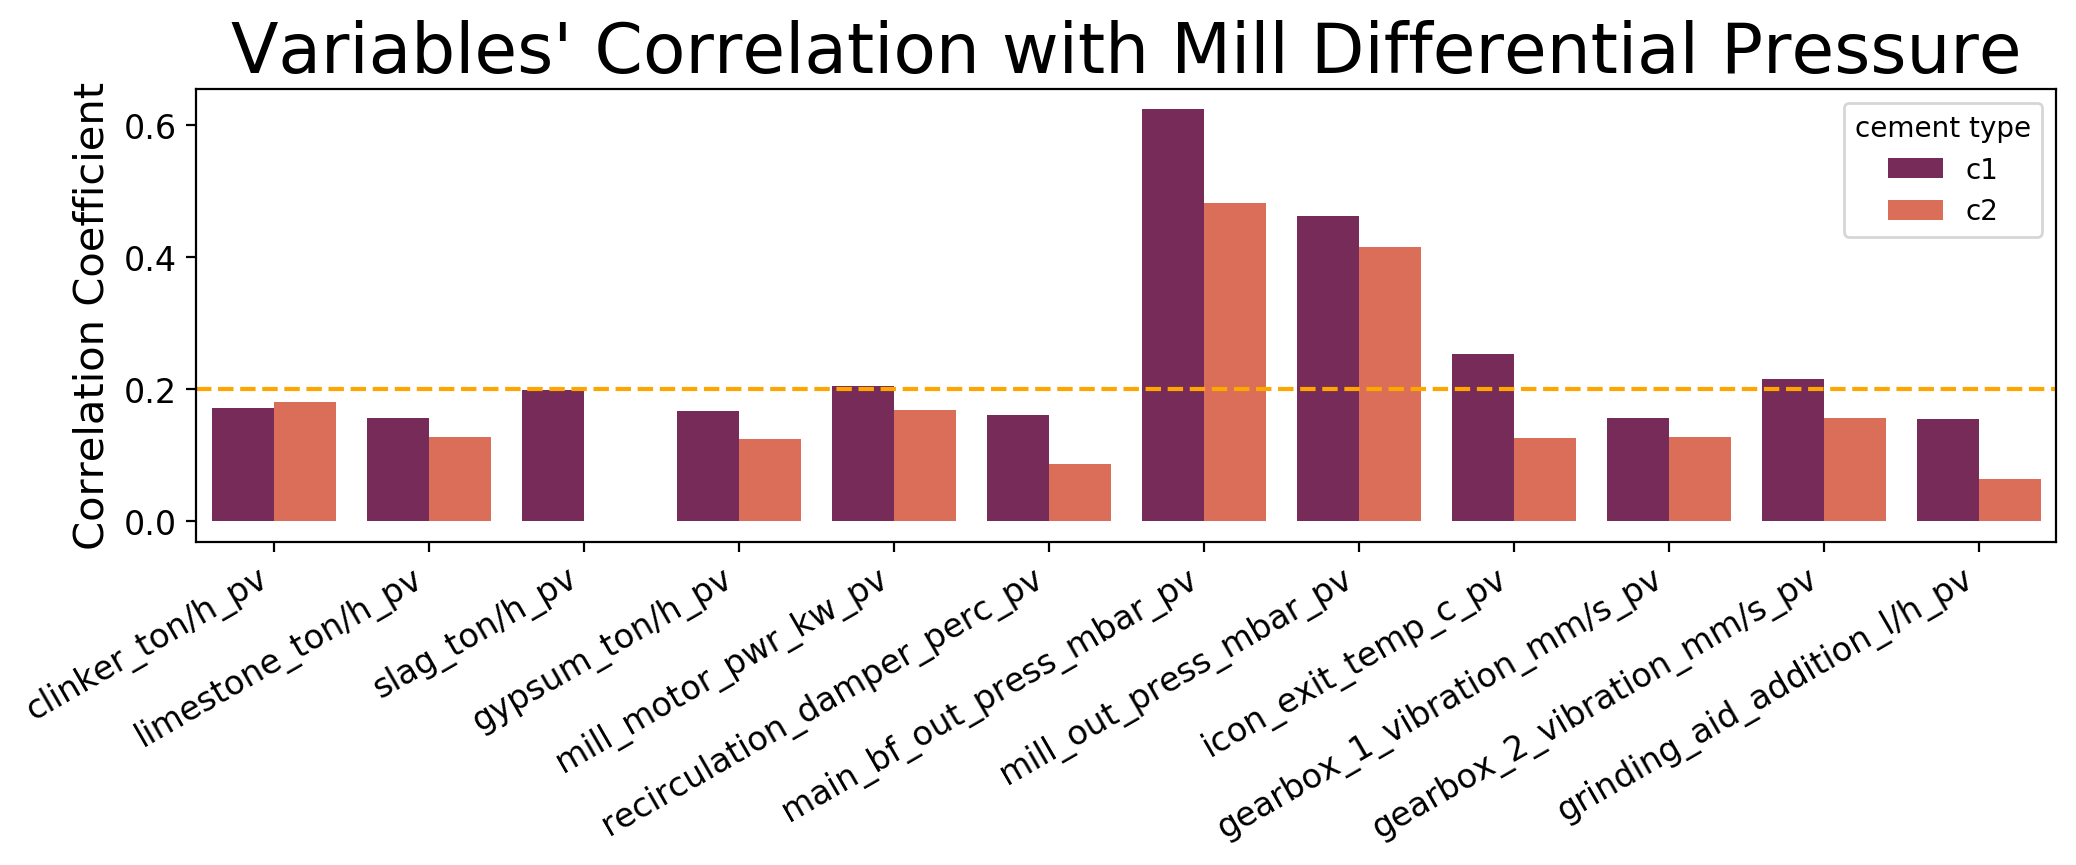

In [177]:
fig, ax = plt.subplots(figsize = (12,3), dpi=200)
sns.barplot(x = 'col_names', y= 'correlations', hue = 'cement type', data=correlations,ax=ax, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title("Variables' Correlation with Mill Differential Pressure",size=25)
ax.set_ylabel('Correlation Coefficient', size = 15)
ax.set_xlabel('')
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.axhline(0.2, ls='--', color = 'orange')
ax.tick_params(labelsize=12)